# Developing a unified representation of Alzheimer’s subtypes

# Part 4: Cluster Clincal Significance Assessment

After determining the potential unified representaions of the combined 3 subtypes, its important to understand if these groups have shared characteristics that provide some clinical significance to the findings. 
This notebook will assess the groups based on - diagnosis, age, gender, APOE4 carriers, MMSE scores, years of education, age at retirement  and lobe progression pattern asymmetry. 

## Import Packages

In [1]:
# import the python packages needed to generate simulated data for the tutorial
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
from scipy import stats
from scipy.stats import linregress, shapiro, ttest_ind, mannwhitneyu, f_oneway, kruskal, chi2_contingency, fisher_exact, ttest_1samp, norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import sklearn.model_selection
import sys
import shutil
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*figure layout has changed to tight.*")
from itertools import combinations, product
from pathlib import Path
import pickle



sys.path.insert(0,'/Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/')

## 1. Read relevant data

In [2]:
# Load and rename columns for MRI
zdata_mri = pd.read_csv("Train_MRI_SuStaIn_1.csv")
zdata_mri = zdata_mri.rename(columns={
    'ml_subtype': 'ml_subtype_MRI',
    'ml_stage': 'ml_stage_MRI'
})

# Load and rename columns for Aβ
zdata_ab = pd.read_csv("Train_AB_SuStaIn_2.csv")
zdata_ab = zdata_ab.rename(columns={
    'ml_subtype': 'ml_subtype_AB',
    'ml_stage': 'ml_stage_AB'
})

# Load and rename columns for Tau
zdata_tau = pd.read_csv("Train_TAU_SuStaIn_3.csv")
zdata_tau = zdata_tau.rename(columns={
    'ml_subtype': 'ml_subtype_TAU',
    'ml_stage': 'ml_stage_TAU'
})


In [3]:
# Define key columns and Column indicators for results of different modalities
rid = "RID"
dat = "EXAMDATE"
dx = "DIAGNOSIS_STRING"
diagnosis_num = "DIAGNOSIS" 
mmse_score = "MMSCORE" #memory scores - lower indicate more impairment
apoe4 = "APOE4" #presence of the gene APOE4
educ = "PTEDUCAT" #years of education
gender = "PTGENDER" #Gender- Male=1, Female=2
y_startadsym = "PTADBEG" #year of onset of AD symptoms
headsize_mri = "ICV_CorticalVolume" #overall headsize
y_of_birth = "PTDOBYY"
age = "Age"
retire_age = "AGE_RETIRE"
retirement = "PTNOTRT" #retired = 1, not retired = 0
y_retirement = "PTRTYR" #year of retirement

categories = [dx, age, mmse_score, apoe4, educ, gender, retire_age]
categories_mri = [diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age, headsize_mri]
asym_mri = ['Frontal_lobe_Asymmetry_MRI_L','Frontal_lobe_Asymmetry_MRI_R', 'Occipital_lobe_Asymmetry_MRI_L','Occipital_lobe_Asymmetry_MRI_R', 
        'Parietal_lobe_Asymmetry_MRI_L','Parietal_lobe_Asymmetry_MRI_R', 'Temporal_lobe_Asymmetry_MRI_L','Temporal_lobe_Asymmetry_MRI_R', 
        'MTL_Asymmetry_MRI_L','MTL_Asymmetry_MRI_R'] 
asym_ab = ['Frontal_lobe_Asymmetry_ab_L','Frontal_lobe_Asymmetry_ab_R', 'Occipital_lobe_Asymmetry_ab_L','Occipital_lobe_Asymmetry_ab_R', 
           'Parietal_lobe_Asymmetry_ab_L','Parietal_lobe_Asymmetry_ab_R', 'Temporal_lobe_Asymmetry_ab_L','Temporal_lobe_Asymmetry_ab_R', 
           'MTL_Asymmetry_ab_L', 'MTL_Asymmetry_ab_R']
asym_tau = ['Frontal_lobe_Asymmetry_tau_L','Frontal_lobe_Asymmetry_tau_R', 'Occipital_lobe_Asymmetry_tau_L','Occipital_lobe_Asymmetry_tau_R', 
        'Parietal_lobe_Asymmetry_tau_L','Parietal_lobe_Asymmetry_tau_R', 'Temporal_lobe_Asymmetry_tau_L','Temporal_lobe_Asymmetry_tau_R', 
        'MTL_Asymmetry_tau_L','MTL_Asymmetry_tau_R']



continuous_vars = [age, mmse_score, educ, retire_age]
categorical_vars = [dx, gender, apoe4]




In [4]:
def standardize_label(label, modality):
    # Map known patterns to standardized lobe names
    lobe_map = {
        "mtl": "MTL",
        "temporal": "Temporal_Lobe",
        "parietal": "Parietal_Lobe",
        "frontal": "Frontal_Lobe",
        "occipital": "Occipital_Lobe"
    }

    # Lowercase and remove suffixes
    label_clean = (
        label.lower()
        .replace("_suvr_weighted", "")
        .replace("_volume", "")
        .replace("_suvr", "")
        .replace("_weighted_tau", "")
        .replace("_", "")
    )

    # Match lobe name
    for key in lobe_map:
        if key in label_clean:
            return f"{lobe_map[key]}"
    
    return f"UnknownLobe"


In [5]:
#Sustain data per modality
N_startpoints = 50

#MRI
N_S_max_mri = 4
N_iterations_MCMC = int(1e5)
output_folder_mri = os.path.join(os.getcwd(), 'MRIOutput')
dataset_name_mri = 'MRIOutput'
pickle_filename_s_mri = output_folder_mri + '/pickle_files/' + dataset_name_mri + '_subtype' + str(N_S_max_mri-1) + '.pickle'
pk_mri = pd.read_pickle(pickle_filename_s_mri)
samples_sequence_mri = pk_mri["samples_sequence"]
samples_f_mri = pk_mri["samples_f"]

biomarkers_mri = ['Frontal_lobe_volume', 'Occipital_lobe_volume', 'Parietal_lobe_volume','Temporal_lobe_volume', 'MTL_volume']
N_mri = len(biomarkers_mri)    
SuStaInLabels_mri = [standardize_label(b, "MRI") for b in biomarkers_mri]
Z_vals_mri = np.array([[2,3,4.5]]*N_mri)     # Z-scores for each biomarker
Z_max_mri  = np.ceil(np.percentile(zdata_mri[biomarkers_mri].values,99,axis=0)).astype('int')           # maximum z-score

sustain_input_mri = pySuStaIn.ZscoreSustain(
                              zdata_mri[biomarkers_mri].values,
                              Z_vals_mri,
                              Z_max_mri,
                              SuStaInLabels_mri,
                              N_startpoints,
                              N_S_max_mri, 
                              N_iterations_MCMC, 
                              output_folder_mri, 
                              dataset_name_mri, 
                              False)

pickle_filepath_mri             = Path(pickle_filename_s_mri)
pickle_file_mri                 = open(pickle_filename_s_mri, 'rb')
loaded_variables_mri            = pickle.load(pickle_file_mri)
ml_subtype_mri                  = loaded_variables_mri["ml_subtype"]
prob_ml_subtype_mri             = loaded_variables_mri["prob_ml_subtype"]
ml_stage_mri                    = loaded_variables_mri["ml_stage"]
prob_ml_stage_mri               = loaded_variables_mri["prob_ml_stage"]
prob_subtype_mri                = loaded_variables_mri["prob_subtype"]
prob_stage_mri                  = loaded_variables_mri["prob_stage"]
prob_subtype_stage_mri          = loaded_variables_mri["prob_subtype_stage"]
ml_seq_mri                      = loaded_variables_mri["ml_sequence_EM"]
pickle_file_mri.close()    

#AB
N_S_max_ab = 2
output_folder_ab = os.path.join(os.getcwd(), 'ABOutput')
dataset_name_ab = 'ABOutput'
pickle_filename_s_ab = output_folder_ab + '/pickle_files/' + dataset_name_ab + '_subtype' + str(N_S_max_ab-1) + '.pickle'
pk_ab = pd.read_pickle(pickle_filename_s_ab)
samples_sequence_ab = pk_ab["samples_sequence"]
samples_f_ab = pk_ab["samples_f"]

biomarkers_ab = ['Frontal_lobe_SUVR_weighted_ab', 'Occipital_lobe_SUVR_weighted_ab','Parietal_lobe_SUVR_weighted_ab', 'Temporal_lobe_SUVR_weighted_ab','MTL_SUVR_weighted_ab']
N_ab = len(biomarkers_ab)      
SuStaInLabels_ab = [standardize_label(b, "AB") for b in biomarkers_ab]
Z_vals_ab = np.array([[1,2,3.5]]*N_ab)     # Z-scores for each biomarker
Z_max_ab  = np.ceil(np.percentile(zdata_ab[biomarkers_ab].values,99,axis=0)).astype('int')           # maximum z-score
sustain_input_ab = pySuStaIn.ZscoreSustain(
                              zdata_ab[biomarkers_ab].values,
                              Z_vals_ab,
                              Z_max_ab,
                              SuStaInLabels_ab,
                              N_startpoints,
                              N_S_max_ab, 
                              N_iterations_MCMC, 
                              output_folder_ab, 
                              dataset_name_ab, 
                              False)

pickle_filepath_ab             = Path(pickle_filename_s_ab)
pickle_file_ab                 = open(pickle_filename_s_ab, 'rb')
loaded_variables_ab            = pickle.load(pickle_file_ab)
ml_subtype_ab                  = loaded_variables_ab["ml_subtype"]
prob_ml_subtype_ab             = loaded_variables_ab["prob_ml_subtype"]
ml_stage_ab                    = loaded_variables_ab["ml_stage"]
prob_ml_stage_ab               = loaded_variables_ab["prob_ml_stage"]
prob_subtype_ab                = loaded_variables_ab["prob_subtype"]
prob_stage_ab                  = loaded_variables_ab["prob_stage"]
prob_subtype_stage_ab          = loaded_variables_ab["prob_subtype_stage"]
ml_seq_ab                      = loaded_variables_ab["ml_sequence_EM"]
pickle_file_ab.close()              


#TAU
N_S_max_tau = 4
output_folder_tau = os.path.join(os.getcwd(), 'TAUOutput')
dataset_name_tau = 'TAUOutput'
pickle_filename_s_tau = output_folder_tau + '/pickle_files/' + dataset_name_tau + '_subtype' + str(N_S_max_tau-1) + '.pickle'
pk_tau = pd.read_pickle(pickle_filename_s_tau)
samples_sequence_tau = pk_tau["samples_sequence"]
samples_f_tau = pk_tau["samples_f"]

biomarkers_tau = ['Frontal_lobe_SUVR_weighted_tau', 'Occipital_lobe_SUVR_weighted_tau', 'Parietal_lobe_SUVR_weighted_tau', 'Temporal_lobe_SUVR_weighted_tau', 'MTL_SUVR_weighted_tau']
N_tau = len(biomarkers_tau)         
SuStaInLabels_tau = [standardize_label(b, "TAU") for b in biomarkers_tau]
Z_vals_tau = np.array([[3,5,6.5]]*N_tau)     # Z-scores for each biomarker
Z_max_tau  = np.ceil(np.nanpercentile(zdata_tau[biomarkers_tau].values,99,axis=0)).astype('int')           # maximum z-score

sustain_input_tau = pySuStaIn.ZscoreSustain(
                              zdata_tau[biomarkers_tau].values,
                              Z_vals_tau,
                              Z_max_tau,
                              SuStaInLabels_tau,
                              N_startpoints,
                              N_S_max_tau, 
                              N_iterations_MCMC, 
                              output_folder_tau, 
                              dataset_name_tau, 
                              False)

pickle_filepath_tau             = Path(pickle_filename_s_tau)
pickle_file_tau                 = open(pickle_filename_s_tau, 'rb')
loaded_variables_tau            = pickle.load(pickle_file_tau)
ml_subtype_tau                  = loaded_variables_tau["ml_subtype"]
prob_ml_subtype_tau             = loaded_variables_tau["prob_ml_subtype"]
ml_stage_tau                    = loaded_variables_tau["ml_stage"]
prob_ml_stage_tau               = loaded_variables_tau["prob_ml_stage"]
prob_subtype_tau                = loaded_variables_tau["prob_subtype"]
prob_stage_tau                  = loaded_variables_tau["prob_stage"]
prob_subtype_stage_tau          = loaded_variables_tau["prob_subtype_stage"]
ml_seq_tau                      = loaded_variables_tau["ml_sequence_EM"]
pickle_file_tau.close()              


## 2. Characterise individual subtypes:

In [6]:
# === Effect size helpers ===
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx -1)*np.var(x, ddof=1) + (ny -1)*np.var(y, ddof=1))/dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

def eta_squared(F, df):
    df1, df2 = df
    return (F * df1) / (F * df1 + df2)

def epsilon_squared(H, N, k):
    return (H - k + 1) / (N - k)

def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.values.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# === Post hoc Mann-Whitney U with Bonferroni correction ===
def pairwise_posthoc_mannwhitney(df, variable, group_col, alpha=0.05):
    groups = df[group_col].unique()
    pairs = list(combinations(groups, 2))
    results = []

    for g1, g2 in pairs:
        data1 = df[df[group_col] == g1][variable]
        data2 = df[df[group_col] == g2][variable]
        stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
        results.append({'pair': f'{g1} vs {g2}', 'p_uncorrected': p})

    # Bonferroni correction
    m = len(results)
    for i, res in enumerate(results):
        p_corr = min(res['p_uncorrected'] * m, 1.0)
        res['p_bonferroni'] = p_corr
        res['significant'] = p_corr < alpha

    return pd.DataFrame(results)



====== AB Individual Subtype Analysis ======

 AGE (Continuous)
  Group sizes: {1.0: 847, 2.0: 25}
→ Mann-Whitney U test p = 0.6648


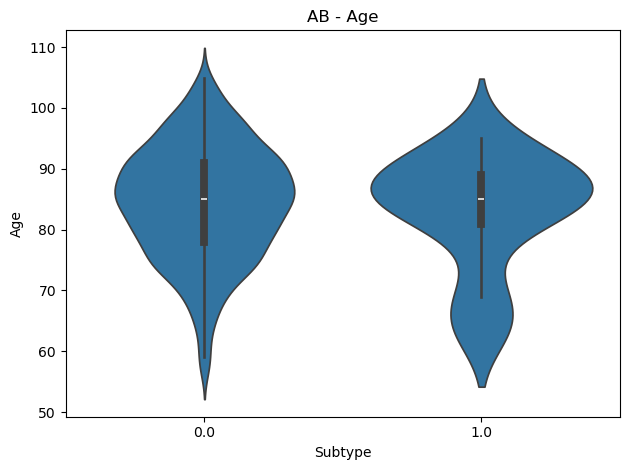


 MMSCORE (Continuous)
  Group sizes: {1.0: 165, 2.0: 2}
 Small sample size detected in at least one group.
→ Mann-Whitney U test p = 0.0922


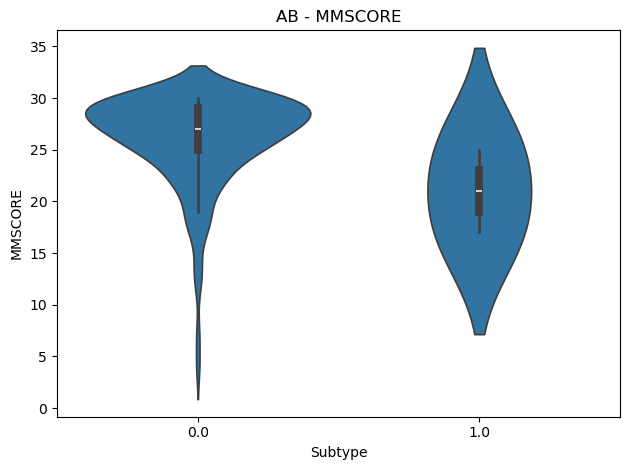


 PTEDUCAT (Continuous)
  Group sizes: {1.0: 847, 2.0: 25}
→ Mann-Whitney U test p = 0.7391


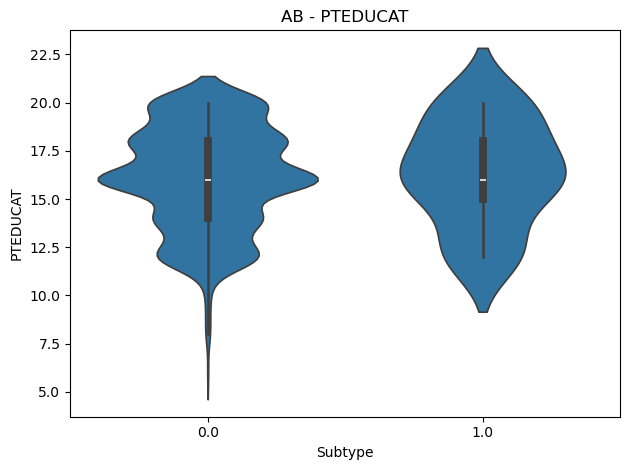


 AGE_RETIRE (Continuous)
  Group sizes: {1.0: 672, 2.0: 22}
→ Mann-Whitney U test p = 0.8379


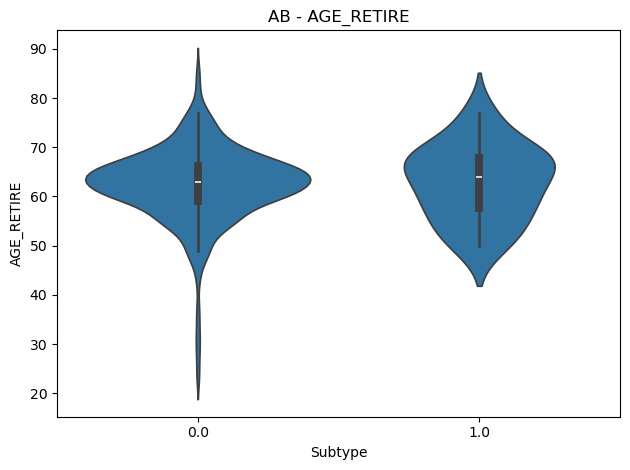



====== TAU Individual Subtype Analysis ======

 AGE (Continuous)
  Group sizes: {1.0: 262, 2.0: 226, 3.0: 64, 4.0: 25}
→ ANOVA p = 0.1571 | Eta² = 0.009


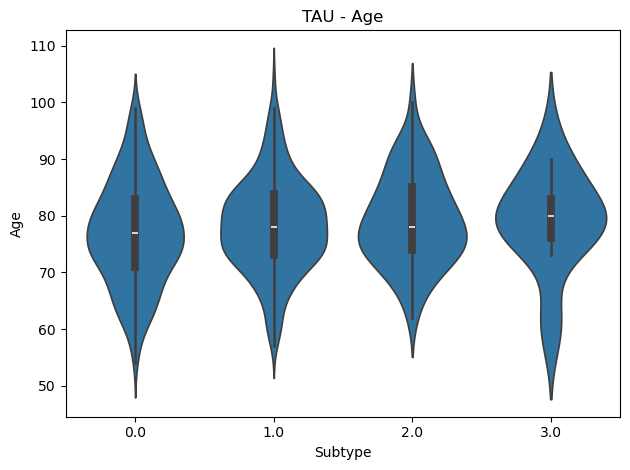


 MMSCORE (Continuous)
  Group sizes: {1.0: 41, 2.0: 27, 3.0: 14, 4.0: 4}
 Small sample size detected in at least one group.
→ Kruskal-Wallis p = 0.0005 | Epsilon² = 0.180


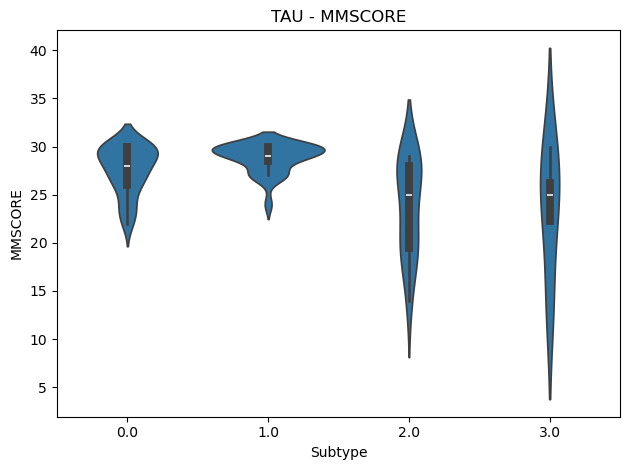


 PTEDUCAT (Continuous)
  Group sizes: {1.0: 262, 2.0: 226, 3.0: 64, 4.0: 25}
→ Kruskal-Wallis p = 0.0278 | Epsilon² = 0.011


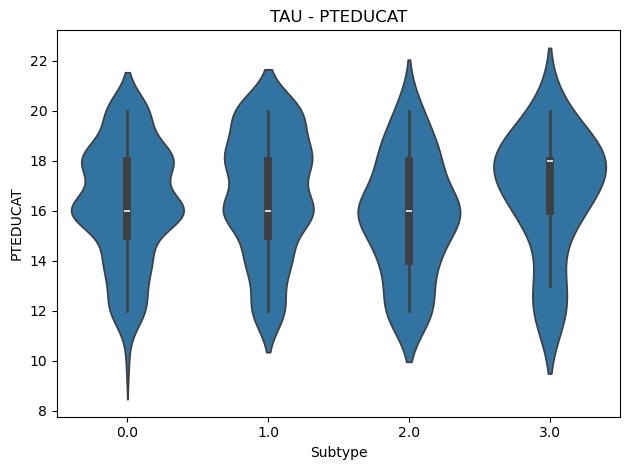


 AGE_RETIRE (Continuous)
  Group sizes: {1.0: 199, 2.0: 170, 3.0: 54, 4.0: 20}
→ Kruskal-Wallis p = 0.4768 | Epsilon² = -0.001


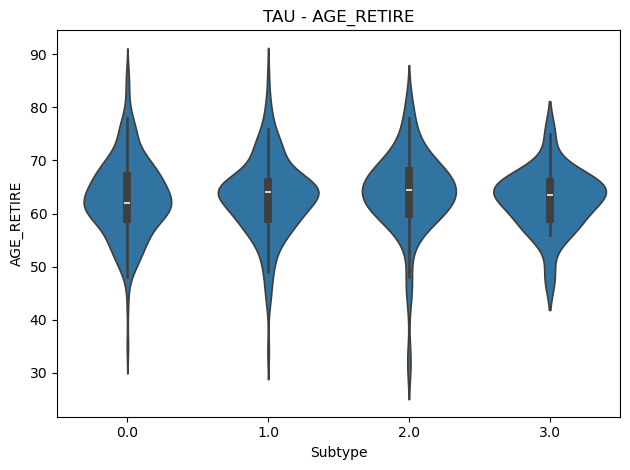



====== MRI Individual Subtype Analysis ======

 AGE (Continuous)
  Group sizes: {1.0: 1250, 2.0: 21, 3.0: 12, 4.0: 10}
→ Kruskal-Wallis p = 0.0000 | Epsilon² = 0.024


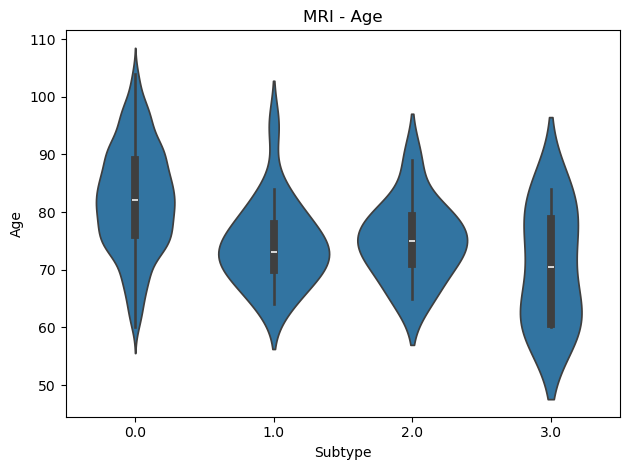


 MMSCORE (Continuous)
  Group sizes: {1.0: 1238, 2.0: 21, 3.0: 12, 4.0: 10}
→ Kruskal-Wallis p = 0.7906 | Epsilon² = -0.002


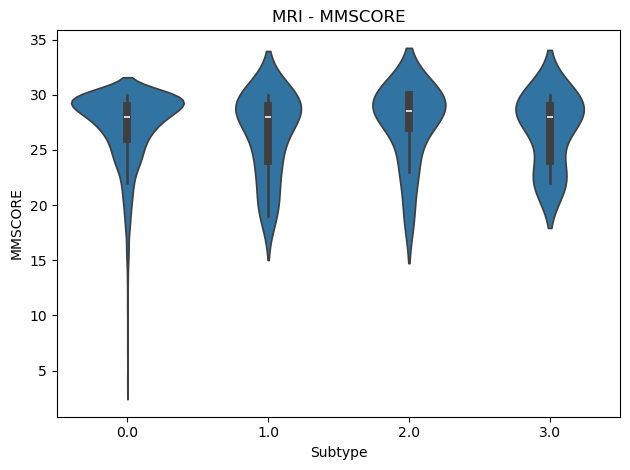


 PTEDUCAT (Continuous)
  Group sizes: {1.0: 1250, 2.0: 21, 3.0: 12, 4.0: 10}
→ Kruskal-Wallis p = 0.0973 | Epsilon² = 0.003


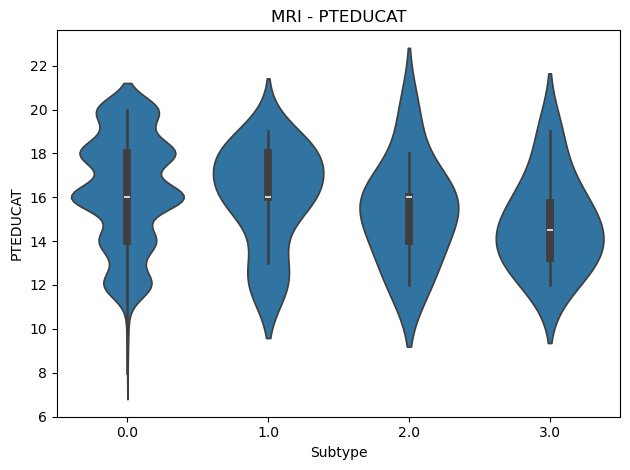


 AGE_RETIRE (Continuous)
  Group sizes: {1.0: 970, 2.0: 18, 3.0: 9, 4.0: 9}
→ Kruskal-Wallis p = 0.9449 | Epsilon² = -0.003


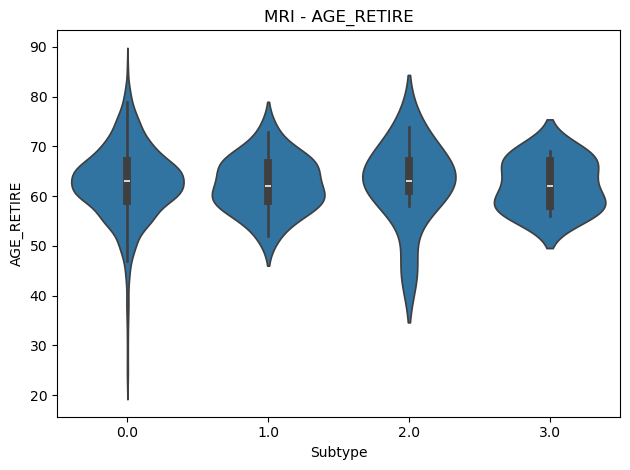



====== AB Individual Subtype Analysis ======

 DIAGNOSIS_STRING (Categorical)
→ Chi-squared p = 0.0000 | Cramér’s V = 0.169


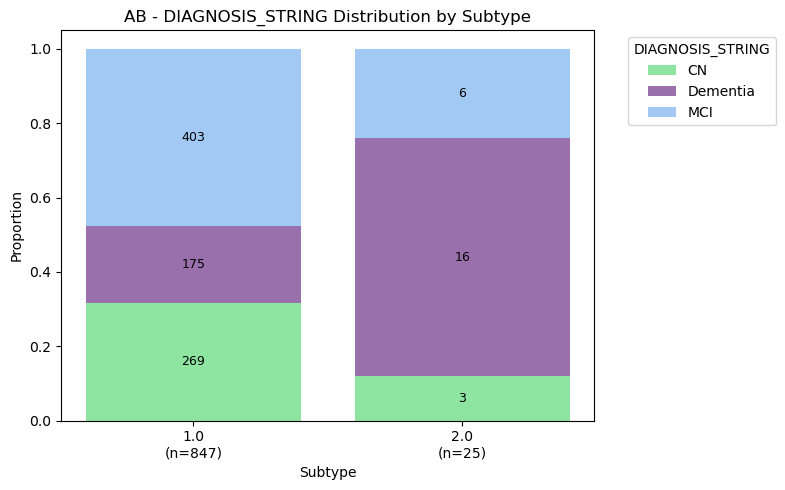


 PTGENDER (Categorical)
→ Chi-squared p = 0.0603 | Cramér’s V = 0.054


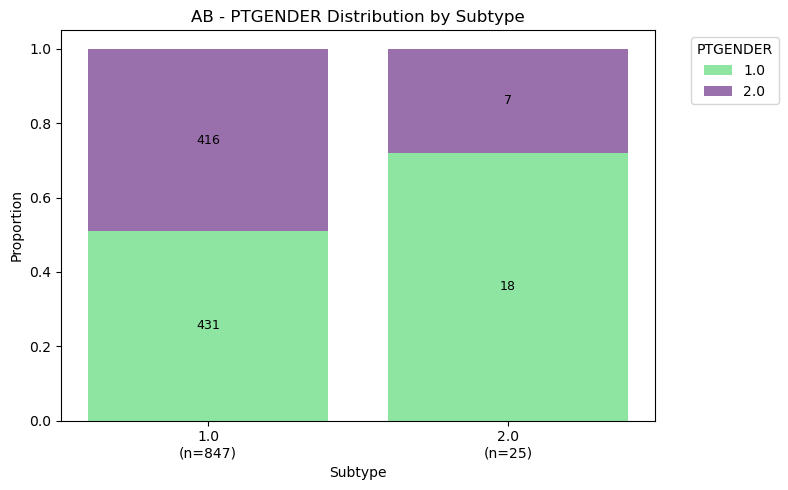


 APOE4 (Categorical)
 Expected cell count < 5 detected
 Fisher’s only supports 2x2; falling back to chi-squared.
→ Chi-squared p = 0.4735 | Cramér’s V = 0.000


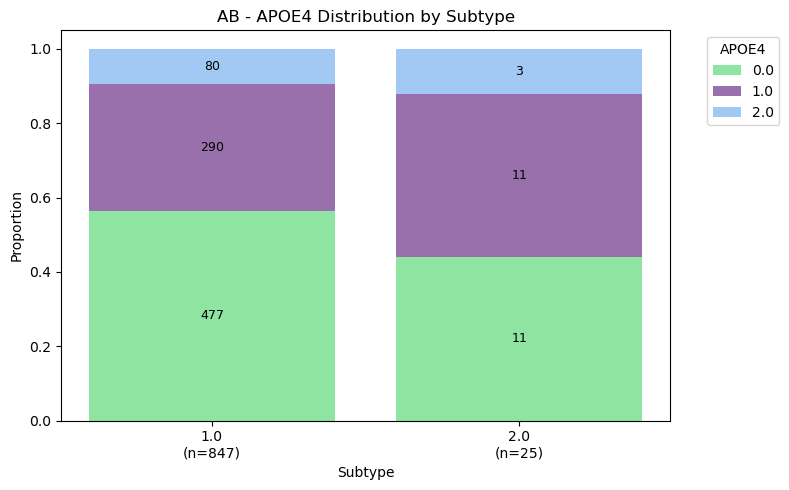



====== TAU Individual Subtype Analysis ======

 DIAGNOSIS_STRING (Categorical)
 Expected cell count < 5 detected
 Fisher’s only supports 2x2; falling back to chi-squared.
→ Chi-squared p = 0.0000 | Cramér’s V = 0.190


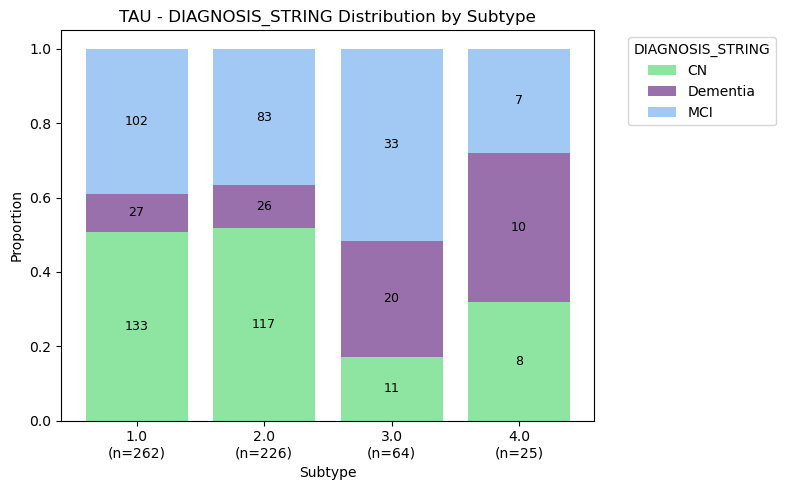


 PTGENDER (Categorical)
→ Chi-squared p = 0.2335 | Cramér’s V = 0.047


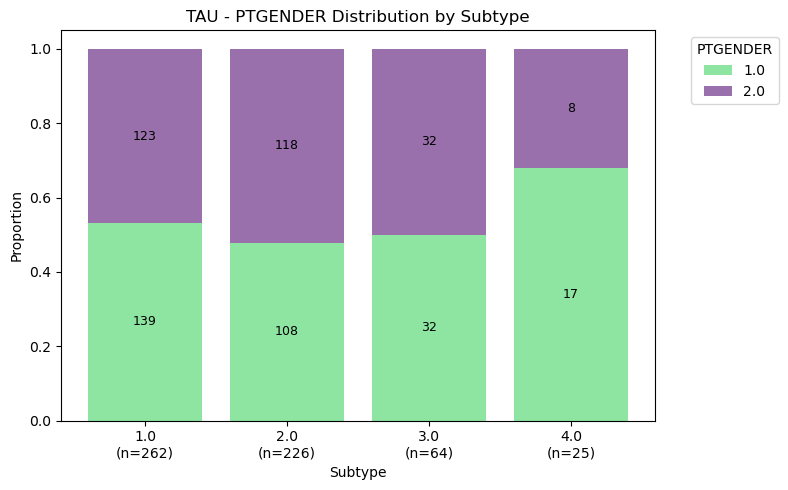


 APOE4 (Categorical)
 Expected cell count < 5 detected
 Fisher’s only supports 2x2; falling back to chi-squared.
→ Chi-squared p = 0.0000 | Cramér’s V = 0.172


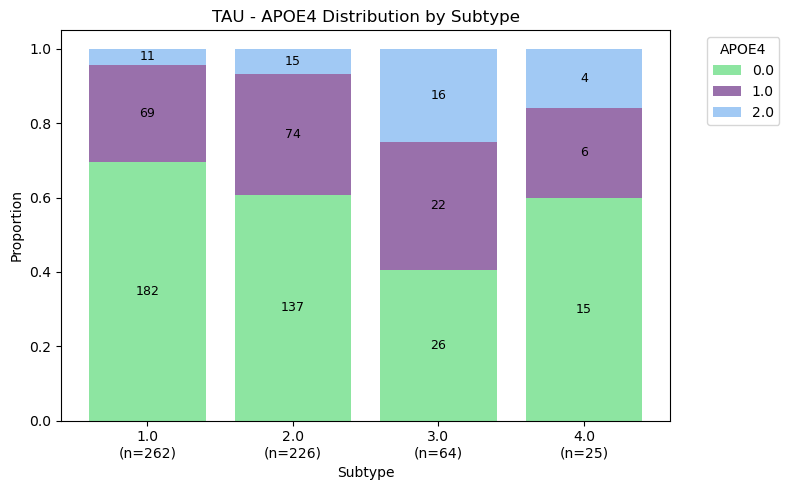



====== MRI Individual Subtype Analysis ======

 DIAGNOSIS_STRING (Categorical)
 Expected cell count < 5 detected
 Fisher’s only supports 2x2; falling back to chi-squared.
→ Chi-squared p = 0.1079 | Cramér’s V = 0.041


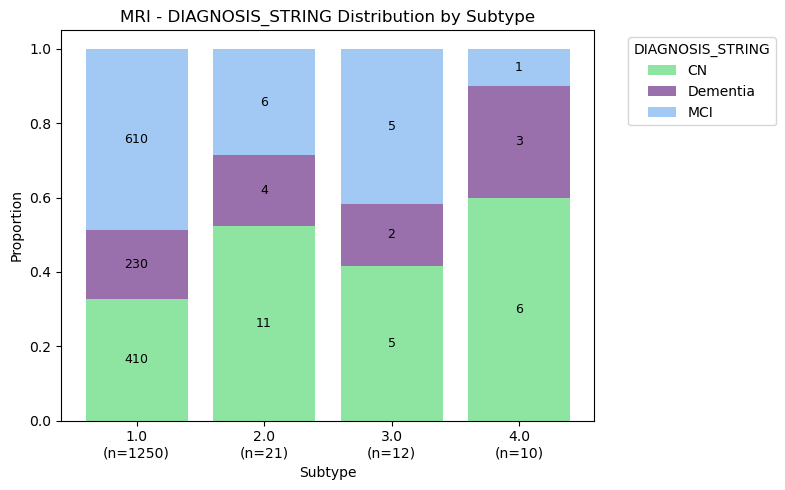


 PTGENDER (Categorical)
 Expected cell count < 5 detected
 Fisher’s only supports 2x2; falling back to chi-squared.
→ Chi-squared p = 0.8030 | Cramér’s V = 0.000


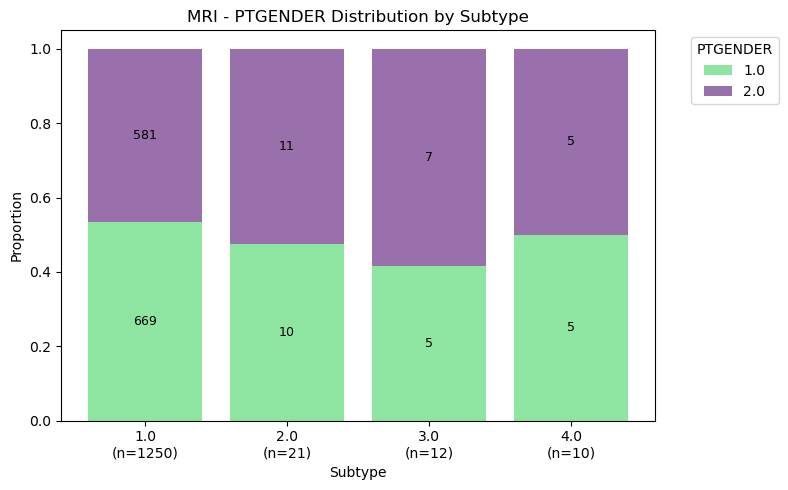


 APOE4 (Categorical)
 Expected cell count < 5 detected
 Fisher’s only supports 2x2; falling back to chi-squared.
→ Chi-squared p = 0.0748 | Cramér’s V = 0.046


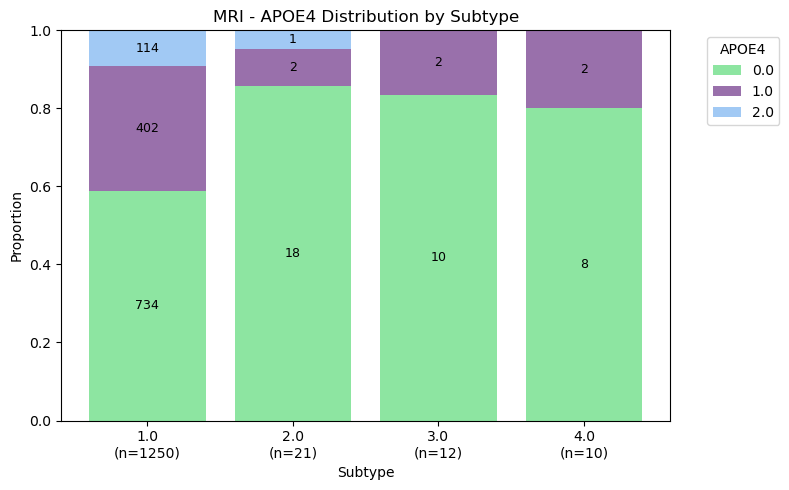

In [7]:
colors = ['#8de5a1', '#9970AB', '#a1c9f4']

modalities = {
    "AB": ('ml_subtype_AB', zdata_ab),
    "TAU": ('ml_subtype_TAU', zdata_tau),
    "MRI": ('ml_subtype_MRI', zdata_mri)
}

for modality, (subtype_col, df) in modalities.items():
    print(f"\n\n====== {modality} Individual Subtype Analysis ======")

    subtypes = sorted(df[subtype_col].dropna().unique())
    k = len(subtypes)
    
    # Create a color palette dictionary mapping subtype -> color cycling through my_colors
    color_cycle = (colors * ((k // len(colors)) + 1))[:k]
    my_palette = dict(zip([str(s + 1) for s in subtypes], color_cycle))  # +1 here


    # CONTINUOUS VARIABLES
    for var in continuous_vars:
        print(f"\n {var.upper()} (Continuous)")
        df_var = df.dropna(subset=[var, subtype_col])
        
        if var == mmse_score:
            df_var = df_var[df_var[var] > 0]
        if var == retire_age:
            df_var = df_var[df_var[var] > 0]

        grouped = [df_var[df_var[subtype_col] == s][var] for s in subtypes]
        sizes = [len(g) for g in grouped]
        print(f"  Group sizes: {dict(zip([s + 1 for s in subtypes], sizes))}")  # +1 here
        if any(n < 5 for n in sizes):
            print(" Small sample size detected in at least one group.")

        normal = all(shapiro(g)[1] > 0.05 for g in grouped if len(g) >= 3)

        if k == 2:
            x, y = grouped
            if normal:
                stat, p = ttest_ind(x, y, equal_var=False)
                d = cohen_d(x, y)
                print(f"→ Welch's t-test p = {p:.4f} | Cohen’s d = {d:.3f}")
            else:
                stat, p = mannwhitneyu(x, y)
                print(f"→ Mann-Whitney U test p = {p:.4f}")
        else:
            if normal:
                stat, p = f_oneway(*grouped)
                df1, df2 = k - 1, len(df_var) - k
                eta2 = eta_squared(stat, (df1, df2))
                print(f"→ ANOVA p = {p:.4f} | Eta² = {eta2:.3f}")
                if p < 0.05:
                    tukey_data = pd.concat([
                        pd.Series(g, name=var).to_frame().assign(subtype=s + 1)
                        for g, s in zip(grouped, subtypes)
                    ])
                    tukey = pairwise_tukeyhsd(tukey_data[var], tukey_data['subtype'])
                    print(tukey.summary())
            else:
                stat, p = kruskal(*grouped)
                eps2 = epsilon_squared(stat, len(df_var), k)
                print(f"→ Kruskal-Wallis p = {p:.4f} | Epsilon² = {eps2:.3f}")

        # Plot violin with your palette
        sns.violinplot(x=subtype_col, y=var, data=df_var)
        plt.title(f'{modality} - {var}')
        plt.xlabel("Subtype")  # Clarify on plot
        plt.ylabel(var)
        plt.tight_layout()
        plt.show()

    colors = ['#8de5a1', '#9970AB', '#a1c9f4']  # fixed order and set

for modality, (subtype_col, df) in modalities.items():
    print(f"\n\n====== {modality} Individual Subtype Analysis ======")

    subtypes = sorted(df[subtype_col].dropna().unique())
    k = len(subtypes)

    # Cycle colors exactly in order for subtypes, repeating if needed
    color_cycle = [colors[i % len(colors)] for i in range(k)]
    my_palette = dict(zip([str(s + 1) for s in subtypes], color_cycle))  # +1 here

    # CATEGORICAL VARIABLES
    # Inside your categorical variable loop
    for var in categorical_vars:
        print(f"\n {var.upper()} (Categorical)")
        if df[var].isnull().all():
            print(" Variable missing entirely.")
            continue

        table = pd.crosstab(df[subtype_col], df[var])
        expected = chi2_contingency(table, correction=False)[3]

        if (expected < 5).any():
            print(" Expected cell count < 5 detected")
            if table.shape == (2, 2):
                _, p = fisher_exact(table)
                print(f"→ Fisher’s Exact p = {p:.4f}")
            else:
                print(" Fisher’s only supports 2x2; falling back to chi-squared.")
                chi2, p, _, _ = chi2_contingency(table)
                v = cramers_v(table)
                print(f"→ Chi-squared p = {p:.4f} | Cramér’s V = {v:.3f}")
        else:
            chi2, p, _, _ = chi2_contingency(table)
            v = cramers_v(table)
            print(f"→ Chi-squared p = {p:.4f} | Cramér’s V = {v:.3f}")

        # Proportion DataFrame
        prop_df = table.div(table.sum(1), axis=0)
        subtype_counts = table.sum(axis=1)
        new_labels = [f"{s + 1}\n(n={n})" for s, n in subtype_counts.items()]  # +1 here

        # Extract unique sorted categories from column headers
        categories = list(prop_df.columns)
        color_list = colors[:len(categories)]  # Only take as many colors as needed
        cat_palette = dict(zip(categories, color_list))

        # Plot
        fig, ax = plt.subplots(figsize=(8, 5))
        bottom = np.zeros(len(prop_df))

        for i, category in enumerate(categories):
            proportions = prop_df[category].values
            counts = table[category].values
            bars = ax.bar(
                x=np.arange(len(prop_df)),
                height=proportions,
                bottom=bottom,
                color=color_list[i],
                label=category
            )

            # Add count labels inside each bar
            for j, bar in enumerate(bars):
                count = counts[j]
                if count > 0:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        bar.get_y() + bar.get_height() / 2,
                        f'{int(count)}',
                        ha='center', va='center',
                        fontsize=9, color='black'
                    )

            bottom += proportions

        ax.set_title(f'{modality} - {var} Distribution by Subtype')
        ax.set_ylabel("Proportion")
        ax.set_xlabel("Subtype")
        ax.set_xticks(range(len(new_labels)))
        ax.set_xticklabels(new_labels)
        ax.legend(title=var, bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.show()


In [8]:
# Assess individual subtype characteristics
zdata_ab.groupby('ml_subtype_AB')[continuous_vars].agg(['mean', 'std'])


Age             MMSCORE              PTEDUCAT            \
                   mean       std      mean        std       mean       std   
ml_subtype_AB                                                                 
0.0            84.46281  9.384773  5.090909  10.532849  16.105077  2.655929   
1.0            82.96000  9.347370  1.680000   5.928181  16.320000  2.703701   

              AGE_RETIRE             
                    mean        std  
ml_subtype_AB                        
0.0             49.53719  26.215974  
1.0             55.28000  22.002879

In [9]:
zdata_tau.groupby('ml_subtype_TAU')[continuous_vars].agg(['mean', 'std'])


Age             MMSCORE              PTEDUCAT            \
                     mean       std      mean        std       mean       std   
ml_subtype_TAU                                                                  
0.0             76.973282  9.174931  4.320611  10.097052  16.290076  2.342310   
1.0             78.274336  8.268008  3.446903   9.392163  16.676991  2.450778   
2.0             79.203125  7.920597  5.187500  10.136959  15.765625  2.348537   
3.0             79.040000  8.885756  3.760000   9.111714  16.680000  2.393045   

               AGE_RETIRE             
                     mean        std  
ml_subtype_TAU                        
0.0             47.797710  27.698173  
1.0             47.486726  28.033191  
2.0             53.906250  24.433076  
3.0             50.040000  26.018391

In [10]:
zdata_mri.groupby('ml_subtype_MRI')[continuous_vars].agg(['mean', 'std'])

Age              MMSCORE             PTEDUCAT            \
                     mean       std       mean       std       mean       std   
ml_subtype_MRI                                                                  
0.0             82.110400  9.279434  26.843200  4.223847  16.298400  2.515874   
1.0             74.333333  7.129750  26.428571  3.654743  16.047619  2.224324   
2.0             75.000000  6.605783  27.333333  3.498918  15.333333  2.309401   
3.0             70.500000  9.868581  26.800000  3.224903  14.800000  2.097618   

               AGE_RETIRE             
                     mean        std  
ml_subtype_MRI                        
0.0             48.666400  26.989395  
1.0             53.380952  22.863675  
2.0             46.916667  29.112504  
3.0             56.000000  20.231988

In [11]:
pd.crosstab(zdata_ab['ml_subtype_AB'], zdata_ab[dx], normalize='index') * 100


DIAGNOSIS_STRING        CN   Dementia        MCI
ml_subtype_AB                                   
0.0               31.75915  20.661157  47.579693
1.0               12.00000  64.000000  24.000000

In [12]:
pd.crosstab(zdata_tau['ml_subtype_TAU'], zdata_tau[dx], normalize='index') * 100

DIAGNOSIS_STRING         CN   Dementia        MCI
ml_subtype_TAU                                   
0.0               50.763359  10.305344  38.931298
1.0               51.769912  11.504425  36.725664
2.0               17.187500  31.250000  51.562500
3.0               32.000000  40.000000  28.000000

In [13]:
pd.crosstab(zdata_mri['ml_subtype_MRI'], zdata_mri[dx], normalize='index') * 100

DIAGNOSIS_STRING         CN   Dementia        MCI
ml_subtype_MRI                                   
0.0               32.800000  18.400000  48.800000
1.0               52.380952  19.047619  28.571429
2.0               41.666667  16.666667  41.666667
3.0               60.000000  30.000000  10.000000


======= Plotting for AB subtypes =======



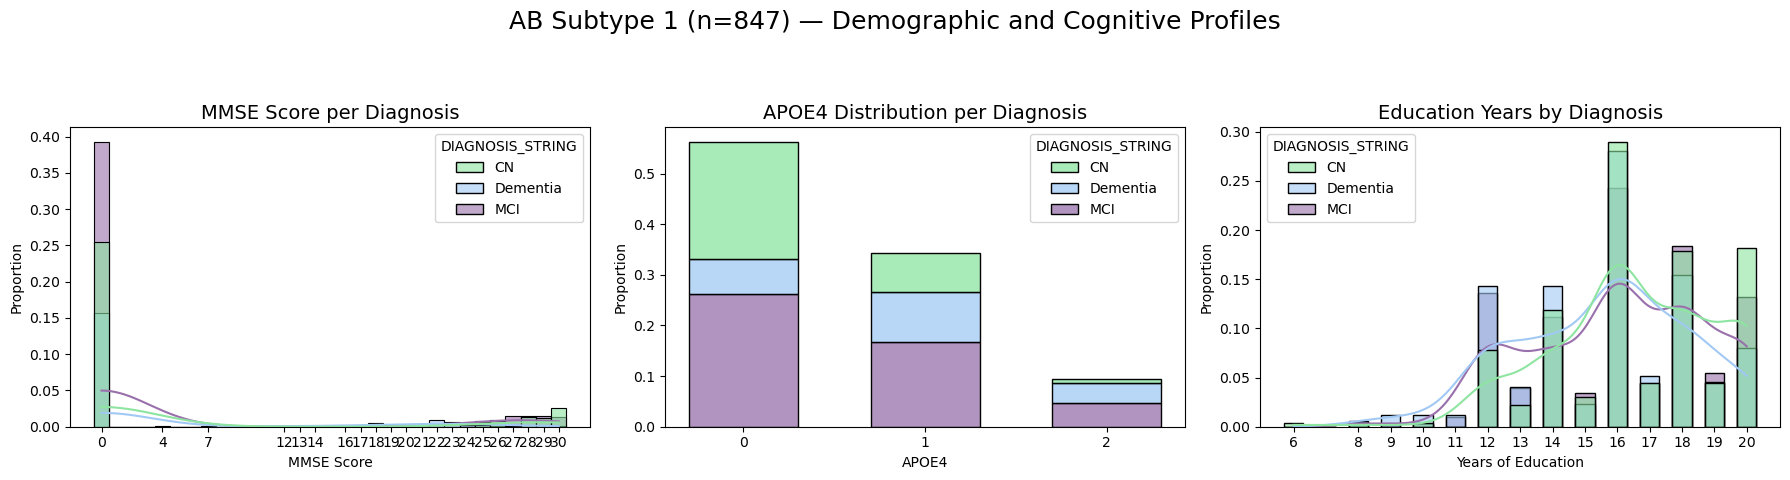

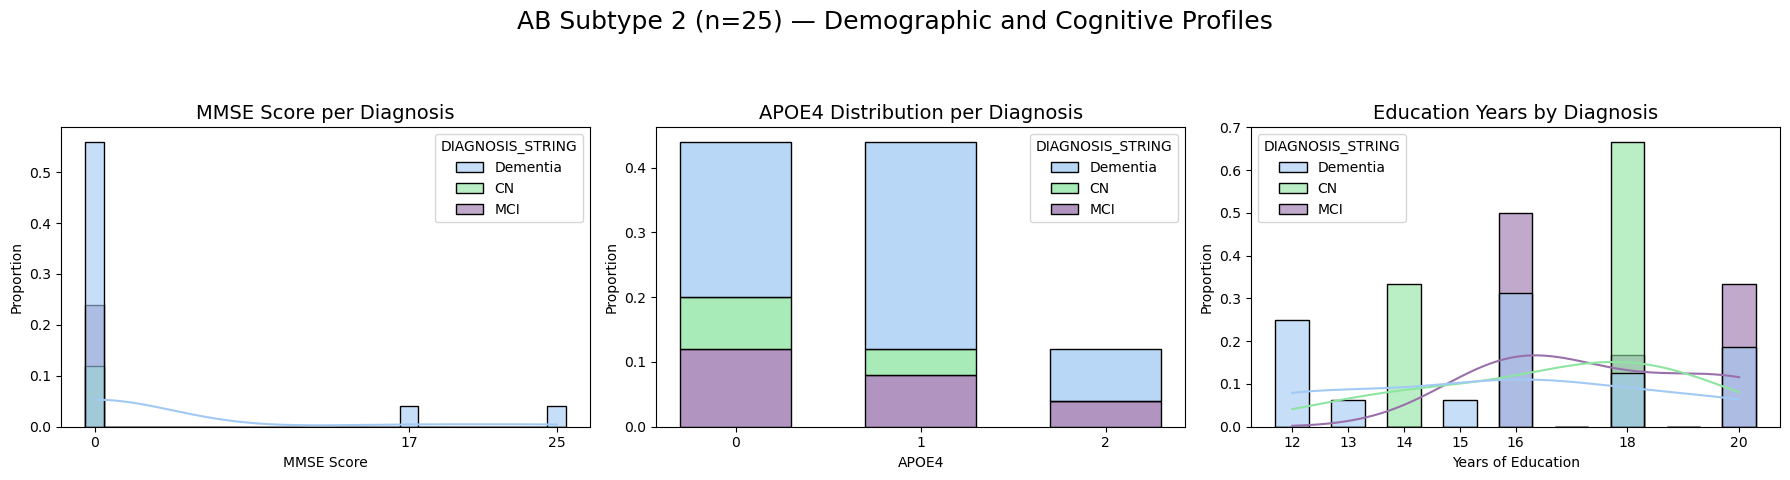


======= Plotting for TAU subtypes =======



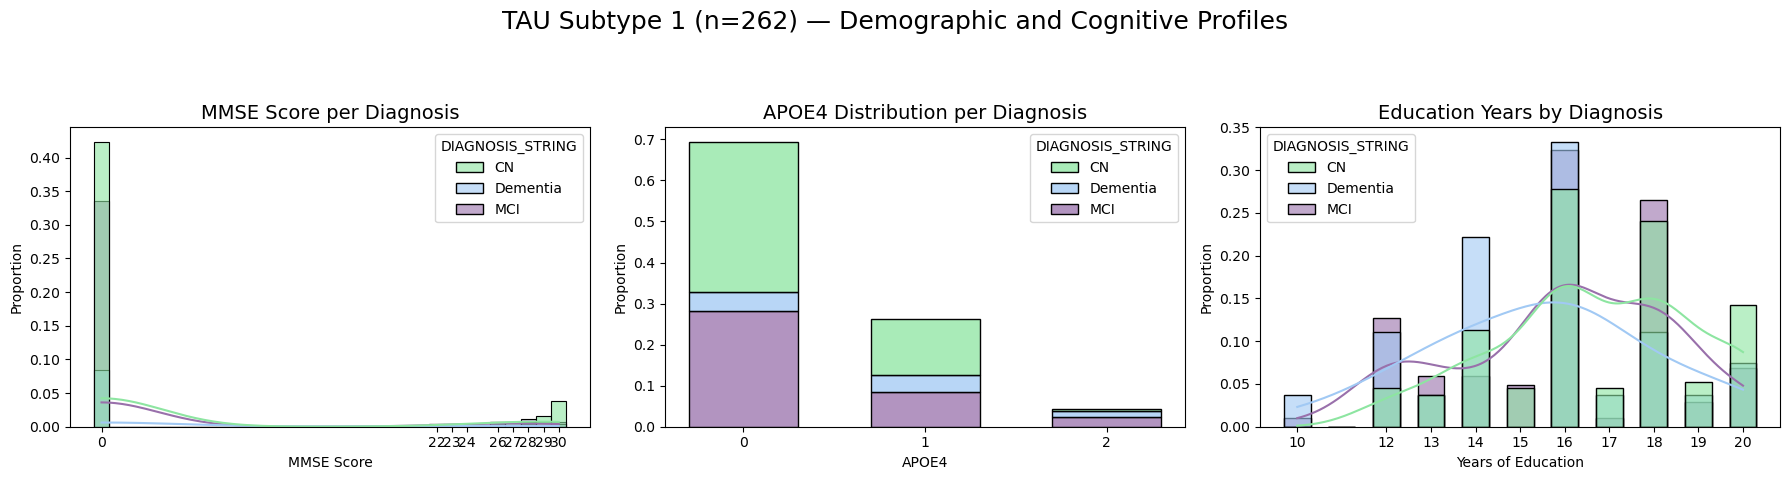

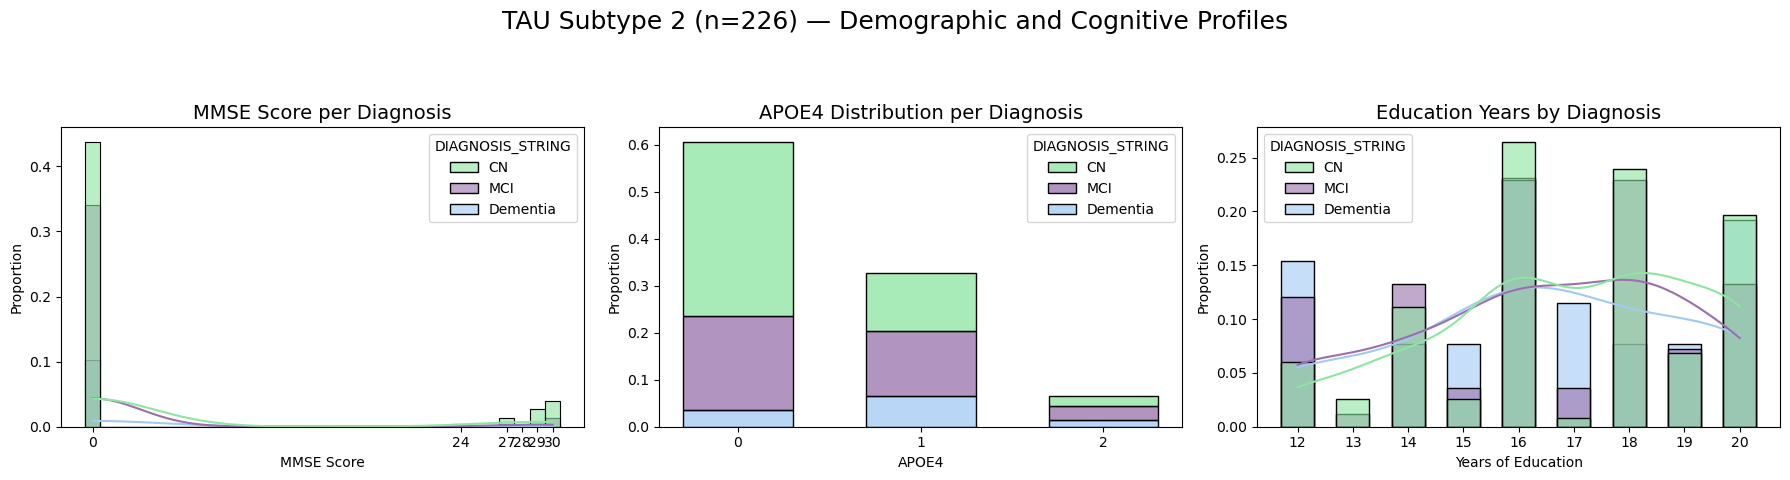

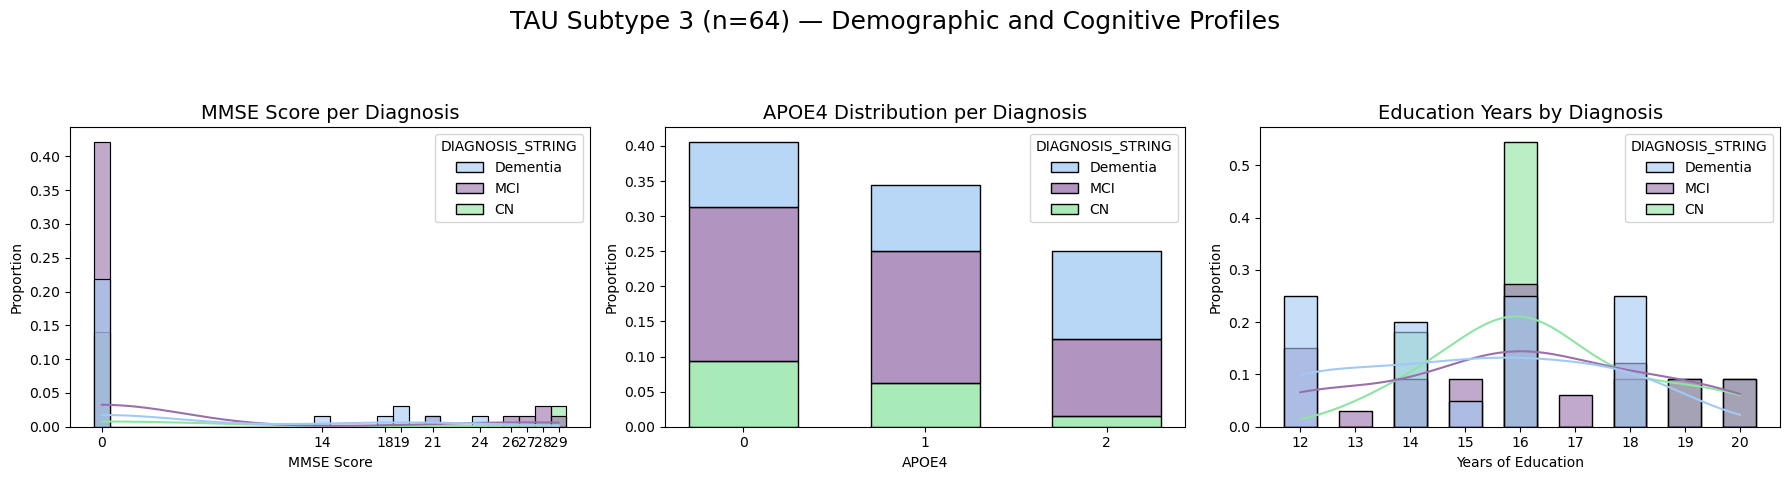

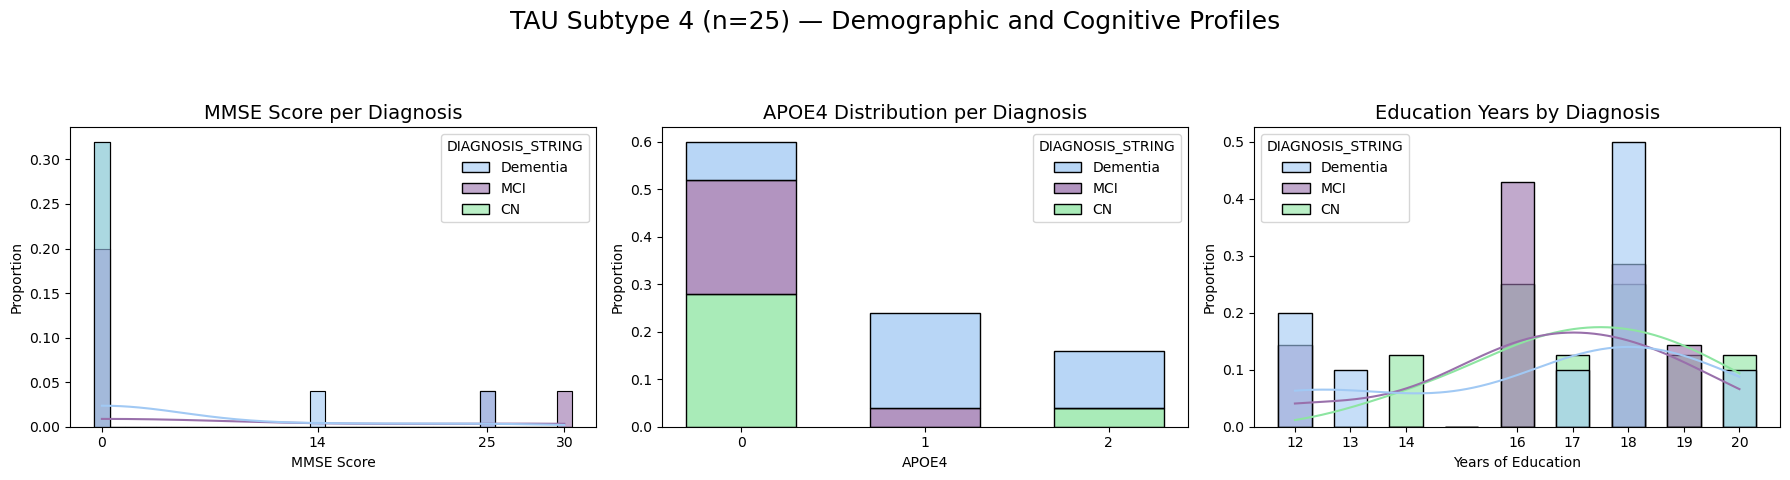


======= Plotting for MRI subtypes =======



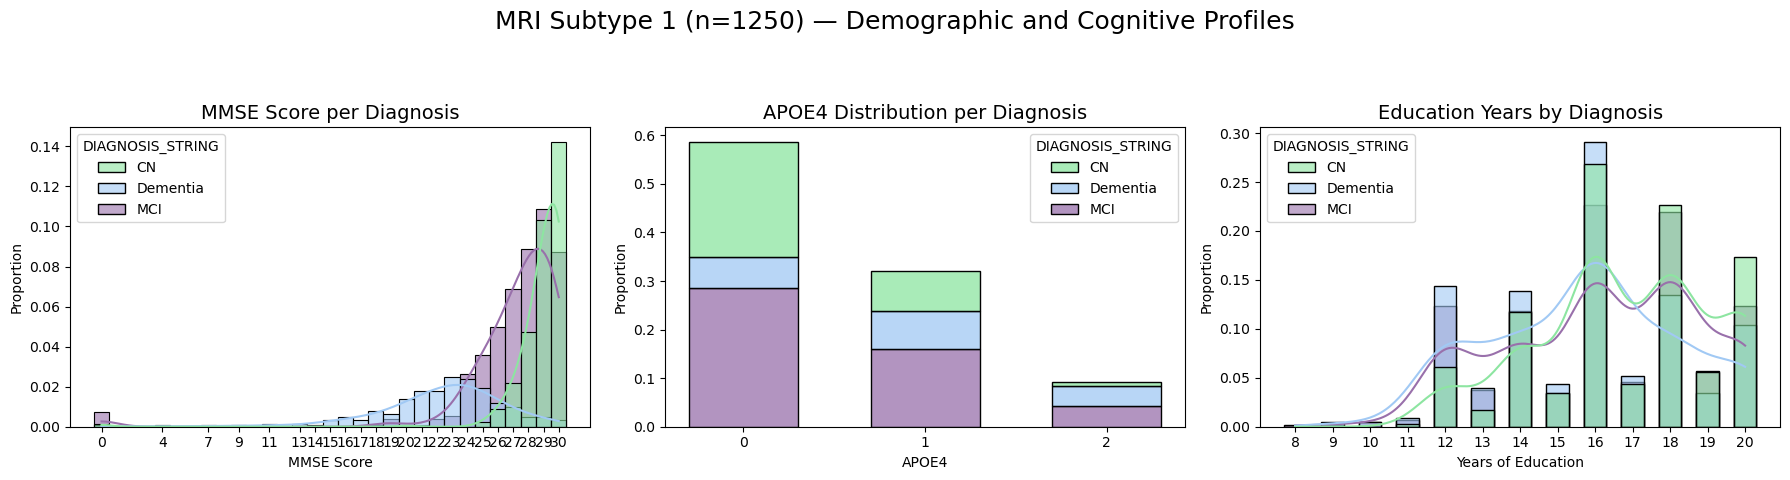

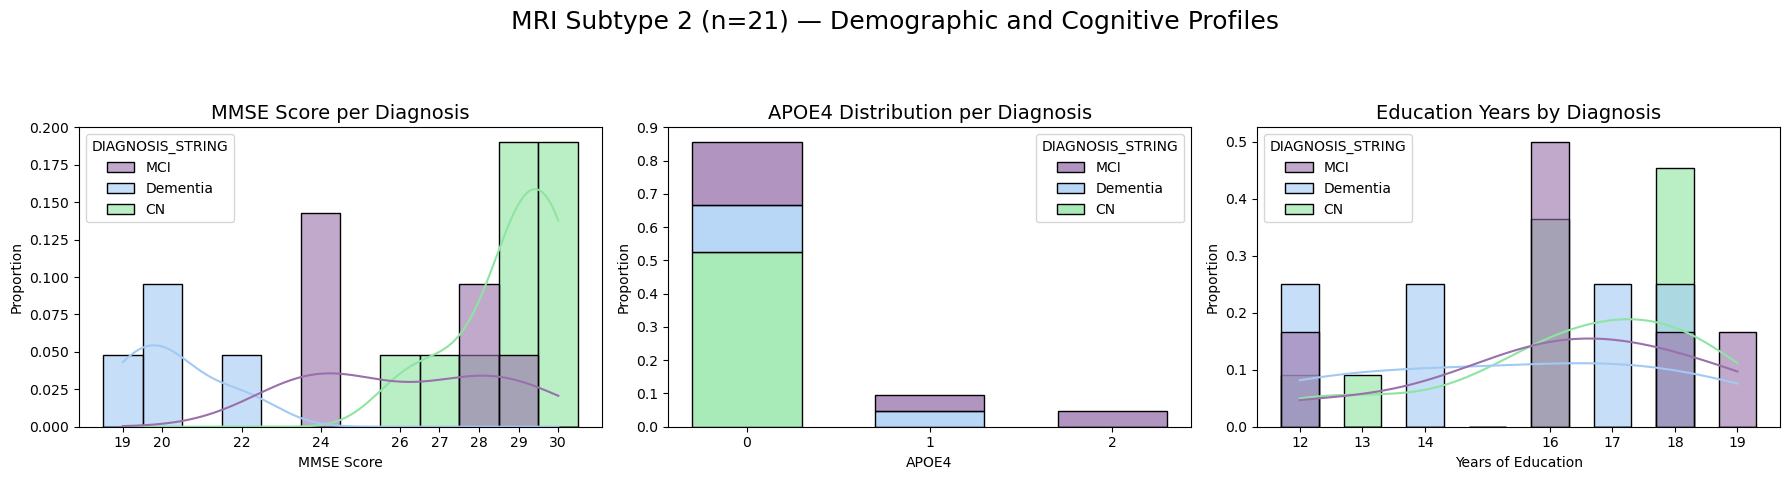

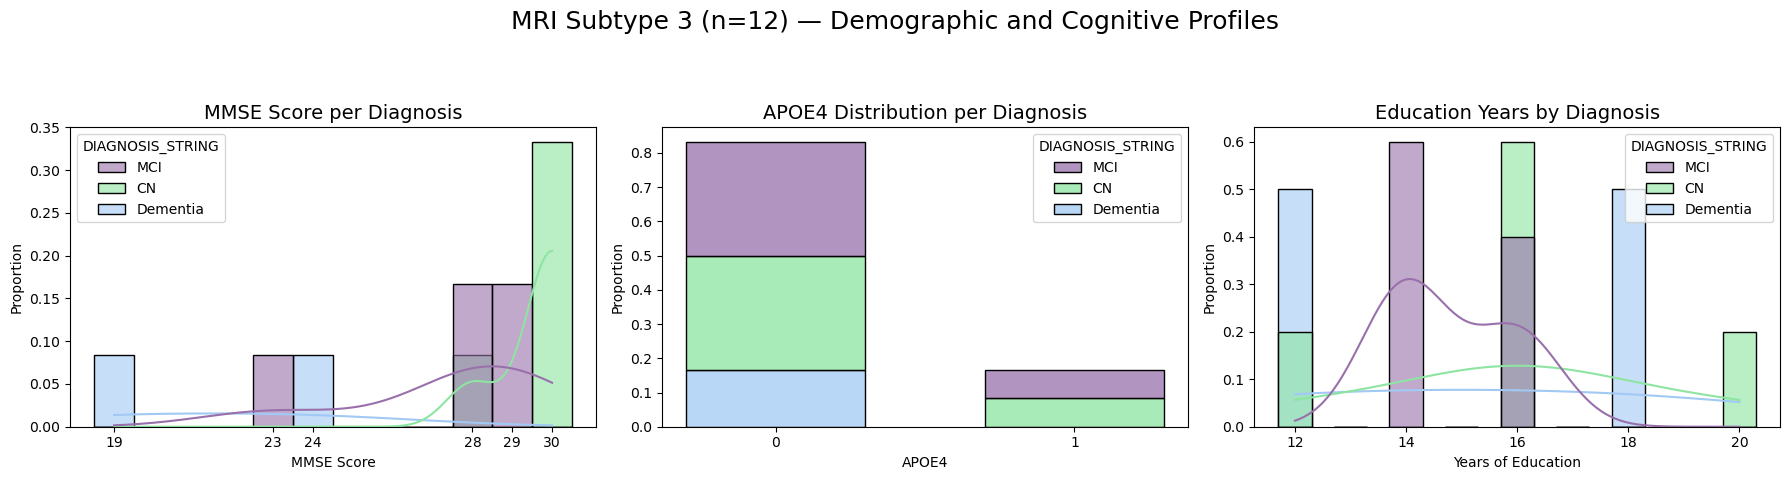

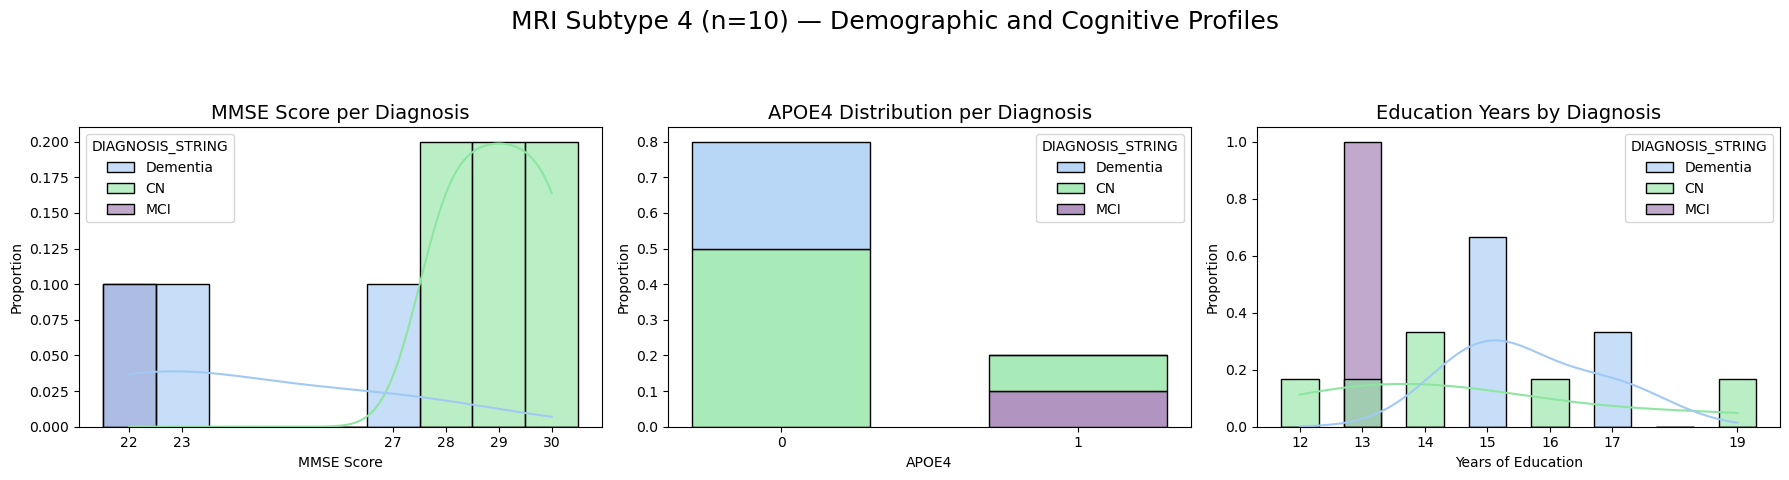

In [14]:
# Define modality datasets
modalities = {
    "AB": ('ml_subtype_AB', zdata_ab),
    "TAU": ('ml_subtype_TAU', zdata_tau),
    "MRI": ('ml_subtype_MRI', zdata_mri)
}

diagnosis_palette = {
    'CN': '#8de5a1',       
    'MCI': '#9970AB',      
    'Dementia': '#a1c9f4'  
}

for modality, (subtype_col, df) in modalities.items():
    print(f"\n======= Plotting for {modality} subtypes =======\n")

    for subtype in sorted(df[subtype_col].dropna().unique()):
        subset_df = df[df[subtype_col] == subtype]

        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f"{modality} Subtype {int(subtype)+1} (n={len(subset_df)}) — Demographic and Cognitive Profiles", fontsize=18)
        plt.subplots_adjust(wspace=0.3)

        # MMSE
        sns.histplot(data=subset_df, x=mmse_score, hue=dx, kde=True, palette=diagnosis_palette, multiple="layer",
                     alpha=0.6, ax=axs[0], stat="probability", discrete=True)
        axs[0].set_title("MMSE Score per Diagnosis", fontsize=14)
        axs[0].set_xlabel("MMSE Score")
        axs[0].set_ylabel("Proportion")
        axs[0].set_xticks(sorted(subset_df[mmse_score].dropna().unique()))

        # APOE4
        sns.histplot(data=subset_df, x=apoe4, hue=dx, multiple="stack", palette=diagnosis_palette,
                     ax=axs[1], stat="probability", discrete=True, shrink=0.6)
        axs[1].set_title("APOE4 Distribution per Diagnosis", fontsize=14)
        axs[1].set_xlabel("APOE4")
        axs[1].set_ylabel("Proportion")
        axs[1].set_xticks(sorted(subset_df[apoe4].dropna().unique()))

        # Education
        sns.histplot(data=subset_df, x=educ, hue=dx, kde=True, multiple="layer", palette=diagnosis_palette,
                     alpha=0.6, ax=axs[2], stat="probability", common_norm=False,
                     discrete=True, shrink=0.6)
        axs[2].set_title("Education Years by Diagnosis", fontsize=14)
        axs[2].set_xlabel("Years of Education")
        axs[2].set_ylabel("Proportion")
        axs[2].set_xticks(sorted(subset_df[educ].dropna().unique()))

        plt.tight_layout(rect=[0, 0.03, 1, 0.90])
        plt.show()



======= Gender Representation in AB Subtypes (Proportional to Overall) =======


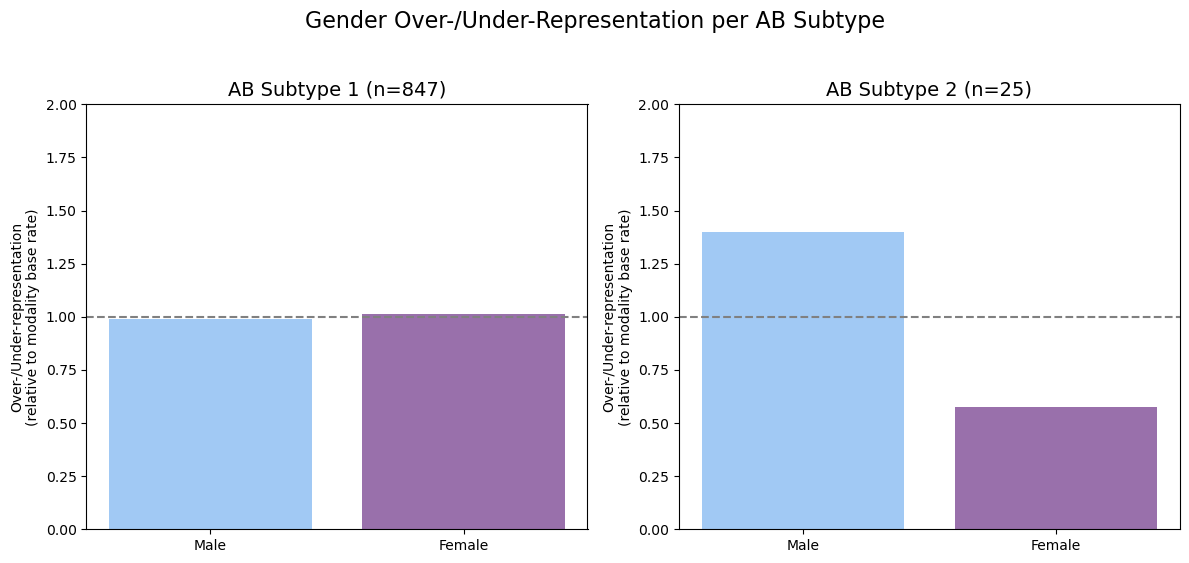


======= Gender Representation in TAU Subtypes (Proportional to Overall) =======


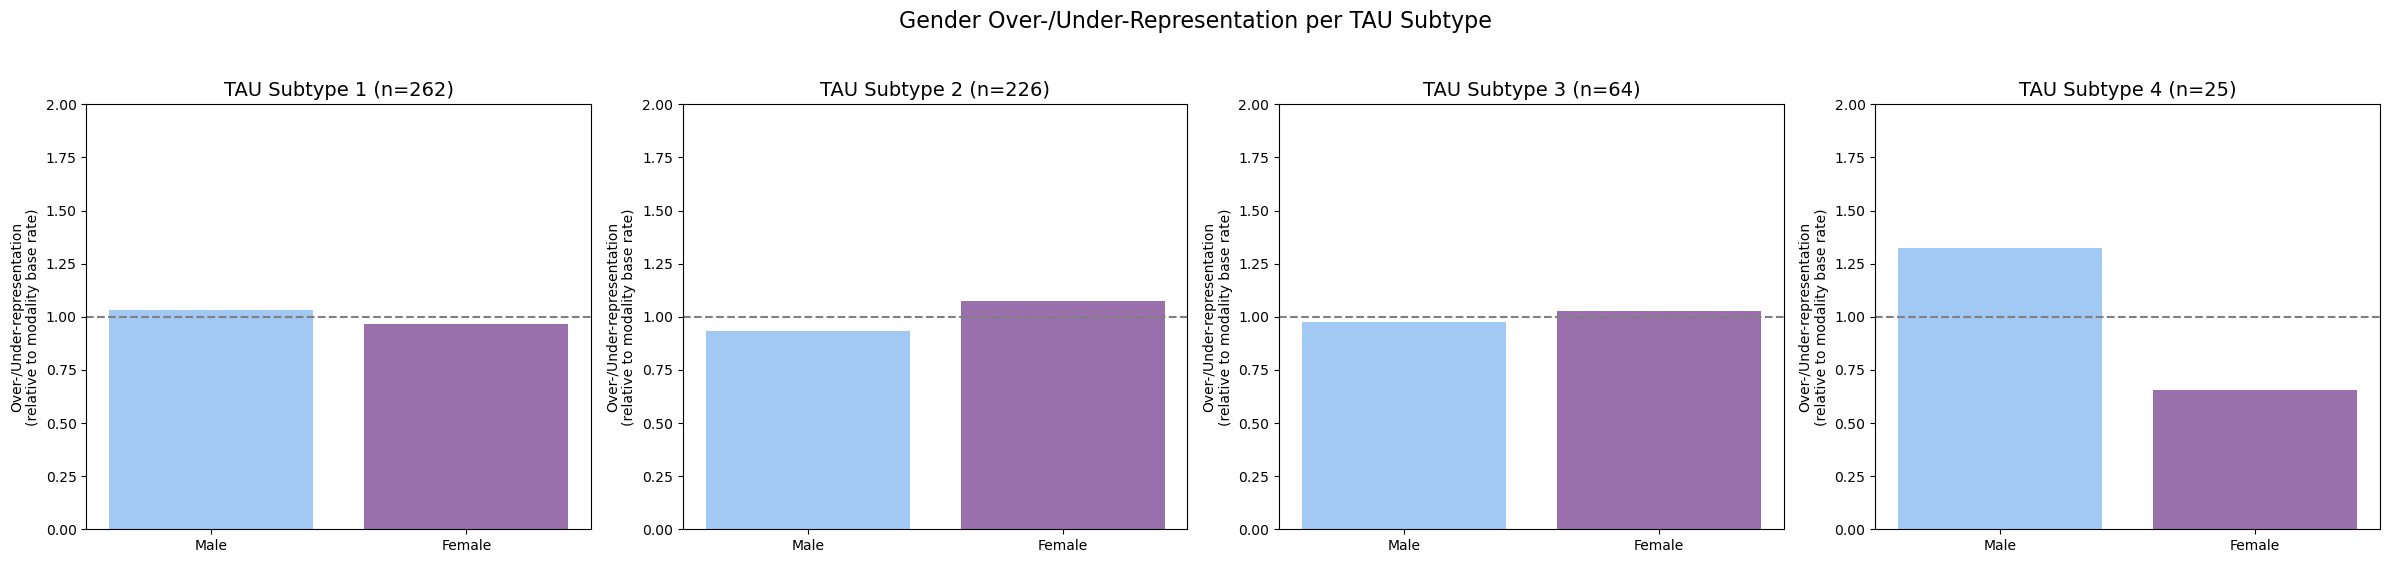


======= Gender Representation in MRI Subtypes (Proportional to Overall) =======


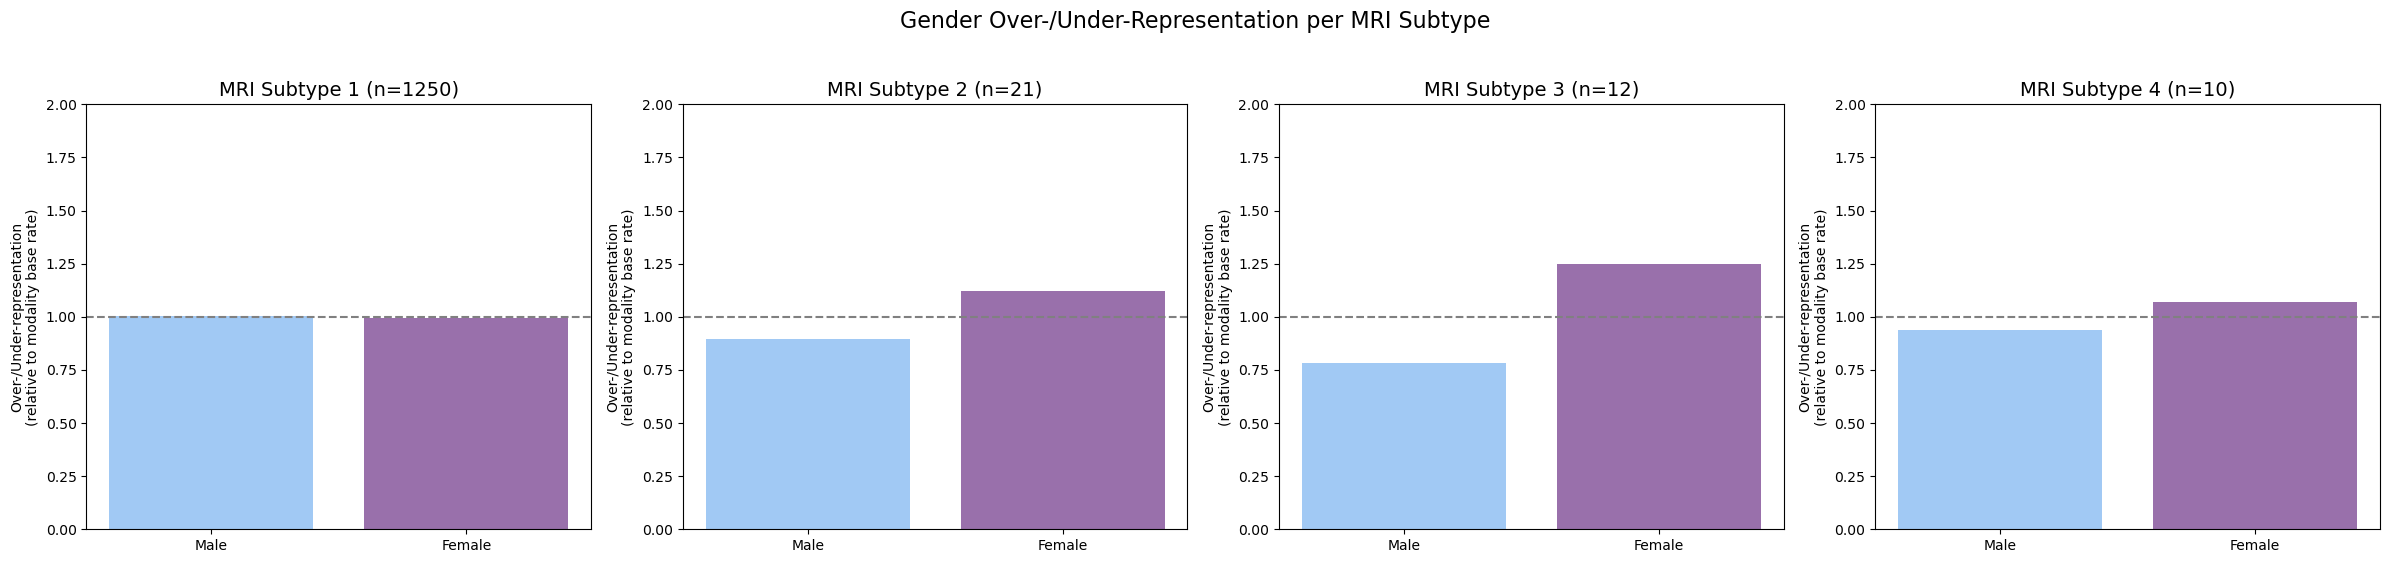

In [15]:
# Gender
# 1.0 = Male, 2.0 = Female
gender_map = {1.0: 'Male', 2.0: 'Female'}
gender_order = ['Male', 'Female']
gender_colors = ['#a1c9f4', '#9970AB']  

for modality, (subtype_col, df) in modalities.items():
    print(f"\n======= Gender Representation in {modality} Subtypes (Proportional to Overall) =======")
    
    df = df.copy()
    df['GenderStr'] = df[gender].map(gender_map)
    
    # Overall gender base rates in this modality
    overall_counts = df['GenderStr'].value_counts()
    overall_total = overall_counts.sum()
    overall_props = overall_counts / overall_total  # Base rate of Male/Female

    unique_subtypes = sorted(df[subtype_col].dropna().unique())
    n_subtypes = len(unique_subtypes)
    fig, axs = plt.subplots(1, n_subtypes, figsize=(6 * n_subtypes, 6))
    if n_subtypes == 1:
        axs = [axs]

    for i, subtype in enumerate(unique_subtypes):
        subset_df = df[df[subtype_col] == subtype]
        gender_counts = subset_df['GenderStr'].value_counts()
        total = gender_counts.sum()

        # Proportion relative to overall (normalized)
        normalized_props = (gender_counts / total) / overall_props
        normalized_props = normalized_props.reindex(gender_order).fillna(0)

        # Bar plot — with consistent color and order
        axs[i].bar(gender_order, normalized_props.values, color=gender_colors)
        axs[i].set_ylim(0, 2)
        axs[i].axhline(1.0, color='gray', linestyle='--')
        axs[i].set_title(f"{modality} Subtype {int(subtype)+1} (n={total})", fontsize=14)
        axs[i].set_ylabel("Over-/Under-representation\n(relative to modality base rate)")
    
    plt.suptitle(f"Gender Over-/Under-Representation per {modality} Subtype", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


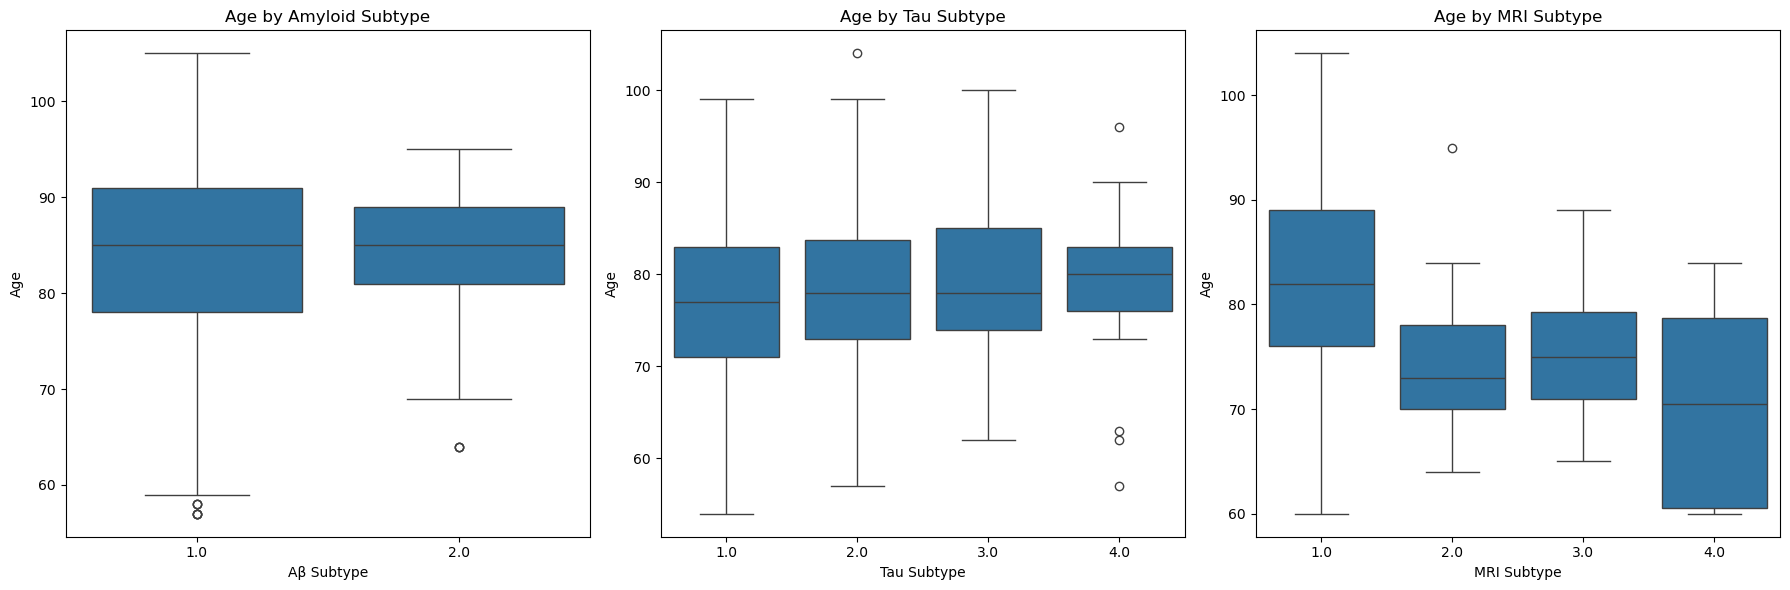


Aβ Subtype Age Summary:
                         n  median   mean   std   q25   q75
ml_subtype_AB_1based                                      
1.0                   847    85.0  84.46  9.38  78.0  91.0
2.0                    25    85.0  82.96  9.35  81.0  89.0

Tau Subtype Age Summary:
                          n  median   mean   std   q25    q75
ml_subtype_TAU_1based                                       
1.0                    262    77.0  76.97  9.17  71.0  83.00
2.0                    226    78.0  78.27  8.27  73.0  83.75
3.0                     64    78.0  79.20  7.92  74.0  85.00
4.0                     25    80.0  79.04  8.89  76.0  83.00

MRI Subtype Age Summary:
                           n  median   mean   std   q25    q75
ml_subtype_MRI_1based                                        
1.0                    1250    82.0  82.11  9.28  76.0  89.00
2.0                      21    73.0  74.33  7.13  70.0  78.00
3.0                      12    75.0  75.00  6.61  71.0  79.25
4.0     

In [16]:
# Filter: Age > 0 for all datasets
zdata_ab_clean = zdata_ab[zdata_ab[age] > 0].copy()
zdata_tau_clean = zdata_tau[zdata_tau[age] > 0].copy()
zdata_mri_clean = zdata_mri[zdata_mri[age] > 0].copy()
zdata_ab_clean['ml_subtype_AB_1based'] = zdata_ab_clean['ml_subtype_AB'] + 1
zdata_tau_clean['ml_subtype_TAU_1based'] = zdata_tau_clean['ml_subtype_TAU'] + 1
zdata_mri_clean['ml_subtype_MRI_1based'] = zdata_mri_clean['ml_subtype_MRI'] + 1


# Set up the figure
plt.figure(figsize=(18, 6))

# Aβ
plt.subplot(1, 3, 1)
sns.boxplot(data=zdata_ab_clean, x='ml_subtype_AB_1based', y=age)
plt.title('Age by Amyloid Subtype')
plt.xlabel('Aβ Subtype')
plt.ylabel('Age')

# Tau
plt.subplot(1, 3, 2)
sns.boxplot(data=zdata_tau_clean, x='ml_subtype_TAU_1based', y=age)
plt.title('Age by Tau Subtype')
plt.xlabel('Tau Subtype')
plt.ylabel('Age')

# MRI
plt.subplot(1, 3, 3)
sns.boxplot(data=zdata_mri_clean, x='ml_subtype_MRI_1based', y=age)
plt.title('Age by MRI Subtype')
plt.xlabel('MRI Subtype')
plt.ylabel('Age')

plt.tight_layout()
plt.show()

# Function to compute MMSE summary stats per subtype
def stats(df, subtype_col, var):
    return df.groupby(subtype_col)[var].agg(
        n='count',
        median='median',
        mean='mean',
        std='std',
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75)
    ).round(2)

# Create summary tables
age_ab_summary = stats(zdata_ab_clean.assign(ml_subtype_AB_1based=zdata_ab_clean['ml_subtype_AB'] + 1), 'ml_subtype_AB_1based', age)
age_tau_summary = stats(zdata_tau_clean.assign(ml_subtype_TAU_1based=zdata_tau_clean['ml_subtype_TAU'] + 1), 'ml_subtype_TAU_1based', age)
age_mri_summary = stats(zdata_mri_clean.assign(ml_subtype_MRI_1based=zdata_mri_clean['ml_subtype_MRI'] + 1), 'ml_subtype_MRI_1based', age)


# Print summaries
print("\nAβ Subtype Age Summary:\n", age_ab_summary)
print("\nTau Subtype Age Summary:\n", age_tau_summary)
print("\nMRI Subtype Age Summary:\n", age_mri_summary)


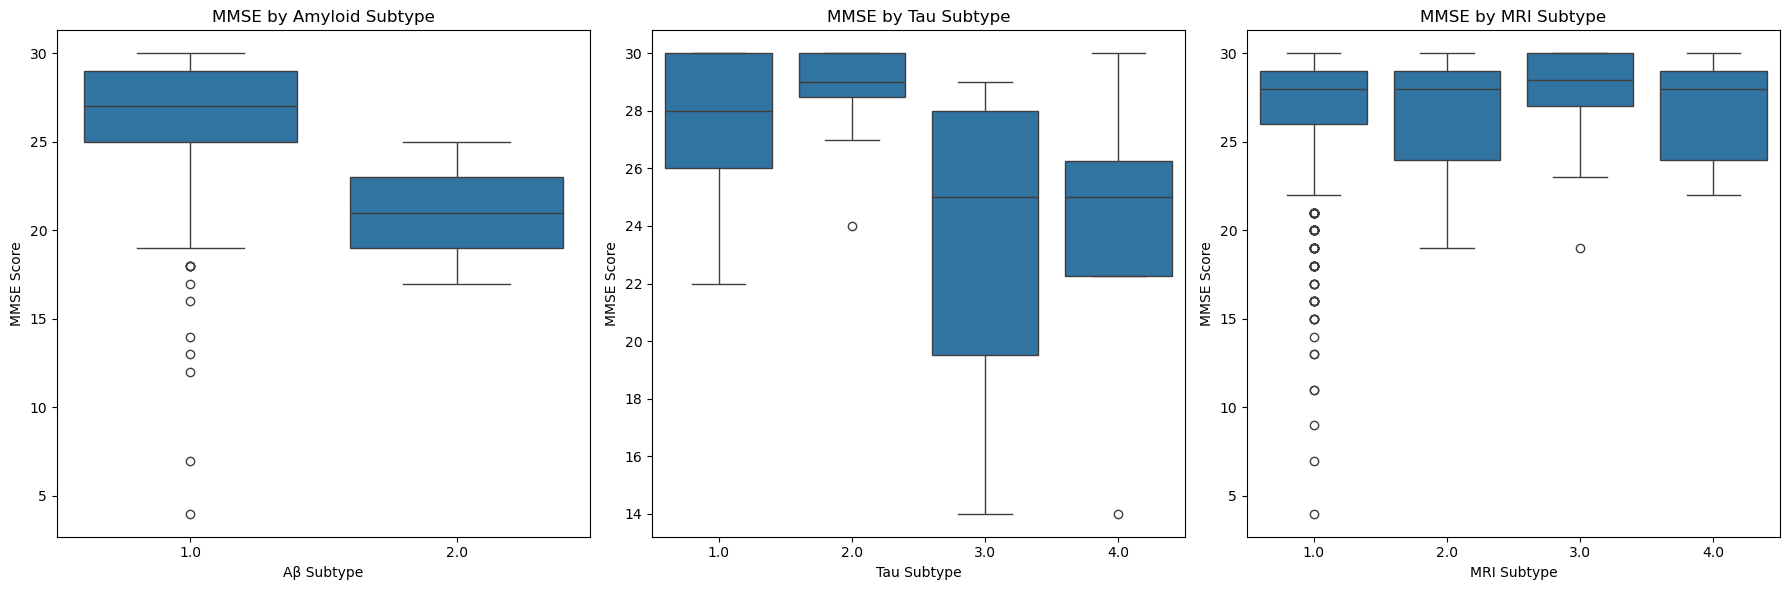


Aβ Subtype MMSE Summary:
                         n  median   mean   std   q25   q75
ml_subtype_AB_1based                                      
1.0                   165    27.0  26.13  4.36  25.0  29.0
2.0                     2    21.0  21.00  5.66  19.0  23.0

Tau Subtype MMSE Summary:
                         n  median   mean   std    q25    q75
ml_subtype_TAU_1based                                       
1.0                    41    28.0  27.61  2.48  26.00  30.00
2.0                    27    29.0  28.85  1.49  28.50  30.00
3.0                    14    25.0  23.71  4.98  19.50  28.00
4.0                     4    25.0  23.50  6.76  22.25  26.25

MRI Subtype MMSE Summary:
                           n  median   mean   std   q25   q75
ml_subtype_MRI_1based                                       
1.0                    1238    28.0  27.10  3.31  26.0  29.0
2.0                      21    28.0  26.43  3.65  24.0  29.0
3.0                      12    28.5  27.33  3.50  27.0  30.0
4.0       

In [17]:
# Filter: MMSE > 0 for all datasets
zdata_ab_clean = zdata_ab[zdata_ab[mmse_score] > 0].copy()
zdata_tau_clean = zdata_tau[zdata_tau[mmse_score] > 0].copy()
zdata_mri_clean = zdata_mri[zdata_mri[mmse_score] > 0].copy()

zdata_ab_clean['ml_subtype_AB_1based'] = zdata_ab_clean['ml_subtype_AB'] + 1
zdata_tau_clean['ml_subtype_TAU_1based'] = zdata_tau_clean['ml_subtype_TAU'] + 1
zdata_mri_clean['ml_subtype_MRI_1based'] = zdata_mri_clean['ml_subtype_MRI'] + 1


# Set up the figure
plt.figure(figsize=(18, 6))

# Aβ
plt.subplot(1, 3, 1)
sns.boxplot(data=zdata_ab_clean, x='ml_subtype_AB_1based', y=mmse_score)
plt.title('MMSE by Amyloid Subtype')
plt.xlabel('Aβ Subtype')
plt.ylabel('MMSE Score')

# Tau
plt.subplot(1, 3, 2)
sns.boxplot(data=zdata_tau_clean, x='ml_subtype_TAU_1based', y=mmse_score)
plt.title('MMSE by Tau Subtype')
plt.xlabel('Tau Subtype')
plt.ylabel('MMSE Score')

# MRI
plt.subplot(1, 3, 3)
sns.boxplot(data=zdata_mri_clean, x='ml_subtype_MRI_1based', y=mmse_score)
plt.title('MMSE by MRI Subtype')
plt.xlabel('MRI Subtype')
plt.ylabel('MMSE Score')

plt.tight_layout()
plt.show()

# Create summary tables
mmse_ab_summary = stats(zdata_ab_clean.assign(ml_subtype_AB_1based=zdata_ab_clean['ml_subtype_AB'] + 1), 'ml_subtype_AB_1based', mmse_score)
mmse_tau_summary = stats(zdata_tau_clean.assign(ml_subtype_TAU_1based=zdata_tau_clean['ml_subtype_TAU'] + 1), 'ml_subtype_TAU_1based', mmse_score)
mmse_mri_summary = stats(zdata_mri_clean.assign(ml_subtype_MRI_1based=zdata_mri_clean['ml_subtype_MRI'] + 1), 'ml_subtype_MRI_1based', mmse_score)



# Print summaries
print("\nAβ Subtype MMSE Summary:\n", mmse_ab_summary)
print("\nTau Subtype MMSE Summary:\n", mmse_tau_summary)
print("\nMRI Subtype MMSE Summary:\n", mmse_mri_summary)


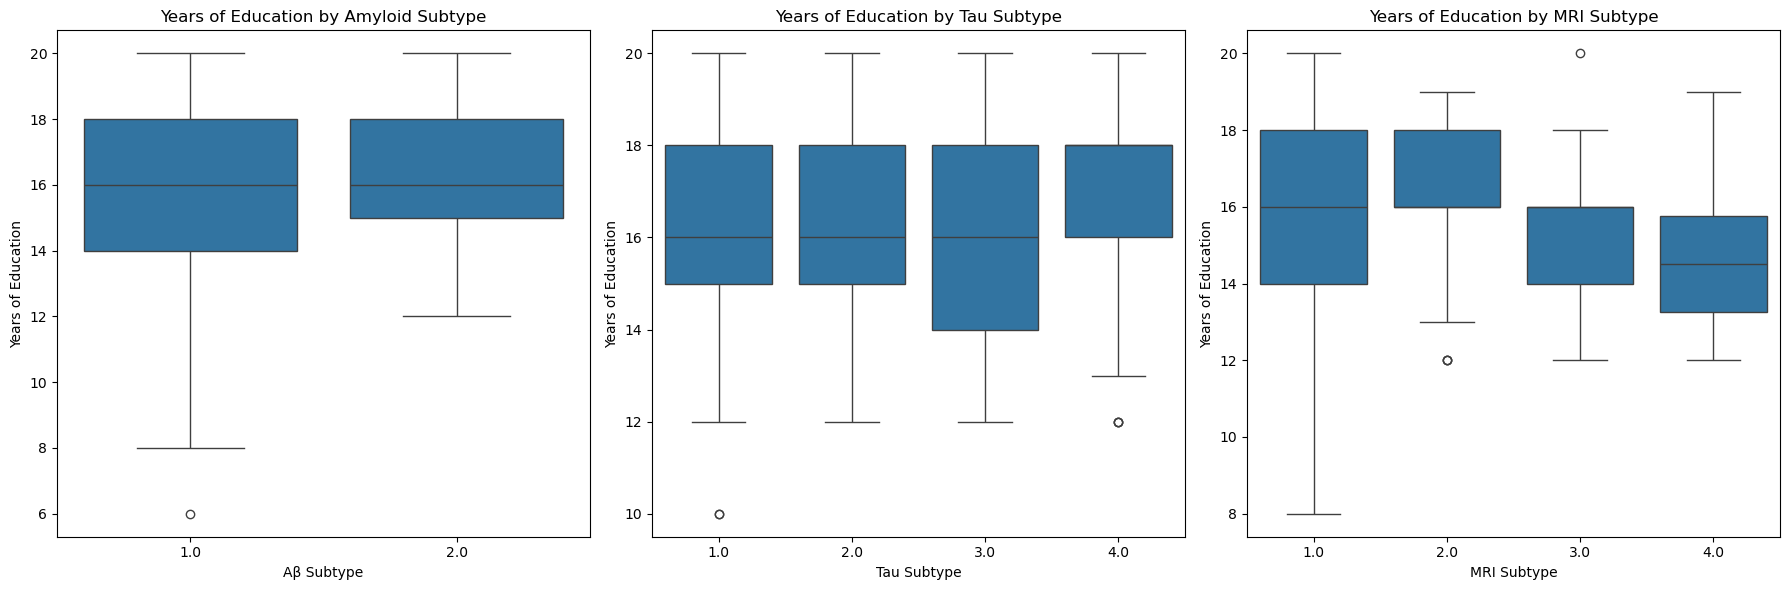


Aβ Subtype Years of Education Summary:
                         n  median   mean   std   q25   q75
ml_subtype_AB_1based                                      
1.0                   847    16.0  16.11  2.66  14.0  18.0
2.0                    25    16.0  16.32  2.70  15.0  18.0

Tau Subtype Years of Education Summary:
                          n  median   mean   std   q25   q75
ml_subtype_TAU_1based                                      
1.0                    262    16.0  16.29  2.34  15.0  18.0
2.0                    226    16.0  16.68  2.45  15.0  18.0
3.0                     64    16.0  15.77  2.35  14.0  18.0
4.0                     25    18.0  16.68  2.39  16.0  18.0

MRI Subtype Years of Education Summary:
                           n  median   mean   std    q25    q75
ml_subtype_MRI_1based                                         
1.0                    1250    16.0  16.30  2.52  14.00  18.00
2.0                      21    16.0  16.05  2.22  16.00  18.00
3.0                      12

In [18]:
# Filter: age at education  > 0 for all datasets
zdata_ab_clean = zdata_ab[zdata_ab[educ] > 0].copy()
zdata_tau_clean = zdata_tau[zdata_tau[educ] > 0].copy()
zdata_mri_clean = zdata_mri[zdata_mri[educ] > 0].copy()
zdata_ab_clean['ml_subtype_AB_1based'] = zdata_ab_clean['ml_subtype_AB'] + 1
zdata_tau_clean['ml_subtype_TAU_1based'] = zdata_tau_clean['ml_subtype_TAU'] + 1
zdata_mri_clean['ml_subtype_MRI_1based'] = zdata_mri_clean['ml_subtype_MRI'] + 1

# Set up the figure
plt.figure(figsize=(18, 6))

# Aβ
plt.subplot(1, 3, 1)
sns.boxplot(data=zdata_ab_clean, x='ml_subtype_AB_1based', y=educ)
plt.title('Years of Education by Amyloid Subtype')
plt.xlabel('Aβ Subtype')
plt.ylabel('Years of Education')

# Tau
plt.subplot(1, 3, 2)
sns.boxplot(data=zdata_tau_clean, x='ml_subtype_TAU_1based', y=educ)
plt.title('Years of Education by Tau Subtype')
plt.xlabel('Tau Subtype')
plt.ylabel('Years of Education')

# MRI
plt.subplot(1, 3, 3)
sns.boxplot(data=zdata_mri_clean, x='ml_subtype_MRI_1based', y=educ)
plt.title('Years of Education by MRI Subtype')
plt.xlabel('MRI Subtype')
plt.ylabel('Years of Education')

plt.tight_layout()
plt.show()

# Create summary tables
educ_ab_summary = stats(zdata_ab_clean.assign(ml_subtype_AB_1based=zdata_ab_clean['ml_subtype_AB'] + 1), 'ml_subtype_AB_1based', educ)
educ_tau_summary = stats(zdata_tau_clean.assign(ml_subtype_TAU_1based=zdata_tau_clean['ml_subtype_TAU'] + 1), 'ml_subtype_TAU_1based', educ)
educ_mri_summary = stats(zdata_mri_clean.assign(ml_subtype_MRI_1based=zdata_mri_clean['ml_subtype_MRI'] + 1), 'ml_subtype_MRI_1based', educ)


# Print summaries
print("\nAβ Subtype Years of Education Summary:\n", educ_ab_summary)
print("\nTau Subtype Years of Education Summary:\n", educ_tau_summary)
print("\nMRI Subtype Years of Education Summary:\n", educ_mri_summary)


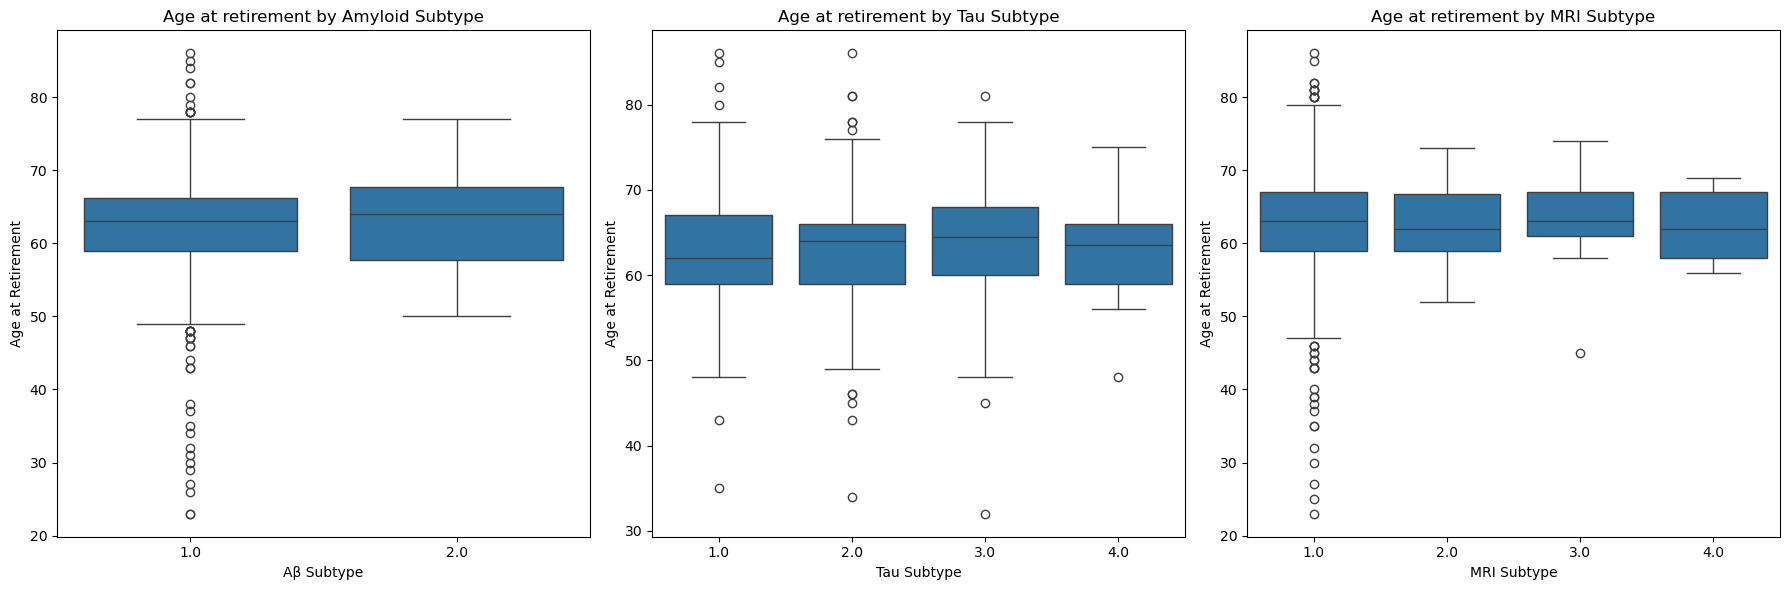


Aβ Subtype Age at Retirement Summary:
                         n  median   mean   std    q25    q75
ml_subtype_AB_1based                                        
1.0                   672    63.0  62.44  7.74  59.00  66.25
2.0                    22    64.0  62.82  7.56  57.75  67.75

Tau Subtype Age at Retirement Summary:
                          n  median   mean   std   q25   q75
ml_subtype_TAU_1based                                      
1.0                    199    62.0  62.93  7.36  59.0  67.0
2.0                    170    64.0  63.13  7.27  59.0  66.0
3.0                     54    64.5  63.89  7.73  60.0  68.0
4.0                     20    63.5  62.55  5.61  59.0  66.0

MRI Subtype Age at Retirement Summary:
                          n  median   mean   std   q25    q75
ml_subtype_MRI_1based                                       
1.0                    970    63.0  62.71  7.55  59.0  67.00
2.0                     18    62.0  62.28  5.32  59.0  66.75
3.0                      9    

In [19]:
# Filter: age at retirement > 0 for all datasets
zdata_ab_clean = zdata_ab[zdata_ab[retire_age] > 0].copy()
zdata_tau_clean = zdata_tau[zdata_tau[retire_age] > 0].copy()
zdata_mri_clean = zdata_mri[zdata_mri[retire_age] > 0].copy()
zdata_ab_clean['ml_subtype_AB_1based'] = zdata_ab_clean['ml_subtype_AB'] + 1
zdata_tau_clean['ml_subtype_TAU_1based'] = zdata_tau_clean['ml_subtype_TAU'] + 1
zdata_mri_clean['ml_subtype_MRI_1based'] = zdata_mri_clean['ml_subtype_MRI'] + 1

# Set up the figure
plt.figure(figsize=(18, 6))

# Aβ
plt.subplot(1, 3, 1)
sns.boxplot(data=zdata_ab_clean, x='ml_subtype_AB_1based', y=retire_age)
plt.title('Age at retirement by Amyloid Subtype')
plt.xlabel('Aβ Subtype')
plt.ylabel('Age at Retirement')

# Tau
plt.subplot(1, 3, 2)
sns.boxplot(data=zdata_tau_clean, x='ml_subtype_TAU_1based', y=retire_age)
plt.title('Age at retirement by Tau Subtype')
plt.xlabel('Tau Subtype')
plt.ylabel('Age at Retirement')

# MRI
plt.subplot(1, 3, 3)
sns.boxplot(data=zdata_mri_clean, x='ml_subtype_MRI_1based', y=retire_age)
plt.title('Age at retirement by MRI Subtype')
plt.xlabel('MRI Subtype')
plt.ylabel('Age at Retirement')

plt.tight_layout()
plt.show()

# Create summary tables
retire_age_ab_summary = stats(zdata_ab_clean.assign(ml_subtype_AB_1based=zdata_ab_clean['ml_subtype_AB'] + 1), 'ml_subtype_AB_1based', retire_age)
retire_age_tau_summary = stats(zdata_tau_clean.assign(ml_subtype_TAU_1based=zdata_tau_clean['ml_subtype_TAU'] + 1), 'ml_subtype_TAU_1based', retire_age)
retire_age_mri_summary = stats(zdata_mri_clean.assign(ml_subtype_MRI_1based=zdata_mri_clean['ml_subtype_MRI'] + 1), 'ml_subtype_MRI_1based', retire_age)

# Print summaries
print("\nAβ Subtype Age at Retirement Summary:\n", retire_age_ab_summary)
print("\nTau Subtype Age at Retirement Summary:\n", retire_age_tau_summary)
print("\nMRI Subtype Age at Retirement Summary:\n", retire_age_mri_summary)


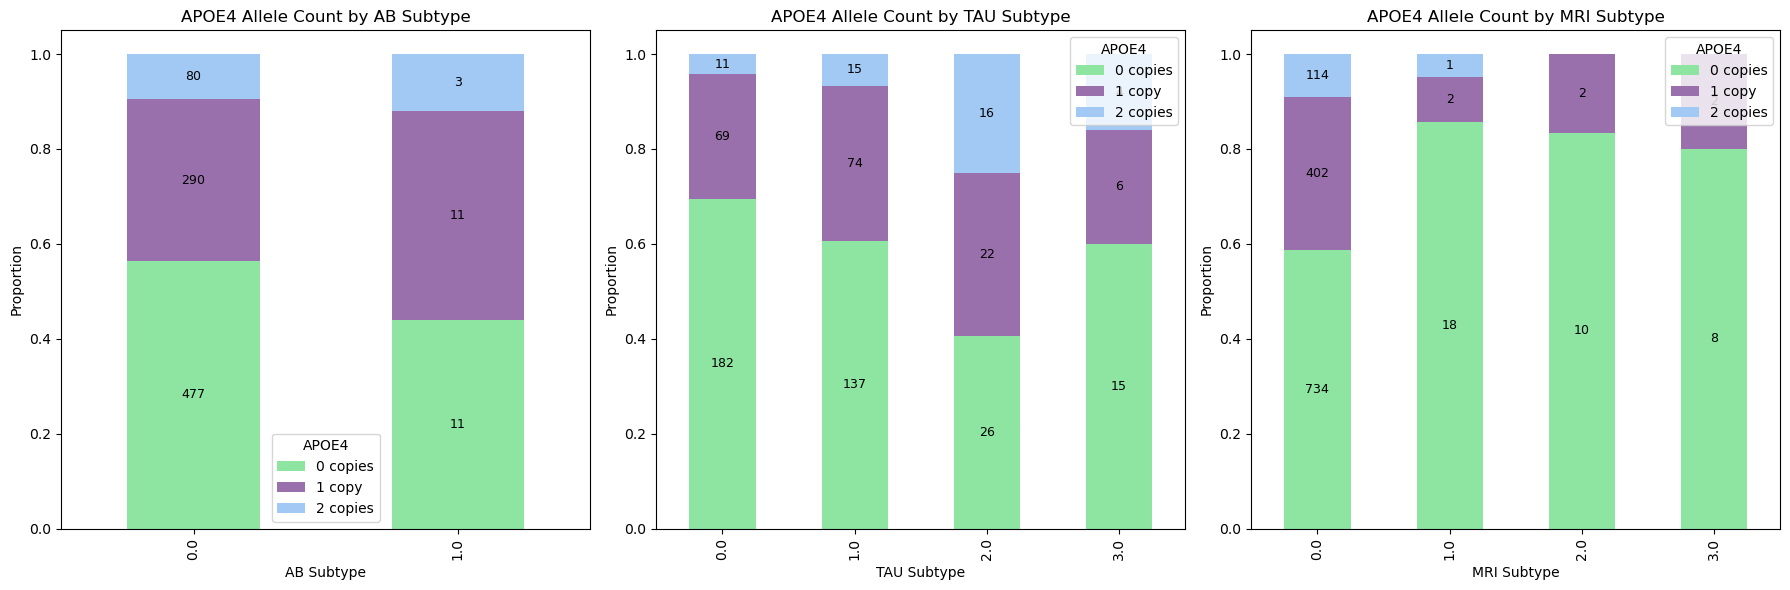


======= APOE4 Representation in AB Subtypes (Proportional to Overall) =======


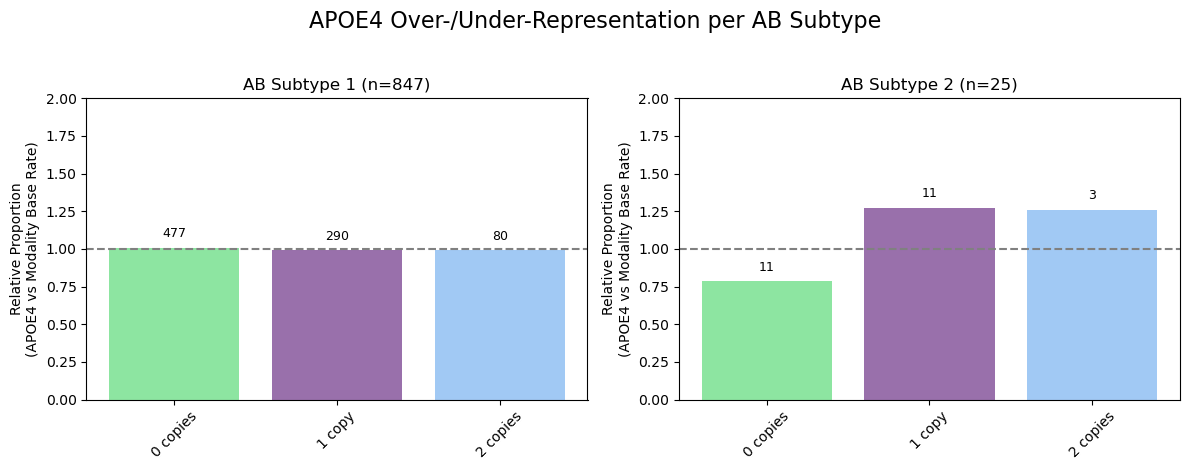


======= APOE4 Representation in TAU Subtypes (Proportional to Overall) =======


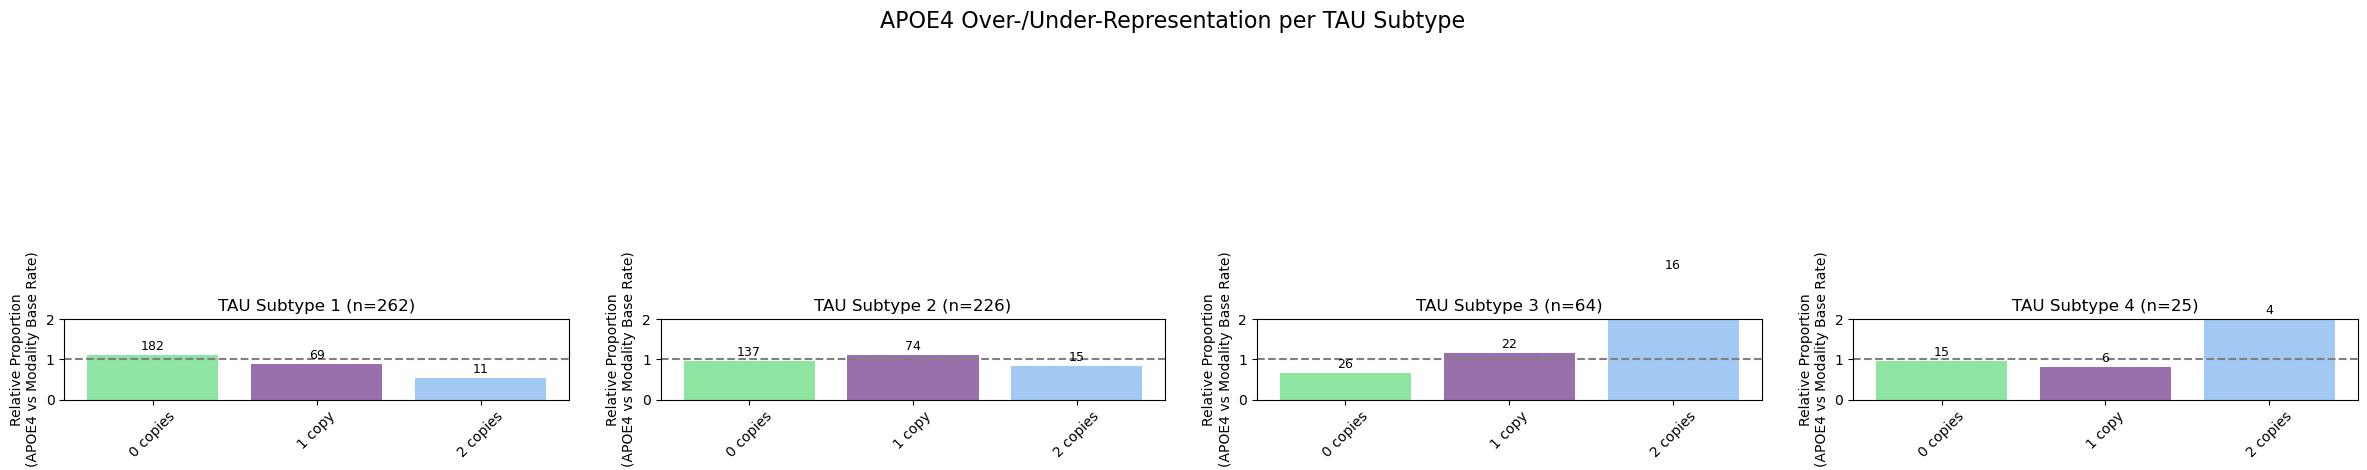


======= APOE4 Representation in MRI Subtypes (Proportional to Overall) =======


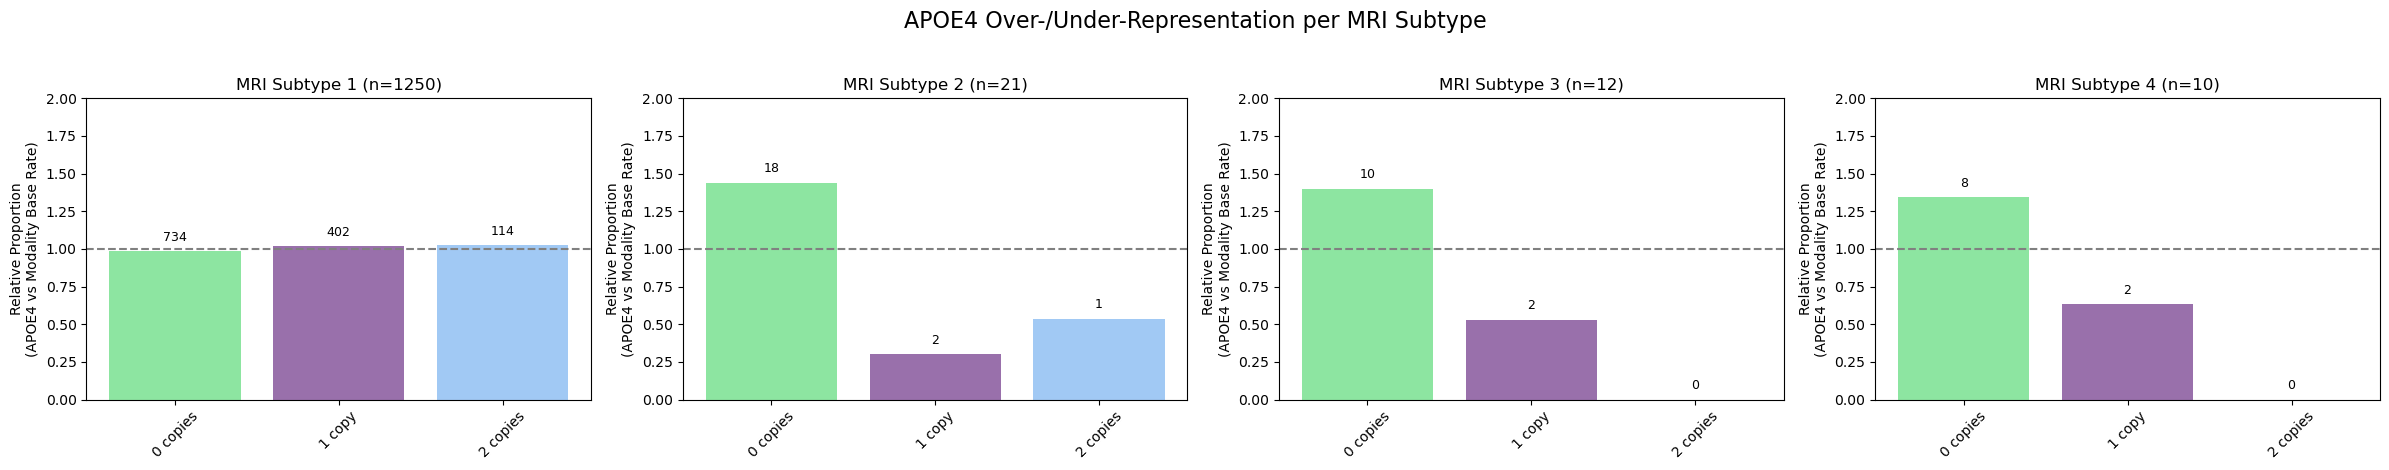


Aβ Subtype APOE4 Summary:
                0.0_count  1.0_count  2.0_count  0.0_prop  1.0_prop  2.0_prop
ml_subtype_AB                                                               
0.0                  477        290         80     0.563     0.342     0.094
1.0                   11         11          3     0.440     0.440     0.120

Tau Subtype APOE4 Summary:
                 0.0_count  1.0_count  2.0_count  0.0_prop  1.0_prop  2.0_prop
ml_subtype_TAU                                                               
0.0                   182         69         11     0.695     0.263     0.042
1.0                   137         74         15     0.606     0.327     0.066
2.0                    26         22         16     0.406     0.344     0.250
3.0                    15          6          4     0.600     0.240     0.160

MRI Subtype APOE4 Summary:
                 0.0_count  1.0_count  2.0_count  0.0_prop  1.0_prop  2.0_prop
ml_subtype_MRI                                              

In [20]:
#APOE4
# Define colors and labels for APOE4 allele count
colors = ['#8de5a1', '#9970AB', '#a1c9f4']  
labels = ['0 copies', '1 copy', '2 copies']


# Plot stacked bar plots with counts on top
plt.figure(figsize=(18, 6))
for i, (modality, (subtype_col, df)) in enumerate(modalities.items(), start=1):
    plt.subplot(1, 3, i)

    # Get proportions and counts
    apoe_counts_prop = df.groupby(subtype_col)[apoe4].value_counts(normalize=True).unstack().fillna(0)
    apoe_counts_prop = apoe_counts_prop.reindex(columns=[0,1,2], fill_value=0)

    apoe_counts_abs = df.groupby(subtype_col)[apoe4].value_counts().unstack().fillna(0)
    apoe_counts_abs = apoe_counts_abs.reindex(columns=[0,1,2], fill_value=0)

    # Plot stacked bar of proportions
    ax = apoe_counts_prop.plot(kind='bar', stacked=True, color=colors, ax=plt.gca())
    plt.title(f'APOE4 Allele Count by {modality} Subtype')
    plt.xlabel(f'{modality} Subtype')
    plt.ylabel('Proportion')
    plt.legend(title='APOE4', labels=labels)

    # Add counts on each bar segment
    for subtype_idx, subtype in enumerate(apoe_counts_prop.index):
        bottom = 0
        for allele_idx, allele in enumerate([0,1,2]):
            height = apoe_counts_prop.loc[subtype, allele]
            count = int(apoe_counts_abs.loc[subtype, allele])
            if height > 0:
                ax.text(subtype_idx, bottom + height/2, str(count), ha='center', va='center', fontsize=9, color='black')
            bottom += height

plt.tight_layout()
plt.show()

# Relative over-/under-representation plots with counts on bars
for modality, (subtype_col, df) in modalities.items():
    print(f"\n======= APOE4 Representation in {modality} Subtypes (Proportional to Overall) =======")

    base_rate = df[apoe4].value_counts(normalize=True)
    base_rate = base_rate.reindex([0,1,2], fill_value=0)

    unique_subtypes = sorted(df[subtype_col].dropna().unique())
    fig, axs = plt.subplots(1, len(unique_subtypes), figsize=(6 * len(unique_subtypes), 5))
    if len(unique_subtypes) == 1:
        axs = [axs]

    for i, subtype in enumerate(unique_subtypes):
        sub_df = df[df[subtype_col] == subtype]
        counts_prop = sub_df[apoe4].value_counts(normalize=True).reindex([0,1,2], fill_value=0)
        counts_abs = sub_df[apoe4].value_counts().reindex([0,1,2], fill_value=0)

        # Normalize relative to base rate
        norm_counts = (counts_prop / base_rate).fillna(0)

        axs[i].bar(labels, norm_counts.values, color=colors)
        axs[i].axhline(1, linestyle='--', color='gray')
        axs[i].set_ylim(0, 2)
        axs[i].set_title(f"{modality} Subtype {int(subtype)+1} (n={len(sub_df)})")
        axs[i].set_ylabel('Relative Proportion\n(APOE4 vs Modality Base Rate)')
        axs[i].tick_params(axis='x', rotation=45)

        # Add count labels above bars
        for x_pos, count in enumerate(counts_abs.values):
            axs[i].text(x_pos, norm_counts.values[x_pos] + 0.05, str(int(count)), ha='center', va='bottom', fontsize=9)

    plt.suptitle(f"APOE4 Over-/Under-Representation per {modality} Subtype", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

def apoe4_proportion_summary(df, subtype_col, apoe_col='APOE4'):
    counts = df.groupby([subtype_col, apoe_col]).size().unstack(fill_value=0)
    proportions = counts.div(counts.sum(axis=1), axis=0).round(3)
    counts.columns = [f"{col}_count" for col in counts.columns]
    proportions.columns = [f"{col}_prop" for col in proportions.columns]
    return pd.concat([counts, proportions], axis=1)

# APOE4 summary for Aβ
apoe4_ab_summary = apoe4_proportion_summary(zdata_ab, 'ml_subtype_AB')
print("\nAβ Subtype APOE4 Summary:\n", apoe4_ab_summary)

# APOE4 summary for Tau
apoe4_tau_summary = apoe4_proportion_summary(zdata_tau, 'ml_subtype_TAU')
print("\nTau Subtype APOE4 Summary:\n", apoe4_tau_summary)

# APOE4 summary for MRI
apoe4_mri_summary = apoe4_proportion_summary(zdata_mri, 'ml_subtype_MRI')
print("\nMRI Subtype APOE4 Summary:\n", apoe4_mri_summary)



====== Asymmetry Across Stages in AB ======
Frontal_lobe_Asymmetry_ab_L | Subtype 0.0 | Slope = 0.000, r = 0.03, p = 0.8983
Frontal_lobe_Asymmetry_ab_L | Subtype 1.0 | Slope = 0.001, r = 0.24, p = 0.5669


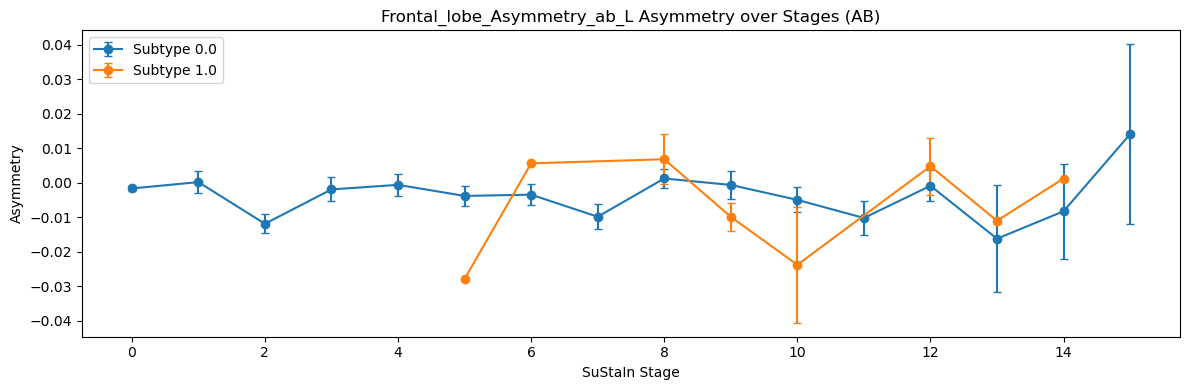

Frontal_lobe_Asymmetry_ab_R | Subtype 0.0 | Slope = -0.000, r = -0.03, p = 0.8983
Frontal_lobe_Asymmetry_ab_R | Subtype 1.0 | Slope = -0.001, r = -0.24, p = 0.5669


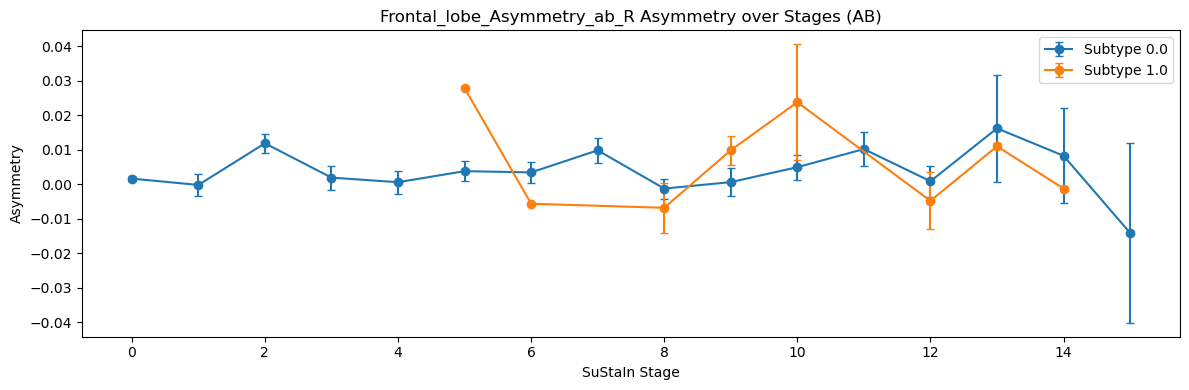

Occipital_lobe_Asymmetry_ab_L | Subtype 0.0 | Slope = -0.000, r = -0.26, p = 0.3294
Occipital_lobe_Asymmetry_ab_L | Subtype 1.0 | Slope = -0.000, r = -0.01, p = 0.9874


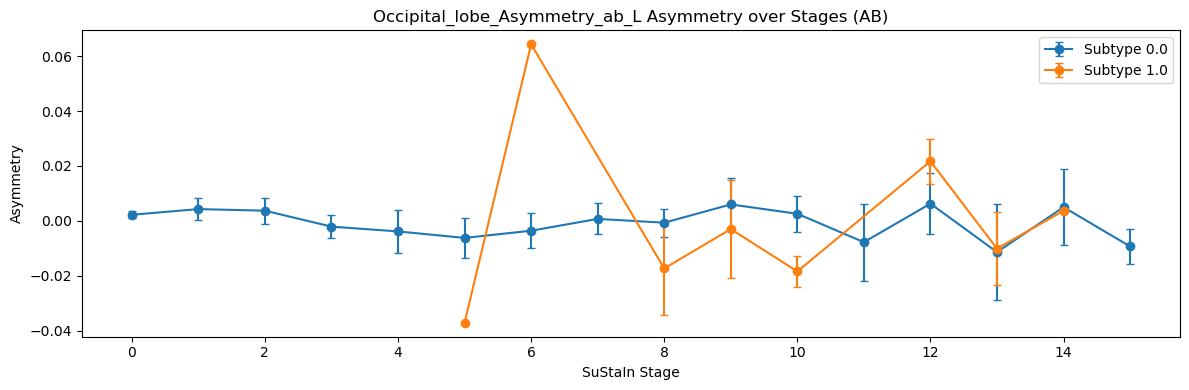

Occipital_lobe_Asymmetry_ab_R | Subtype 0.0 | Slope = 0.000, r = 0.26, p = 0.3294
Occipital_lobe_Asymmetry_ab_R | Subtype 1.0 | Slope = 0.000, r = 0.01, p = 0.9874


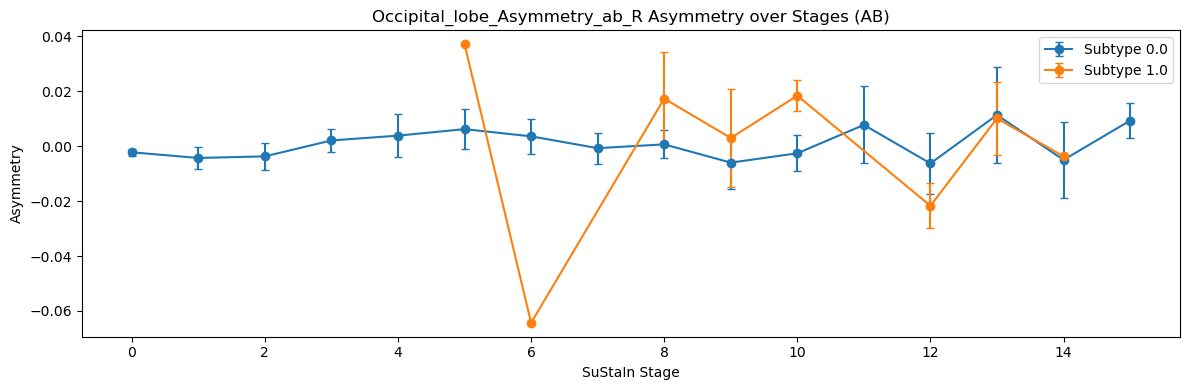

Parietal_lobe_Asymmetry_ab_L | Subtype 0.0 | Slope = 0.001, r = 0.33, p = 0.2074
Parietal_lobe_Asymmetry_ab_L | Subtype 1.0 | Slope = -0.001, r = -0.11, p = 0.7965


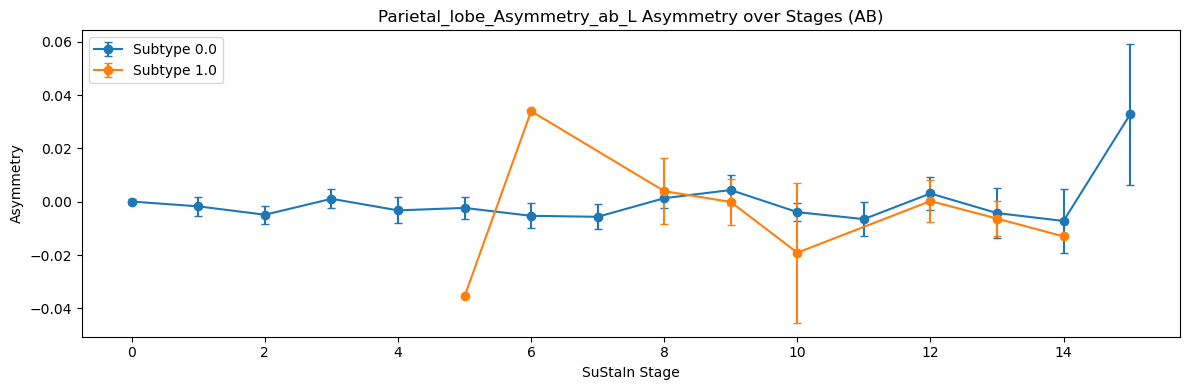

Parietal_lobe_Asymmetry_ab_R | Subtype 0.0 | Slope = -0.001, r = -0.33, p = 0.2074
Parietal_lobe_Asymmetry_ab_R | Subtype 1.0 | Slope = 0.001, r = 0.11, p = 0.7965


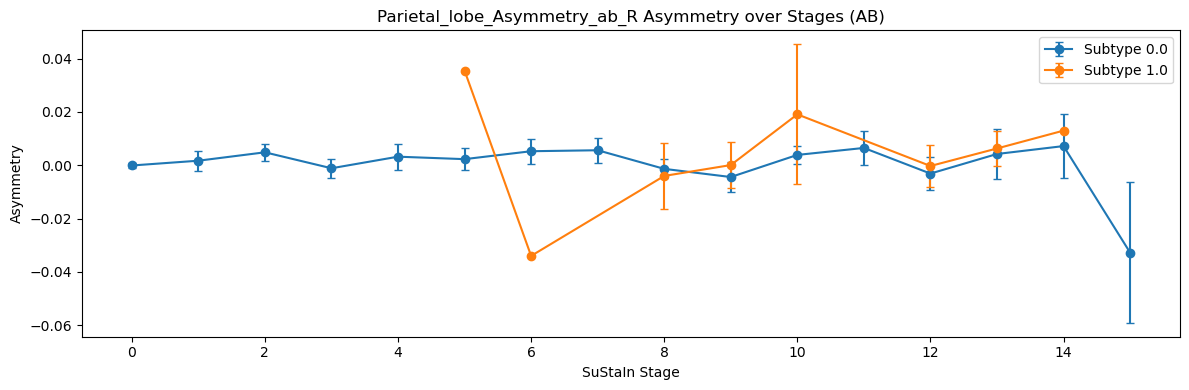

Temporal_lobe_Asymmetry_ab_L | Subtype 0.0 | Slope = 0.001, r = 0.29, p = 0.2753
Temporal_lobe_Asymmetry_ab_L | Subtype 1.0 | Slope = -0.001, r = -0.10, p = 0.8218


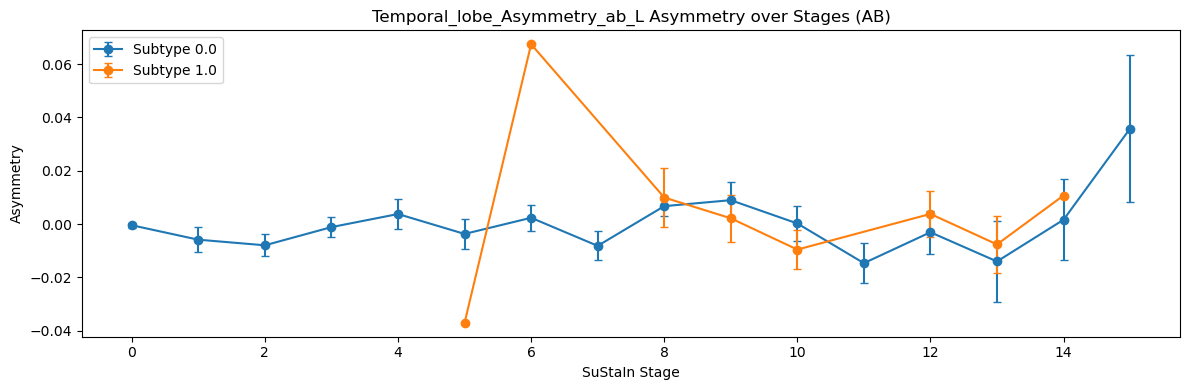

Temporal_lobe_Asymmetry_ab_R | Subtype 0.0 | Slope = -0.001, r = -0.29, p = 0.2753
Temporal_lobe_Asymmetry_ab_R | Subtype 1.0 | Slope = 0.001, r = 0.10, p = 0.8218


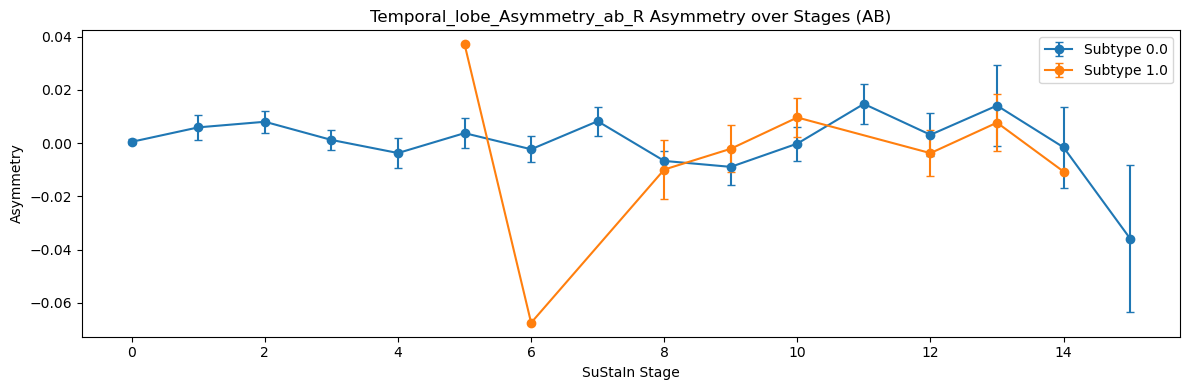

MTL_Asymmetry_ab_L | Subtype 0.0 | Slope = 0.000, r = 0.20, p = 0.4642
MTL_Asymmetry_ab_L | Subtype 1.0 | Slope = -0.001, r = -0.31, p = 0.4573


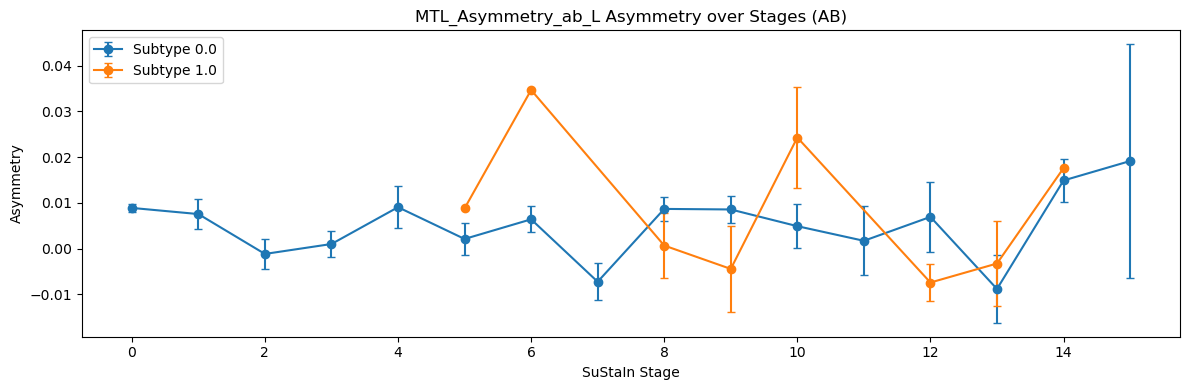

MTL_Asymmetry_ab_R | Subtype 0.0 | Slope = -0.000, r = -0.20, p = 0.4642
MTL_Asymmetry_ab_R | Subtype 1.0 | Slope = 0.001, r = 0.31, p = 0.4573


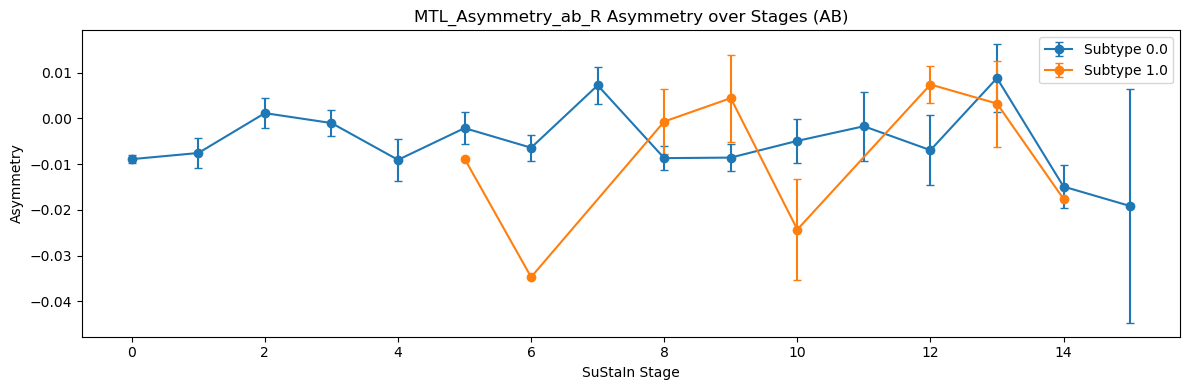


====== Asymmetry Across Stages in TAU ======
Frontal_lobe_Asymmetry_tau_L | Subtype 0.0 | Slope = -0.001, r = -0.11, p = 0.6990
Frontal_lobe_Asymmetry_tau_L | Subtype 1.0 | Slope = -0.001, r = -0.12, p = 0.6954
Frontal_lobe_Asymmetry_tau_L | Subtype 2.0 | Slope = 0.001, r = 0.08, p = 0.7911
Frontal_lobe_Asymmetry_tau_L | Subtype 3.0 | Slope = 0.002, r = 0.15, p = 0.6476


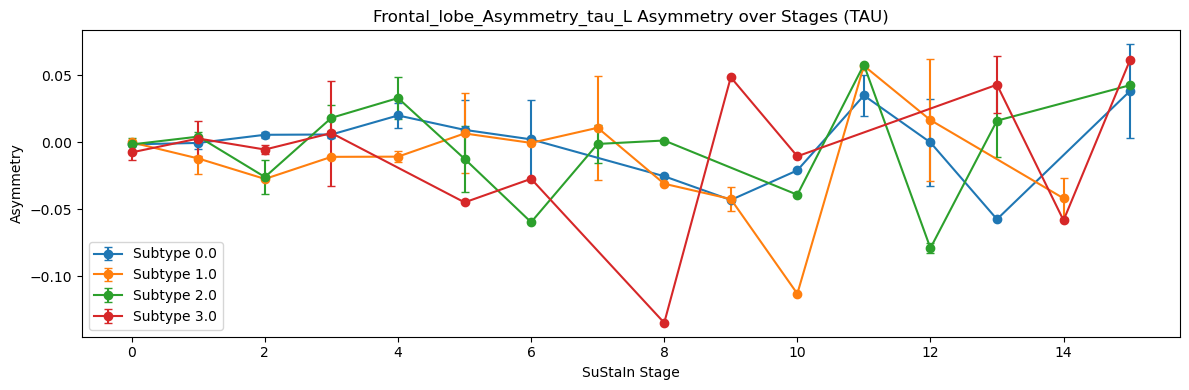

Frontal_lobe_Asymmetry_tau_R | Subtype 0.0 | Slope = 0.001, r = 0.11, p = 0.6990
Frontal_lobe_Asymmetry_tau_R | Subtype 1.0 | Slope = 0.001, r = 0.12, p = 0.6954
Frontal_lobe_Asymmetry_tau_R | Subtype 2.0 | Slope = -0.001, r = -0.08, p = 0.7911
Frontal_lobe_Asymmetry_tau_R | Subtype 3.0 | Slope = -0.002, r = -0.15, p = 0.6476


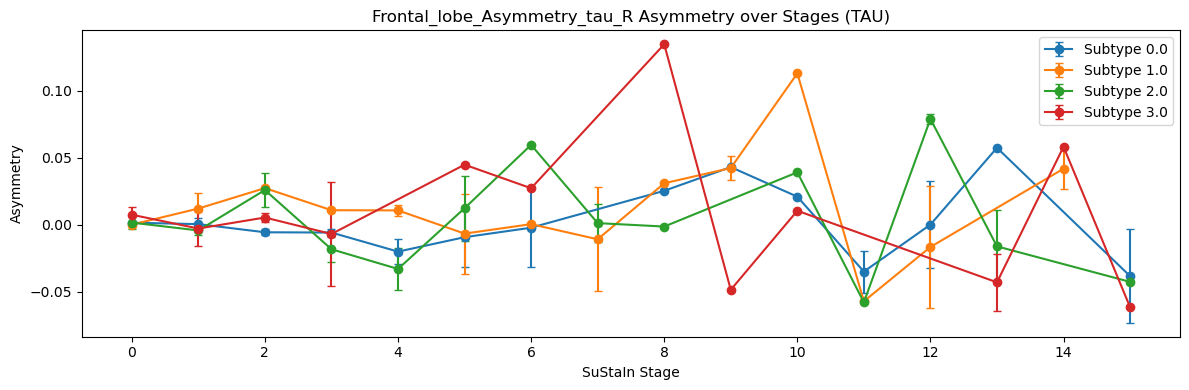

Occipital_lobe_Asymmetry_tau_L | Subtype 0.0 | Slope = -0.003, r = -0.16, p = 0.5738
Occipital_lobe_Asymmetry_tau_L | Subtype 1.0 | Slope = -0.002, r = -0.18, p = 0.5441
Occipital_lobe_Asymmetry_tau_L | Subtype 2.0 | Slope = 0.001, r = 0.08, p = 0.7895
Occipital_lobe_Asymmetry_tau_L | Subtype 3.0 | Slope = 0.001, r = 0.15, p = 0.6362


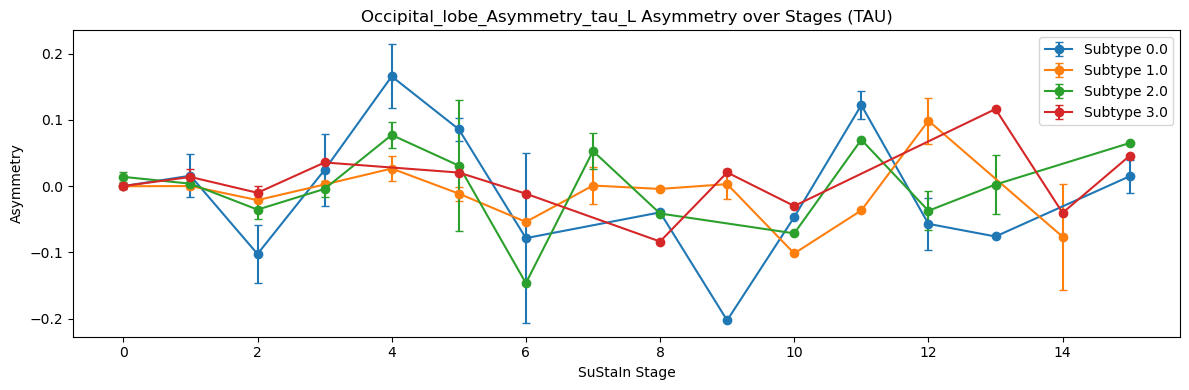

Occipital_lobe_Asymmetry_tau_R | Subtype 0.0 | Slope = 0.003, r = 0.16, p = 0.5738
Occipital_lobe_Asymmetry_tau_R | Subtype 1.0 | Slope = 0.002, r = 0.18, p = 0.5441
Occipital_lobe_Asymmetry_tau_R | Subtype 2.0 | Slope = -0.001, r = -0.08, p = 0.7895
Occipital_lobe_Asymmetry_tau_R | Subtype 3.0 | Slope = -0.001, r = -0.15, p = 0.6362


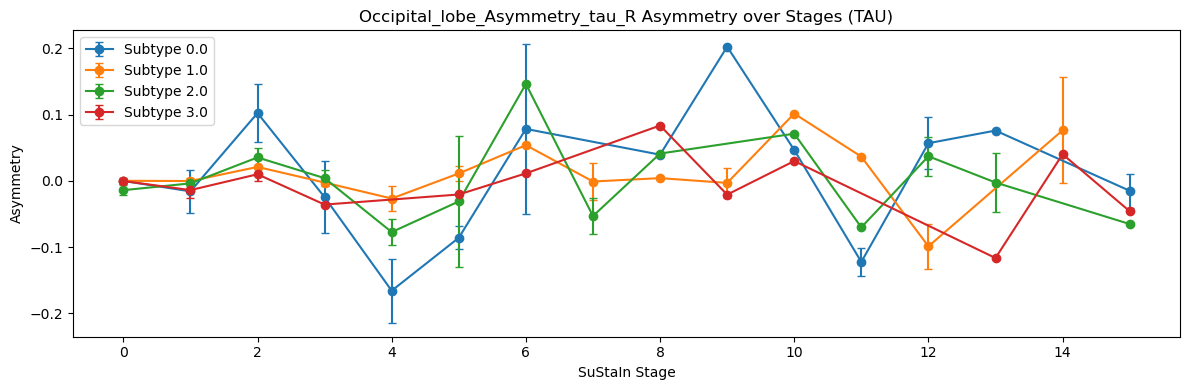

Parietal_lobe_Asymmetry_tau_L | Subtype 0.0 | Slope = -0.001, r = -0.13, p = 0.6633
Parietal_lobe_Asymmetry_tau_L | Subtype 1.0 | Slope = 0.001, r = 0.11, p = 0.7158
Parietal_lobe_Asymmetry_tau_L | Subtype 2.0 | Slope = 0.001, r = 0.09, p = 0.7502
Parietal_lobe_Asymmetry_tau_L | Subtype 3.0 | Slope = 0.001, r = 0.09, p = 0.7731


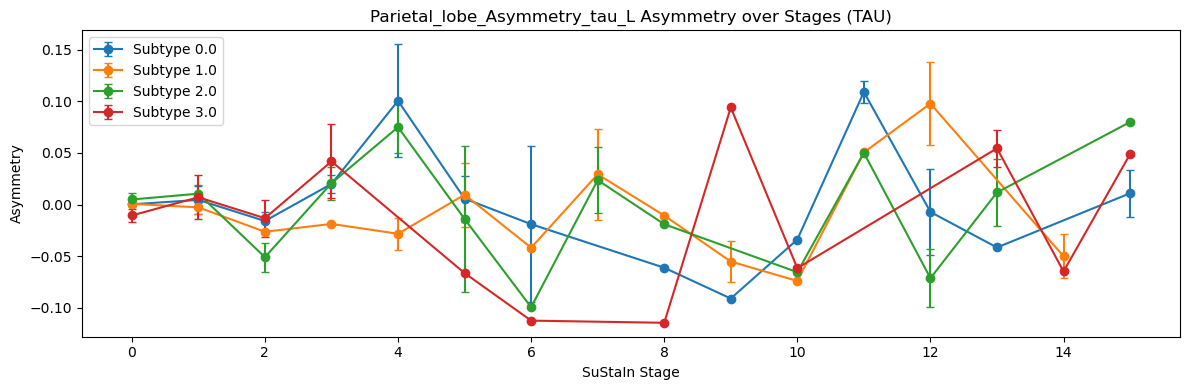

Parietal_lobe_Asymmetry_tau_R | Subtype 0.0 | Slope = 0.001, r = 0.13, p = 0.6633
Parietal_lobe_Asymmetry_tau_R | Subtype 1.0 | Slope = -0.001, r = -0.11, p = 0.7158
Parietal_lobe_Asymmetry_tau_R | Subtype 2.0 | Slope = -0.001, r = -0.09, p = 0.7502
Parietal_lobe_Asymmetry_tau_R | Subtype 3.0 | Slope = -0.001, r = -0.09, p = 0.7731


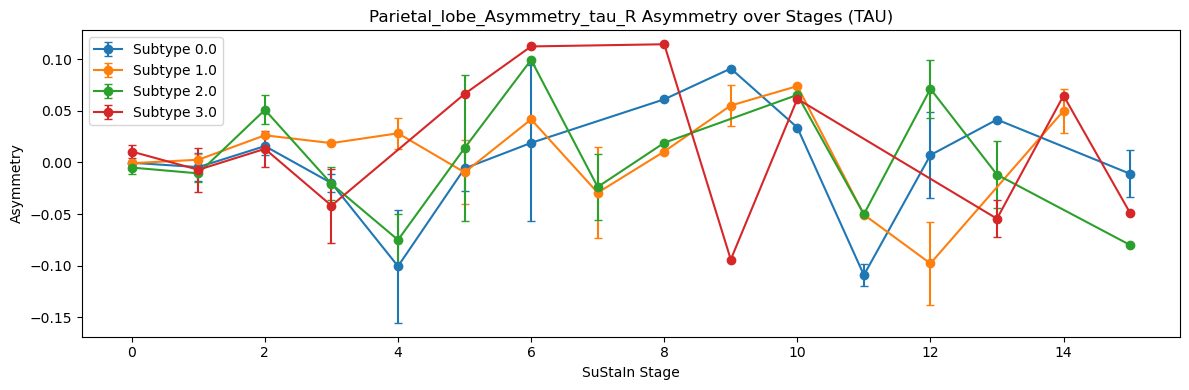

Temporal_lobe_Asymmetry_tau_L | Subtype 0.0 | Slope = 0.000, r = 0.01, p = 0.9631
Temporal_lobe_Asymmetry_tau_L | Subtype 1.0 | Slope = 0.001, r = 0.07, p = 0.8020
Temporal_lobe_Asymmetry_tau_L | Subtype 2.0 | Slope = -0.001, r = -0.07, p = 0.8126
Temporal_lobe_Asymmetry_tau_L | Subtype 3.0 | Slope = 0.002, r = 0.15, p = 0.6365


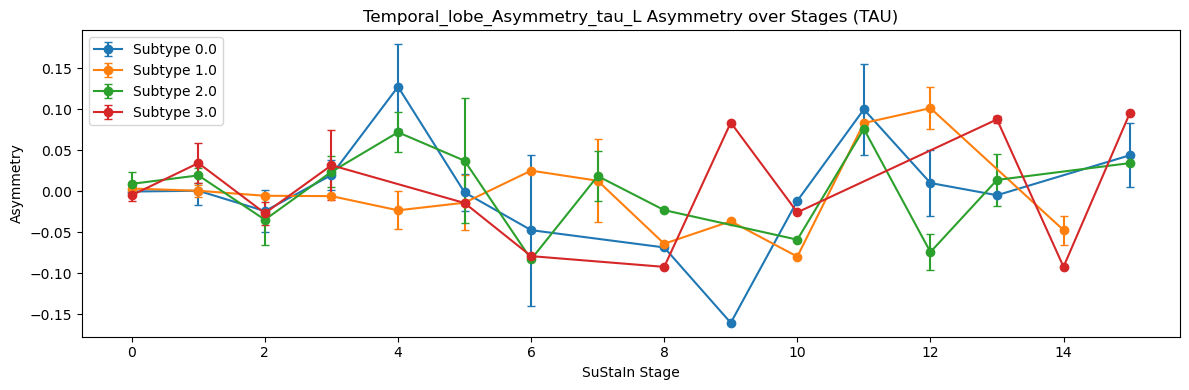

Temporal_lobe_Asymmetry_tau_R | Subtype 0.0 | Slope = -0.000, r = -0.01, p = 0.9631
Temporal_lobe_Asymmetry_tau_R | Subtype 1.0 | Slope = -0.001, r = -0.07, p = 0.8020
Temporal_lobe_Asymmetry_tau_R | Subtype 2.0 | Slope = 0.001, r = 0.07, p = 0.8126
Temporal_lobe_Asymmetry_tau_R | Subtype 3.0 | Slope = -0.002, r = -0.15, p = 0.6365


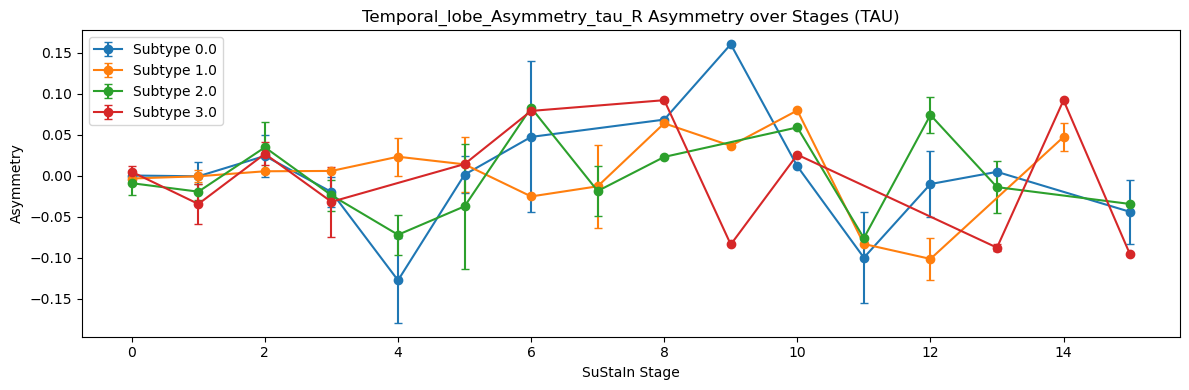

MTL_Asymmetry_tau_L | Subtype 0.0 | Slope = -0.000, r = -0.00, p = 0.9929
MTL_Asymmetry_tau_L | Subtype 1.0 | Slope = -0.001, r = -0.10, p = 0.7437
MTL_Asymmetry_tau_L | Subtype 2.0 | Slope = -0.001, r = -0.22, p = 0.4578
MTL_Asymmetry_tau_L | Subtype 3.0 | Slope = 0.000, r = 0.07, p = 0.8260


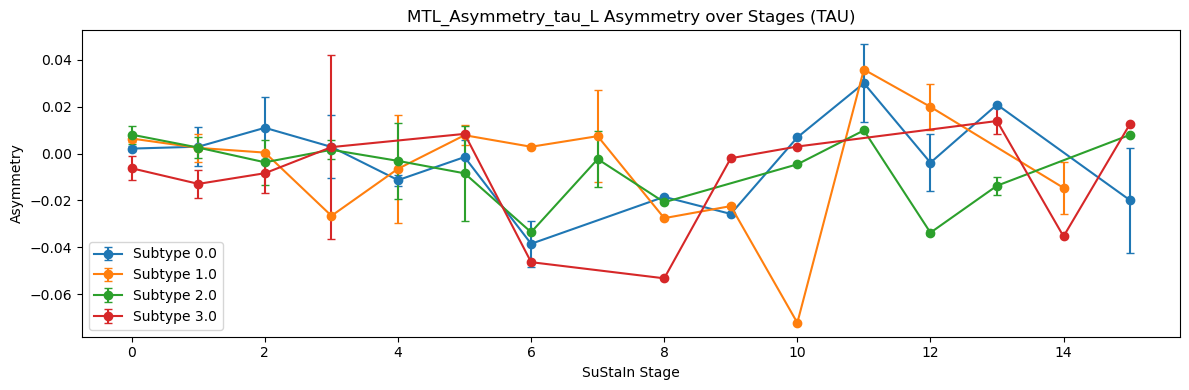

MTL_Asymmetry_tau_R | Subtype 0.0 | Slope = 0.000, r = 0.00, p = 0.9929
MTL_Asymmetry_tau_R | Subtype 1.0 | Slope = 0.001, r = 0.10, p = 0.7437
MTL_Asymmetry_tau_R | Subtype 2.0 | Slope = 0.001, r = 0.22, p = 0.4578
MTL_Asymmetry_tau_R | Subtype 3.0 | Slope = -0.000, r = -0.07, p = 0.8260


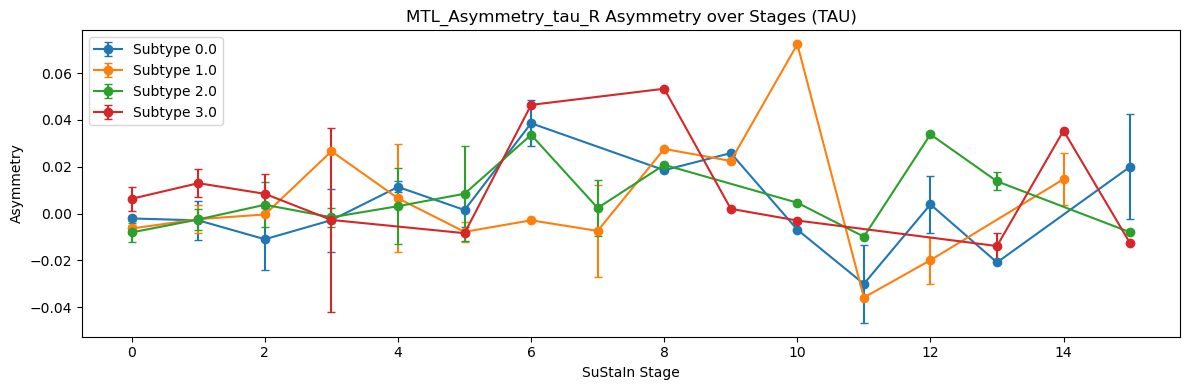


====== Asymmetry Across Stages in MRI ======
Frontal_lobe_Asymmetry_MRI_L | Subtype 0.0 | Slope = -0.000, r = -0.43, p = 0.1826
Frontal_lobe_Asymmetry_MRI_L | Subtype 1.0 | Slope = 0.002, r = 0.66, p = 0.1084
Frontal_lobe_Asymmetry_MRI_L | Subtype 2.0 | Slope = -0.003, r = -0.38, p = 0.3500
Frontal_lobe_Asymmetry_MRI_L | Subtype 3.0 | Slope = 0.002, r = 0.37, p = 0.5389


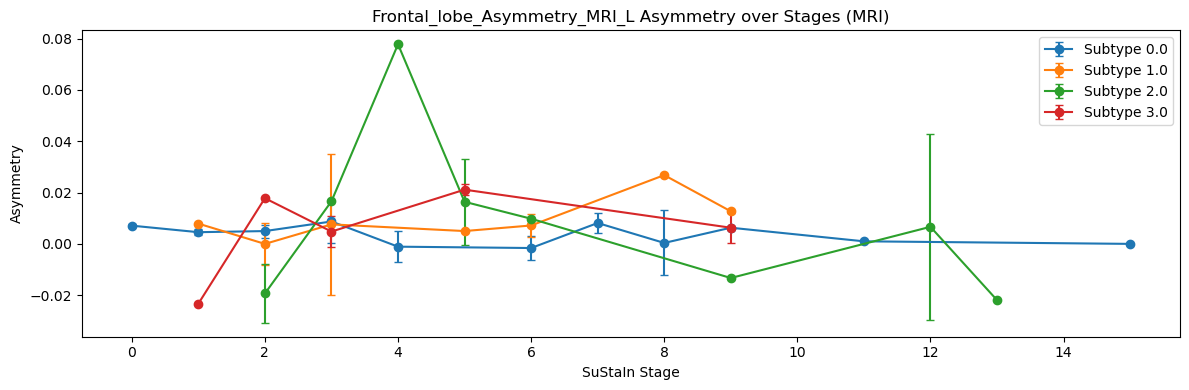

Frontal_lobe_Asymmetry_MRI_R | Subtype 0.0 | Slope = 0.000, r = 0.43, p = 0.1826
Frontal_lobe_Asymmetry_MRI_R | Subtype 1.0 | Slope = -0.002, r = -0.66, p = 0.1084
Frontal_lobe_Asymmetry_MRI_R | Subtype 2.0 | Slope = 0.003, r = 0.38, p = 0.3500
Frontal_lobe_Asymmetry_MRI_R | Subtype 3.0 | Slope = -0.002, r = -0.37, p = 0.5389


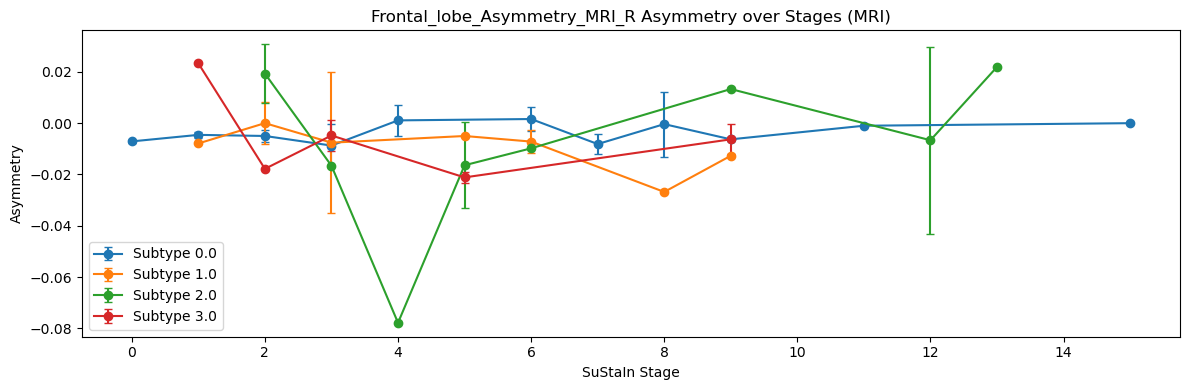

Occipital_lobe_Asymmetry_MRI_L | Subtype 0.0 | Slope = 0.002, r = 0.42, p = 0.1999
Occipital_lobe_Asymmetry_MRI_L | Subtype 1.0 | Slope = 0.000, r = 0.00, p = 1.0000
Occipital_lobe_Asymmetry_MRI_L | Subtype 2.0 | Slope = 0.003, r = 0.60, p = 0.1134
Occipital_lobe_Asymmetry_MRI_L | Subtype 3.0 | Slope = 0.014, r = 0.67, p = 0.2114


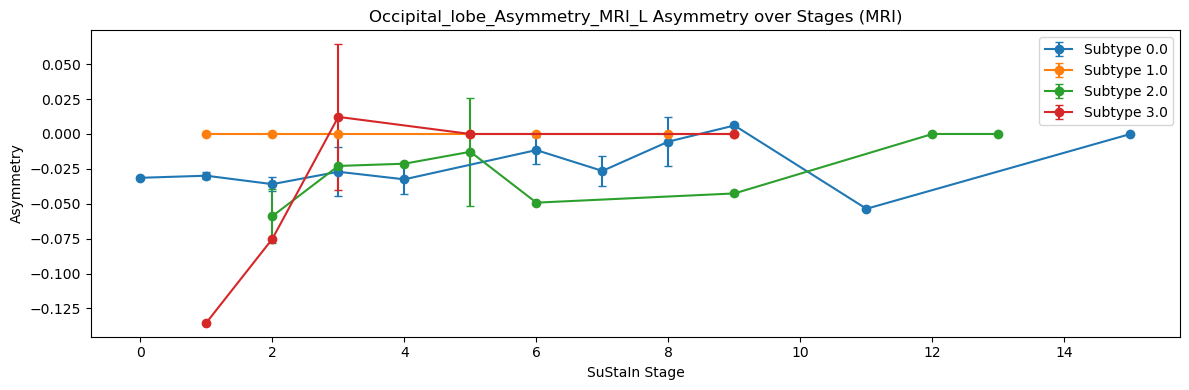

Occipital_lobe_Asymmetry_MRI_R | Subtype 0.0 | Slope = -0.002, r = -0.42, p = 0.1999
Occipital_lobe_Asymmetry_MRI_R | Subtype 1.0 | Slope = 0.000, r = 0.00, p = 1.0000
Occipital_lobe_Asymmetry_MRI_R | Subtype 2.0 | Slope = -0.003, r = -0.60, p = 0.1134
Occipital_lobe_Asymmetry_MRI_R | Subtype 3.0 | Slope = -0.014, r = -0.67, p = 0.2114


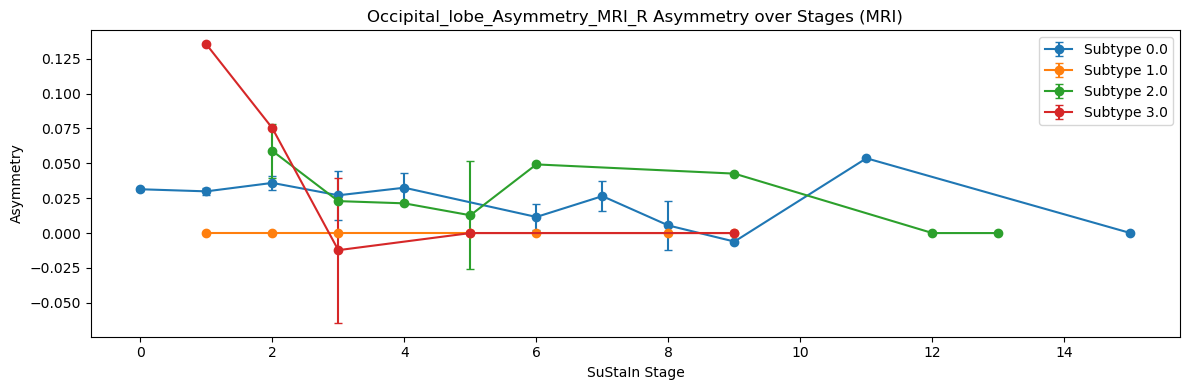

Parietal_lobe_Asymmetry_MRI_L | Subtype 0.0 | Slope = 0.000, r = 0.10, p = 0.7767
Parietal_lobe_Asymmetry_MRI_L | Subtype 1.0 | Slope = -0.001, r = -0.27, p = 0.5533
Parietal_lobe_Asymmetry_MRI_L | Subtype 2.0 | Slope = 0.004, r = 0.79, p = 0.0208
Parietal_lobe_Asymmetry_MRI_L | Subtype 3.0 | Slope = 0.002, r = 0.19, p = 0.7533


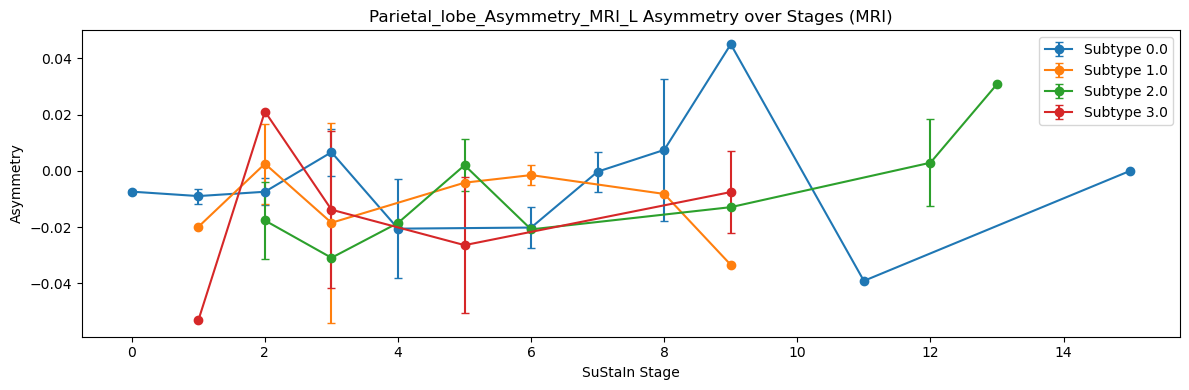

Parietal_lobe_Asymmetry_MRI_R | Subtype 0.0 | Slope = -0.000, r = -0.10, p = 0.7767
Parietal_lobe_Asymmetry_MRI_R | Subtype 1.0 | Slope = 0.001, r = 0.27, p = 0.5533
Parietal_lobe_Asymmetry_MRI_R | Subtype 2.0 | Slope = -0.004, r = -0.79, p = 0.0208
Parietal_lobe_Asymmetry_MRI_R | Subtype 3.0 | Slope = -0.002, r = -0.19, p = 0.7533


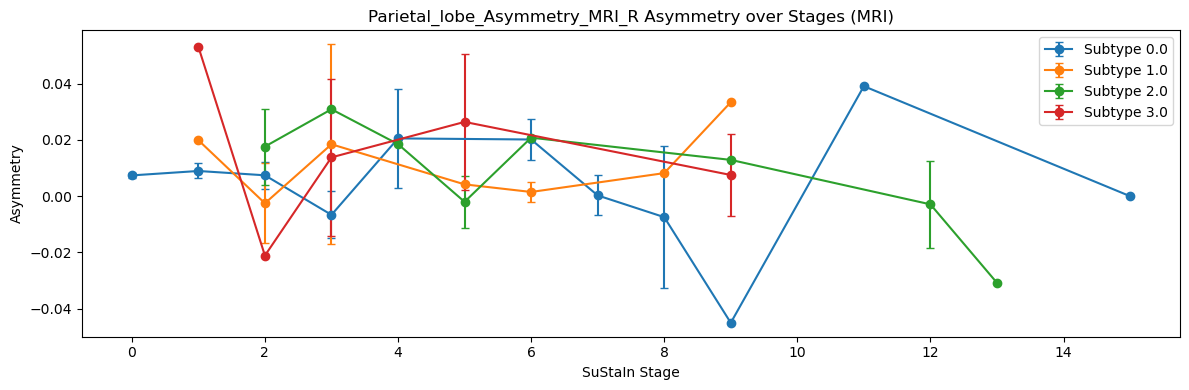

Temporal_lobe_Asymmetry_MRI_L | Subtype 0.0 | Slope = -0.000, r = -0.04, p = 0.9142
Temporal_lobe_Asymmetry_MRI_L | Subtype 1.0 | Slope = 0.012, r = 0.74, p = 0.0547
Temporal_lobe_Asymmetry_MRI_L | Subtype 2.0 | Slope = 0.003, r = 0.21, p = 0.6130
Temporal_lobe_Asymmetry_MRI_L | Subtype 3.0 | Slope = 0.000, r = 0.01, p = 0.9871


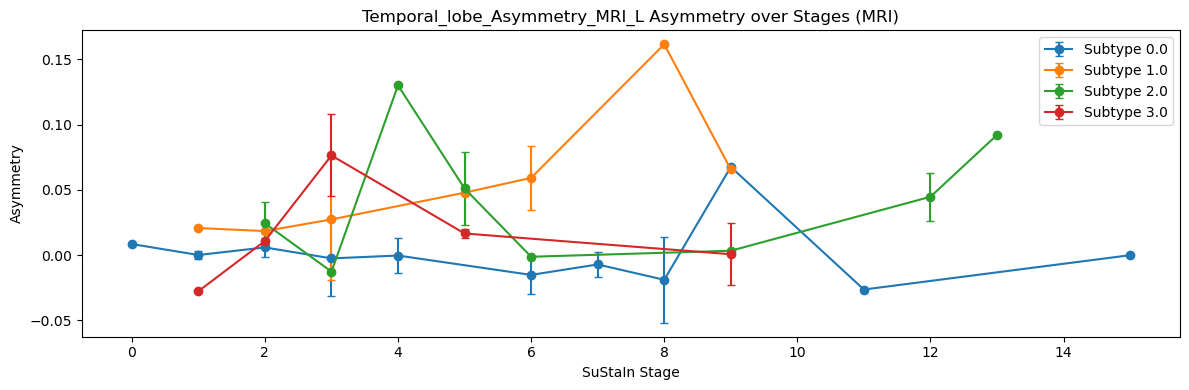

Temporal_lobe_Asymmetry_MRI_R | Subtype 0.0 | Slope = 0.000, r = 0.04, p = 0.9142
Temporal_lobe_Asymmetry_MRI_R | Subtype 1.0 | Slope = -0.012, r = -0.74, p = 0.0547
Temporal_lobe_Asymmetry_MRI_R | Subtype 2.0 | Slope = -0.003, r = -0.21, p = 0.6130
Temporal_lobe_Asymmetry_MRI_R | Subtype 3.0 | Slope = -0.000, r = -0.01, p = 0.9871


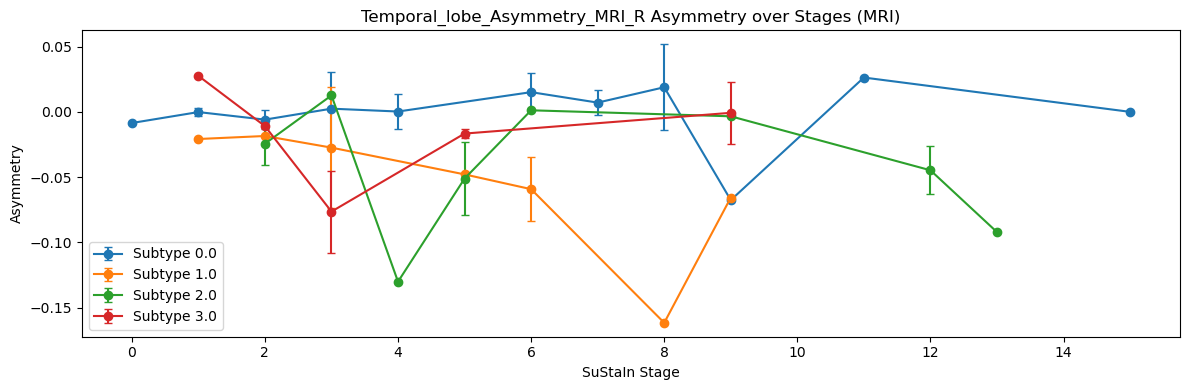

MTL_Asymmetry_MRI_L | Subtype 0.0 | Slope = 0.003, r = 0.49, p = 0.1280
MTL_Asymmetry_MRI_L | Subtype 1.0 | Slope = 0.001, r = 0.05, p = 0.9085
MTL_Asymmetry_MRI_L | Subtype 2.0 | Slope = -0.004, r = -0.69, p = 0.0578
MTL_Asymmetry_MRI_L | Subtype 3.0 | Slope = 0.000, r = 0.07, p = 0.9061


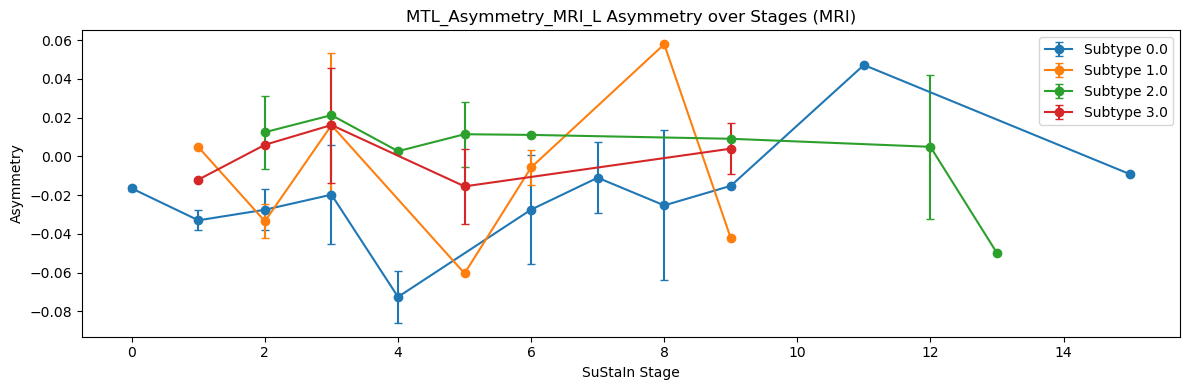

MTL_Asymmetry_MRI_R | Subtype 0.0 | Slope = -0.003, r = -0.49, p = 0.1280
MTL_Asymmetry_MRI_R | Subtype 1.0 | Slope = -0.001, r = -0.05, p = 0.9085
MTL_Asymmetry_MRI_R | Subtype 2.0 | Slope = 0.004, r = 0.69, p = 0.0578
MTL_Asymmetry_MRI_R | Subtype 3.0 | Slope = -0.000, r = -0.07, p = 0.9061


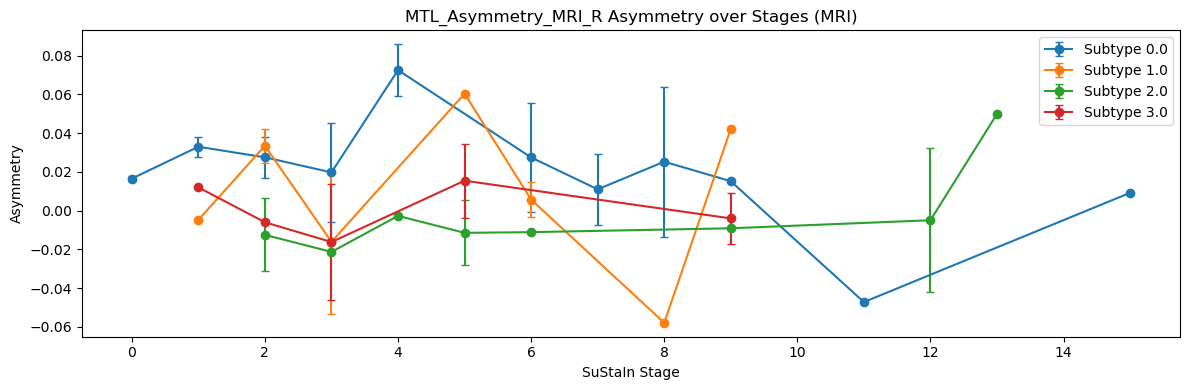

In [21]:
# Asymmetry variable lists assumed already defined
asymmetry_vars = {
    'MRI': asym_mri,
    'AB': asym_ab,
    'TAU': asym_tau
}

# Add explicit stage column names
modality_stage_cols = {
    'MRI': 'ml_stage_MRI',
    'AB': 'ml_stage_AB',
    'TAU': 'ml_stage_TAU'
}

# Plot asymmetry across SuStaIn stages by subtype
for modality, (subtype_col, df) in modalities.items():
    print(f"\n====== Asymmetry Across Stages in {modality} ======")

    stage_col = modality_stage_cols.get(modality)
    if stage_col not in df.columns:
        print(f"  Stage column '{stage_col}' not found in DataFrame.")
        continue

    asym_vars = asymmetry_vars[modality]
    subtypes = sorted(df[subtype_col].dropna().unique())

    for region in asym_vars:
        plt.figure(figsize=(12, 4))
        for subtype in subtypes:
            sub_df = df[df[subtype_col] == subtype]
            grouped = sub_df.groupby(stage_col)[region]
            means = grouped.mean()
            sems = grouped.sem()

            if means.empty:
                continue

            plt.errorbar(means.index, means.values, yerr=sems, label=f'Subtype {subtype}',
                         marker='o', capsize=3)

            # Linear trend stats (optional)
            if len(means) > 1:
                slope, _, r, pval, _ = linregress(means.index, means.values)
                print(f"{region} | Subtype {subtype} | Slope = {slope:.3f}, r = {r:.2f}, p = {pval:.4f}")

        plt.title(f"{region} Asymmetry over Stages ({modality})")
        plt.xlabel('SuStaIn Stage')
        plt.ylabel('Asymmetry')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [22]:
significant_results = []

for modality, (subtype_col, df) in modalities.items():
    #print(f"\n====== Asymmetry Across Stages in {modality} ======")

    stage_col = modality_stage_cols.get(modality)
    if stage_col not in df.columns:
        print(f"  Stage column '{stage_col}' not found in DataFrame.")
        continue

    asym_vars = asymmetry_vars[modality]
    subtypes = sorted(df[subtype_col].dropna().unique())

    for region in asym_vars:
        for subtype in subtypes:
            sub_df = df[df[subtype_col] == subtype]
            grouped = sub_df.groupby(stage_col)[region]
            means = grouped.mean()

            if len(means) > 1:
                slope, _, r, pval, _ = linregress(means.index, means.values)
                #print(f"{region} | Subtype {subtype} | Slope = {slope:.3f}, r = {r:.2f}, p = {pval:.4f}")

                if pval < 0.05:
                    significant_results.append({
                        'Modality': modality,
                        'Region': region,
                        'Subtype': subtype,
                        'Slope': slope,
                        'r': r,
                        'p': pval
                    })

# Convert to DataFrame and display
sig_df = pd.DataFrame(significant_results)
if not sig_df.empty:
    print("\n====== Statistically Significant Asymmetry Findings (p < 0.05) ======")
    print(sig_df.sort_values(['Modality', 'p']))
else:
    print("\nNo statistically significant asymmetry trends detected (p < 0.05).")



====== Statistically Significant Asymmetry Findings (p < 0.05) ======
  Modality                         Region  Subtype     Slope         r  \
0      MRI  Parietal_lobe_Asymmetry_MRI_L      2.0  0.003693  0.785784   
1      MRI  Parietal_lobe_Asymmetry_MRI_R      2.0 -0.003693 -0.785784   

          p  
0  0.020796  
1  0.020796  


In [23]:
# Store onset stages
asym_onsets = []

for modality, (subtype_col, df) in modalities.items():
    stage_col = modality_stage_cols.get(modality)
    if stage_col not in df.columns:
        continue

    asym_vars = asymmetry_vars[modality]
    subtypes = sorted(df[subtype_col].dropna().unique())

    for region in asym_vars:
        for subtype in subtypes:
            sub_df = df[df[subtype_col] == subtype]
            grouped = sub_df.groupby(stage_col)[region]

            for stage, values in grouped:
                values = values.dropna()
                if len(values) < 5:
                    continue  # too few samples for t-test

                t_stat, p_val = ttest_1samp(values, 0)
                mean_val = values.mean()

                if p_val < 0.05 and abs(mean_val) > 0.05:
                    asym_onsets.append({
                        'Modality': modality,
                        'Region': region,
                        'Subtype': subtype,
                        'Stage': stage,
                        'MeanAsym': round(mean_val, 3),
                        'p': round(p_val, 4)
                    })
                    break  # First significant stage = onset

onset_df = pd.DataFrame(asym_onsets)
onset_df = onset_df.sort_values(by=['Subtype', 'Stage'])

# Example: Count early asymmetry by region
early_asym_counts = onset_df.groupby(['Modality', 'Subtype', 'Region'])['Stage'].min().sort_values()
print(early_asym_counts)



Modality  Subtype  Region                       
TAU       2.0      Parietal_lobe_Asymmetry_tau_L    2.0
                   Parietal_lobe_Asymmetry_tau_R    2.0
MRI       0.0      MTL_Asymmetry_MRI_L              4.0
                   MTL_Asymmetry_MRI_R              4.0
Name: Stage, dtype: float64



====== Memory Score Across Stages in AB ======
Subtype 0.0 | Slope = -0.140, r = -0.22, p = 0.4057
Subtype 1.0 | Slope = -1.306, r = -0.48, p = 0.2250


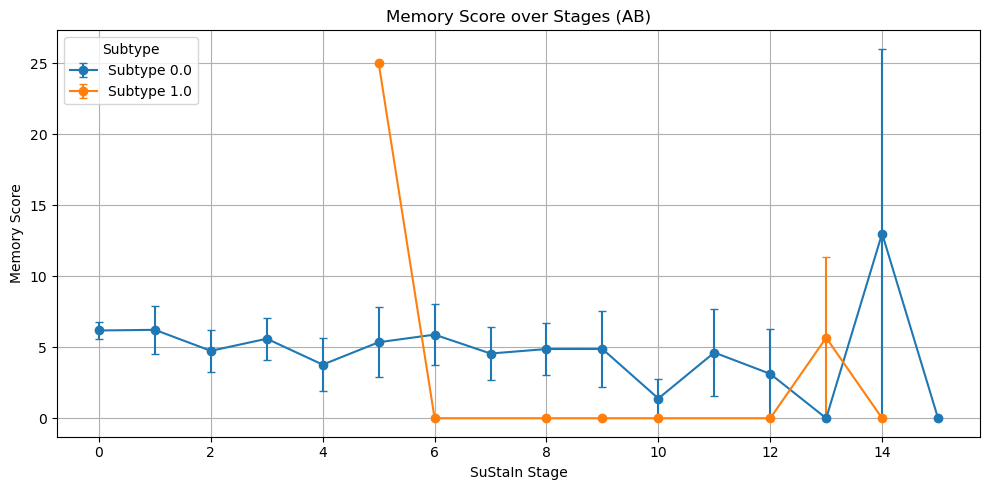


====== Memory Score Across Stages in TAU ======
Subtype 0.0 | Slope = -0.248, r = -0.43, p = 0.1218
Subtype 1.0 | Slope = 0.171, r = 0.09, p = 0.7892
Subtype 2.0 | Slope = -0.294, r = -0.13, p = 0.6831
Subtype 3.0 | Slope = 0.155, r = 0.09, p = 0.7996


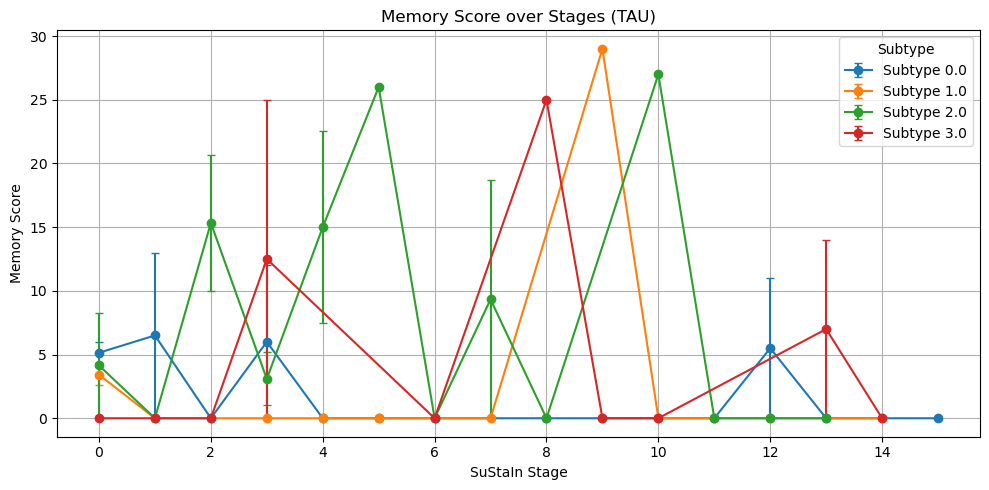


====== Memory Score Across Stages in MRI ======
Subtype 0.0 | Slope = -0.269, r = -0.35, p = 0.2958
Subtype 1.0 | Slope = -0.105, r = -0.07, p = 0.8816
Subtype 2.0 | Slope = -0.204, r = -0.43, p = 0.2859
Subtype 3.0 | Slope = 0.421, r = 0.41, p = 0.4889


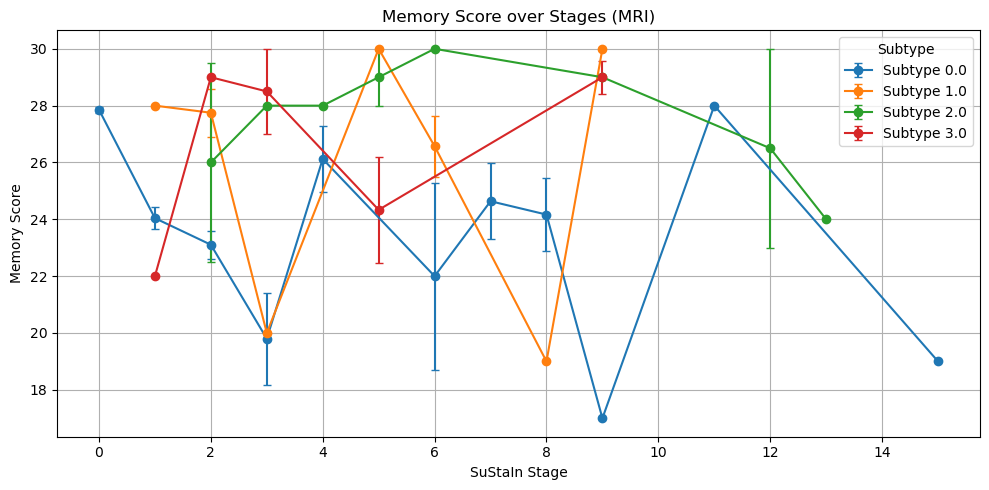

In [24]:
modalities_clean = {
    "AB": ('ml_subtype_AB', zdata_ab_clean),
    "TAU": ('ml_subtype_TAU', zdata_tau_clean),
    "MRI": ('ml_subtype_MRI', zdata_mri)
}

# Define memory score column (you can change 'MEMORY' to your column name like 'ADNI_MEM')
memory_col = mmse_score

# Plot memory score across SuStaIn stages by subtype
for modality, (subtype_col, df) in modalities_clean.items():
    print(f"\n====== Memory Score Across Stages in {modality} ======")

    stage_col = modality_stage_cols.get(modality)
    if stage_col not in df.columns:
        print(f"  Stage column '{stage_col}' not found in DataFrame.")
        continue

    if memory_col not in df.columns:
        print(f"  Memory column '{memory_col}' not found in DataFrame.")
        continue

    subtypes = sorted(df[subtype_col].dropna().unique())

    plt.figure(figsize=(10, 5))
    for subtype in subtypes:
        sub_df = df[df[subtype_col] == subtype]
        grouped = sub_df.groupby(stage_col)[memory_col]
        means = grouped.mean()
        sems = grouped.sem()

        if means.empty:
            continue

        plt.errorbar(means.index, means.values, yerr=sems, label=f'Subtype {subtype}',
                     marker='o', capsize=3)

        # Linear trend stats (optional)
        if len(means) > 1:
            slope, _, r, pval, _ = linregress(means.index, means.values)
            print(f"Subtype {subtype} | Slope = {slope:.3f}, r = {r:.2f}, p = {pval:.4f}")

    plt.title(f"Memory Score over Stages ({modality})")
    plt.xlabel('SuStaIn Stage')
    plt.ylabel('Memory Score')
    plt.legend(title='Subtype')
    plt.grid(True)
    plt.tight_layout()
    plt.show()




====== AB Diagnosis Distribution by Stage within Subtypes ======


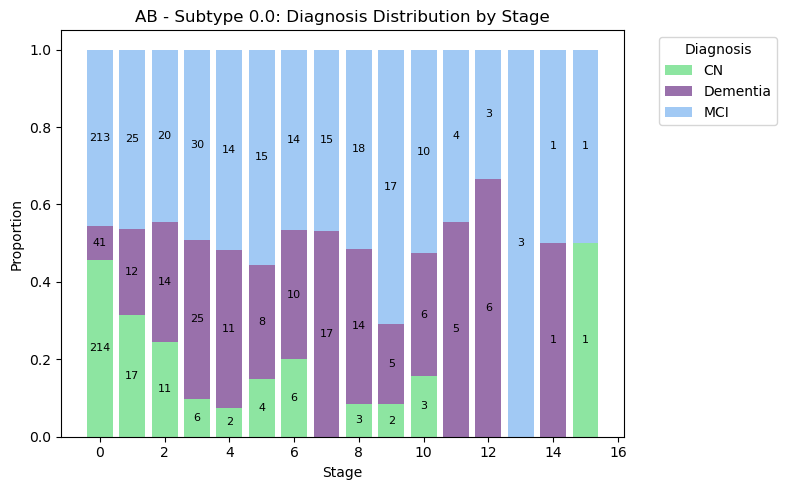

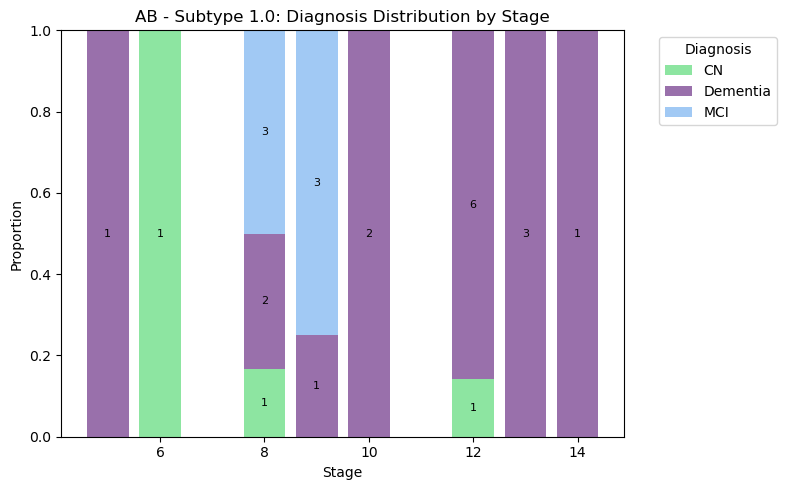



====== TAU Diagnosis Distribution by Stage within Subtypes ======


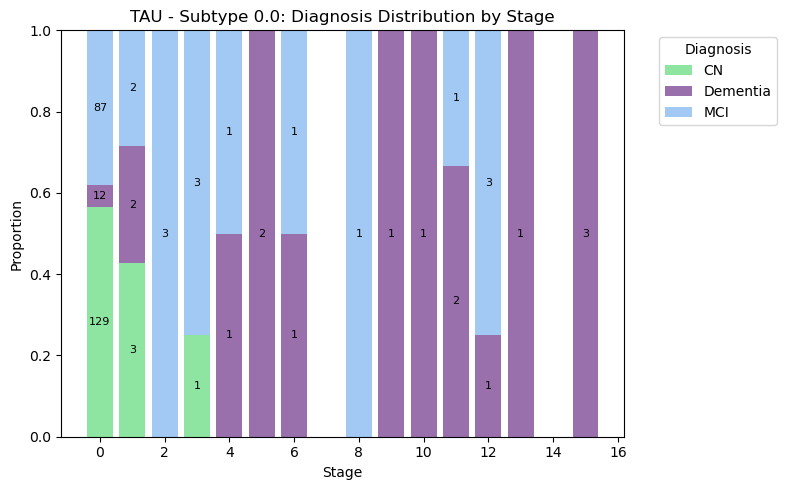

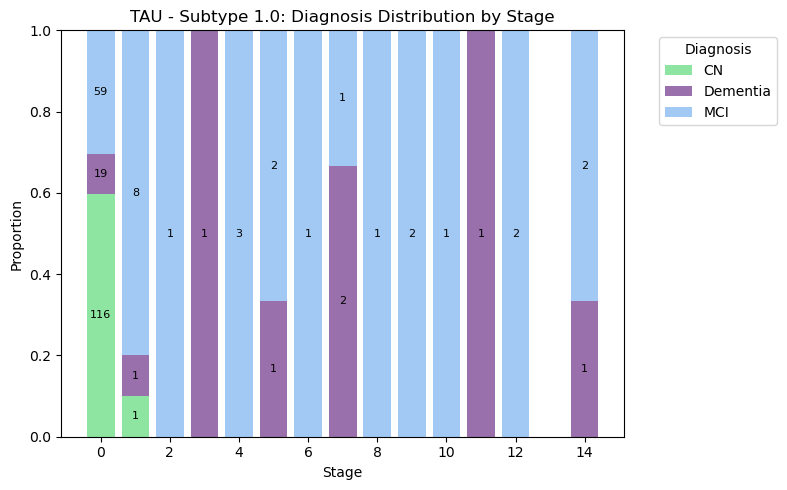

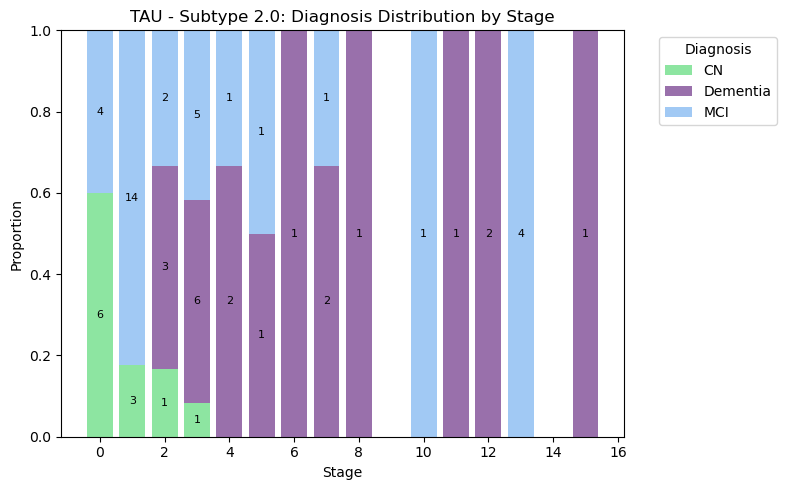

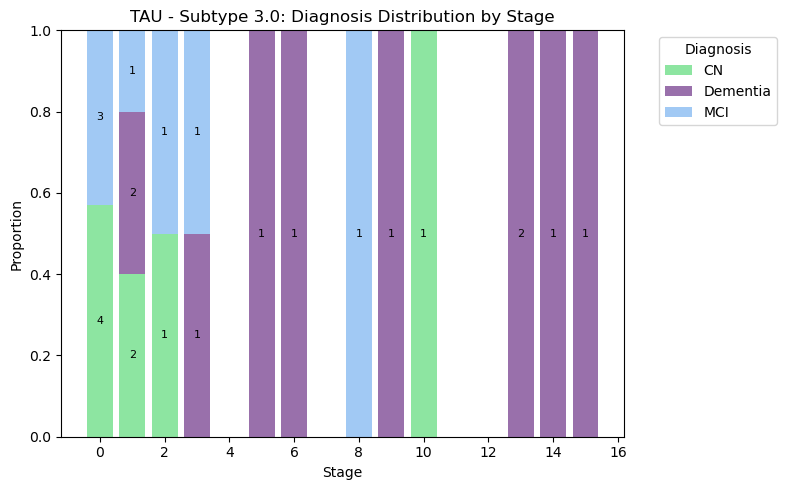



====== MRI Diagnosis Distribution by Stage within Subtypes ======


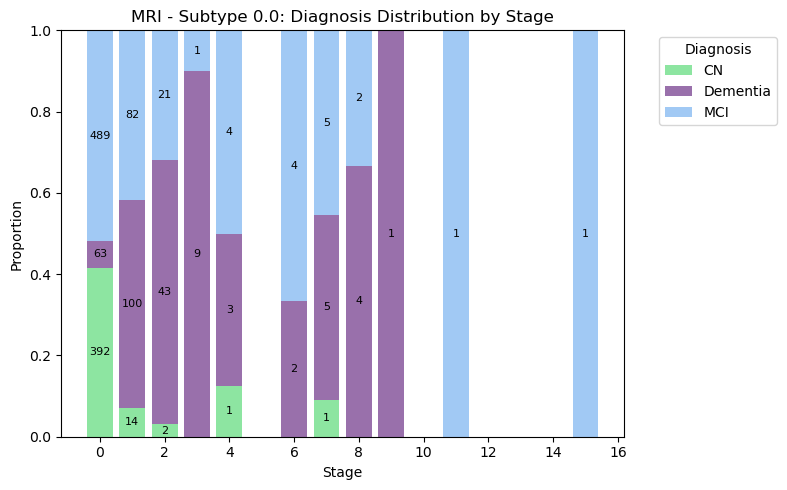

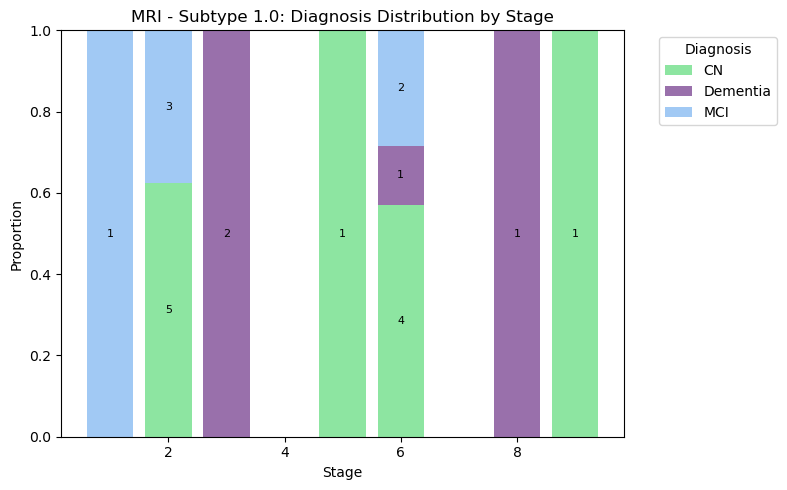

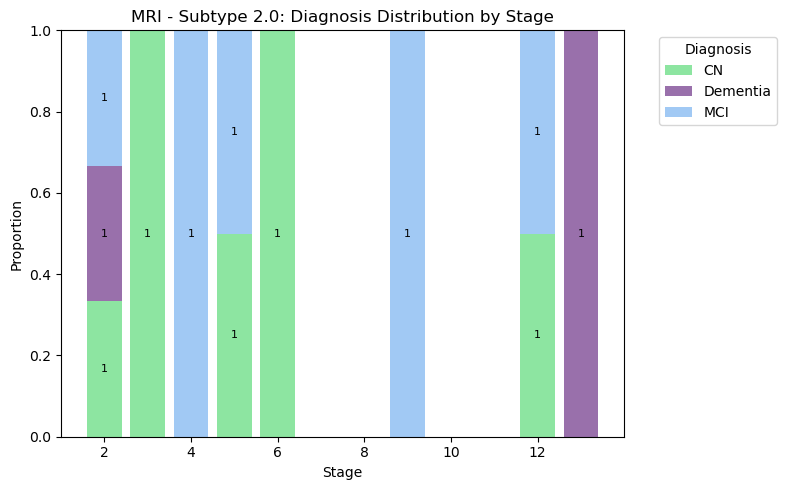

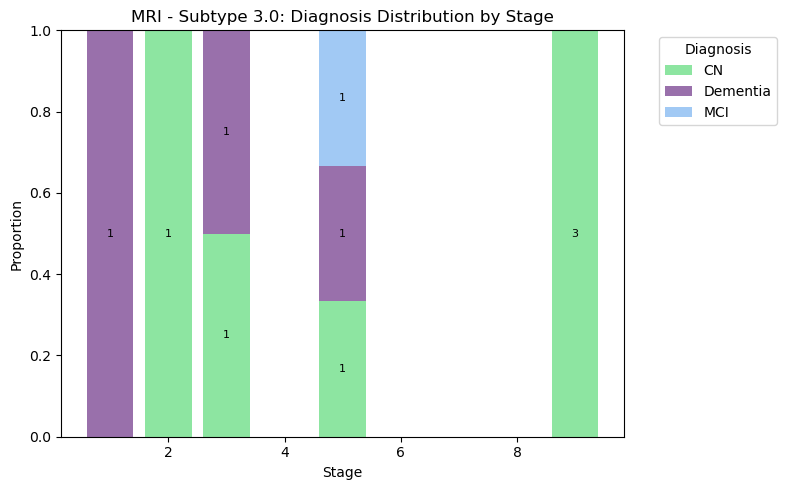



====== AB Stage Distribution Within Each Diagnosis per Subtype ======

Subtype 1.0:

Counts:
ml_stage_AB        0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  \
DIAGNOSIS_STRING                                                                
CN                214  17  11   6   2   4   6   0   3   2   3   0   0   0   0   
Dementia           41  12  14  25  11   8  10  17  14   5   6   5   6   0   1   
MCI               213  25  20  30  14  15  14  15  18  17  10   4   3   3   1   

ml_stage_AB       15  
DIAGNOSIS_STRING      
CN                 1  
Dementia           0  
MCI                1  

Proportions within each diagnosis (row-wise):
ml_stage_AB        0    1    2    3    4    5    6    7    8    9    10   11  \
DIAGNOSIS_STRING                                                               
CN               0.80 0.06 0.04 0.02 0.01 0.01 0.02 0.00 0.01 0.01 0.01 0.00   
Dementia         0.23 0.07 0.08 0.14 0.06 0.05 0.06 0.10 0.08 0.03 0.03 0.03   
MCI              

In [71]:
colors = ['#8de5a1', '#9970AB', '#a1c9f4', '#FFB347', '#D36C6C']  # Extend if more than 3 diagnoses
diagnosis_col = 'DIAGNOSIS_STRING'  # Update if needed

for modality, (subtype_col, df) in modalities.items():
    print(f"\n\n====== {modality} Diagnosis Distribution by Stage within Subtypes ======")

    # Ensure stage column is integer
    stage_col = subtype_col.replace("subtype", "stage")
    df[stage_col] = df[stage_col].astype(int)

    subtypes = sorted(df[subtype_col].dropna().unique())

    for subtype in subtypes:
        sub_df = df[df[subtype_col] == subtype]
        
        # Crosstab of stage vs diagnosis
        ctab = pd.crosstab(sub_df[stage_col], sub_df[diagnosis_col])

        # Normalize for proportions
        prop = ctab.div(ctab.sum(1), axis=0)

        fig, ax = plt.subplots(figsize=(8, 5))
        bottom = np.zeros(len(prop))

        for i, diag in enumerate(prop.columns):
            values = prop[diag].values
            counts = ctab[diag].values
            bars = ax.bar(prop.index, values, bottom=bottom, label=diag, color=colors[i % len(colors)])

            # Annotate with counts
            for j, bar in enumerate(bars):
                count = counts[j]
                if count > 0:
                    ax.text(bar.get_x() + bar.get_width() / 2,
                            bar.get_y() + bar.get_height() / 2,
                            f'{int(count)}',
                            ha='center', va='center', fontsize=8)

            bottom += values

        ax.set_title(f'{modality} - Subtype {subtype}: Diagnosis Distribution by Stage')
        ax.set_xlabel("Stage")
        ax.set_ylabel("Proportion")
        ax.legend(title="Diagnosis", bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.show()

for modality, (subtype_col, df) in modalities.items():
    print(f"\n\n====== {modality} Stage Distribution Within Each Diagnosis per Subtype ======")

    stage_col = subtype_col.replace("subtype", "stage")
    df[stage_col] = df[stage_col].astype(int)

    subtypes = sorted(df[subtype_col].dropna().unique())

    for subtype in subtypes:
        sub_df = df[df[subtype_col] == subtype]

        print(f"\nSubtype {subtype+1}:")

        # Crosstab: counts of stages per diagnosis
        ctab = pd.crosstab(sub_df[diagnosis_col], sub_df[stage_col])  # rows = diagnosis, cols = stage
        print("\nCounts:")
        print(ctab)

        # Normalize across rows (i.e., per diagnosis group)
        prop = ctab.div(ctab.sum(axis=1), axis=0)
        print("\nProportions within each diagnosis (row-wise):")
        print(prop.round(2))  # rounded to 2 decimals

    # ✅ Now compute overall stage distribution within each diagnosis group for this modality
    print(f"\n📊 Overall Stage Distribution Within Each Diagnosis Group for {modality}:")

    # Use only rows with non-null subtype/stage
    full_df = df[df[subtype_col].notna() & df[stage_col].notna()]
    
    # Crosstab: total counts of stages per diagnosis
    ctab_overall = pd.crosstab(full_df[diagnosis_col], full_df[stage_col])
    print("\nCounts (overall):")
    print(ctab_overall)

    # Row-wise proportion: within each diagnosis group
    prop_overall = ctab_overall.div(ctab_overall.sum(axis=1), axis=0)
    print("\nProportions within each diagnosis group (row-wise, overall):")
    print(prop_overall.round(2))




## 3. Characterise paired subtypes:

In [26]:
# Merge AB + MRI
merged_ab_mri = pd.merge(
    zdata_ab[['RID', 'ml_subtype_AB', 'ml_stage_AB', dx, diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age] + asymmetry_vars['AB']],
    zdata_mri[['RID', 'ml_subtype_MRI', 'ml_stage_MRI'] + asymmetry_vars['MRI']],
    on='RID'
)

# Merge TAU + MRI
merged_tau_mri = pd.merge(
    zdata_tau[['RID', 'ml_subtype_TAU', 'ml_stage_TAU', dx, diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age] + asymmetry_vars['TAU']],
    zdata_mri[['RID', 'ml_subtype_MRI', 'ml_stage_MRI'] + asymmetry_vars['MRI']],
    on='RID'
)

# Merge AB + TAU
merged_ab_tau = pd.merge(
    zdata_ab[['RID', 'ml_subtype_AB', 'ml_stage_AB', dx, diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age] + asymmetry_vars['AB']],
    zdata_tau[['RID', 'ml_subtype_TAU', 'ml_stage_TAU'] + asymmetry_vars['TAU']],
    on='RID'
)




====== AB_TAU Combined Subtype Analysis ======

 AGE (Continuous)
  Group sizes: {'AB_1__TAU_1': 96, 'AB_1__TAU_2': 90, 'AB_1__TAU_3': 30, 'AB_1__TAU_4': 11}
→ ANOVA p = 0.7262 | Eta² = 0.006


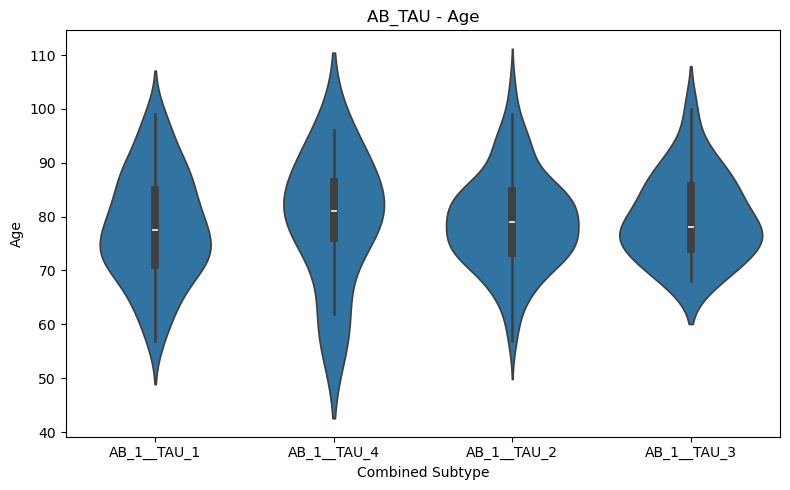


 MMSCORE (Continuous)
  Group sizes: {'AB_1__TAU_1': 16, 'AB_1__TAU_2': 8, 'AB_1__TAU_3': 2, 'AB_1__TAU_4': 2}
 Small sample size detected in at least one group.
→ Kruskal-Wallis p = 0.7542 | Epsilon² = -0.075


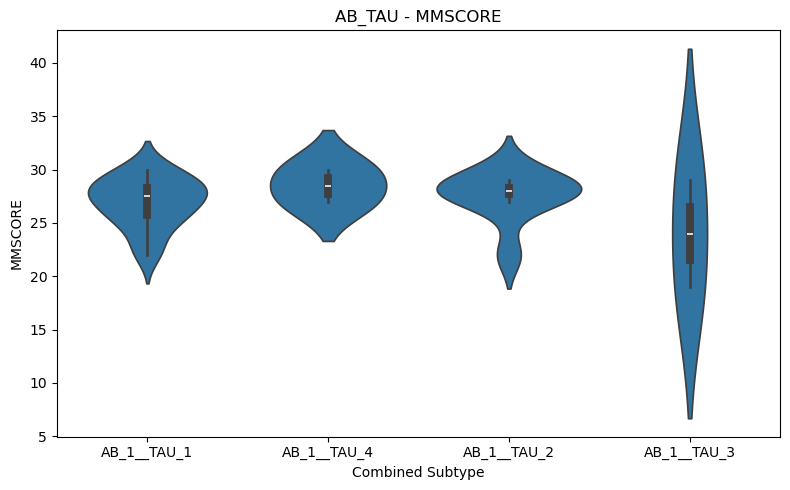


 PTEDUCAT (Continuous)
  Group sizes: {'AB_1__TAU_1': 96, 'AB_1__TAU_2': 90, 'AB_1__TAU_3': 30, 'AB_1__TAU_4': 11}
→ Kruskal-Wallis p = 0.0571 | Epsilon² = 0.020


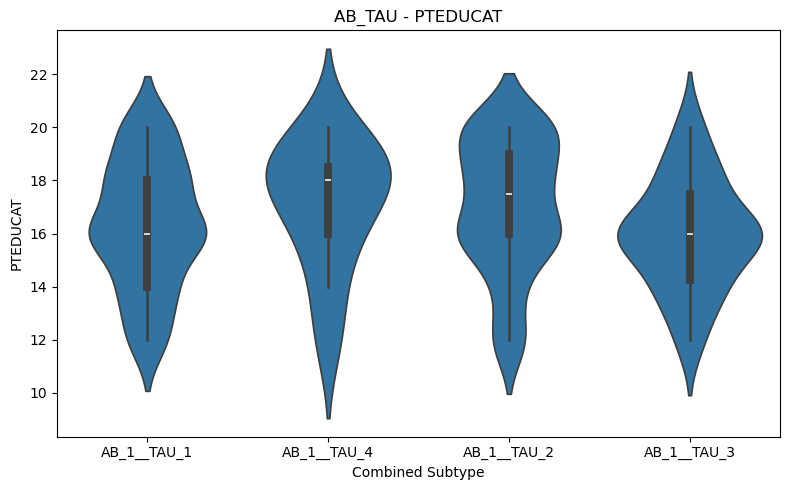


 AGE_RETIRE (Continuous)
  Group sizes: {'AB_1__TAU_1': 72, 'AB_1__TAU_2': 69, 'AB_1__TAU_3': 24, 'AB_1__TAU_4': 7}
→ Kruskal-Wallis p = 0.5219 | Epsilon² = -0.004


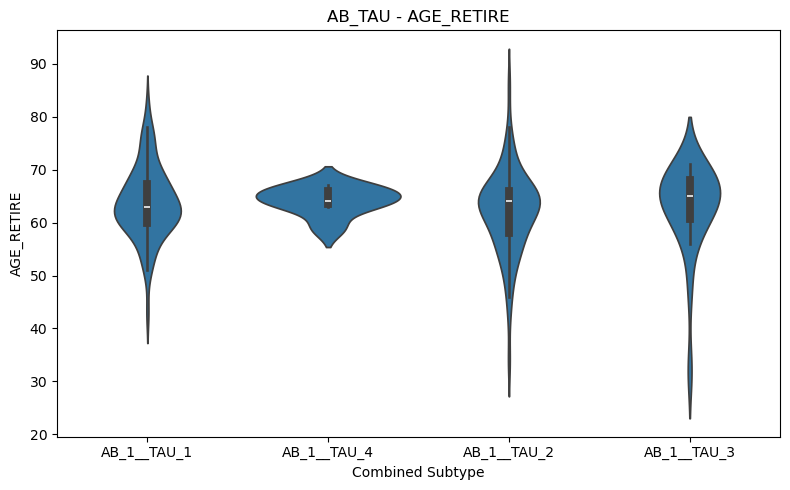


 DIAGNOSIS_STRING (Categorical)
→ Chi-squared p = 0.0835 | Cramér’s V = 0.107


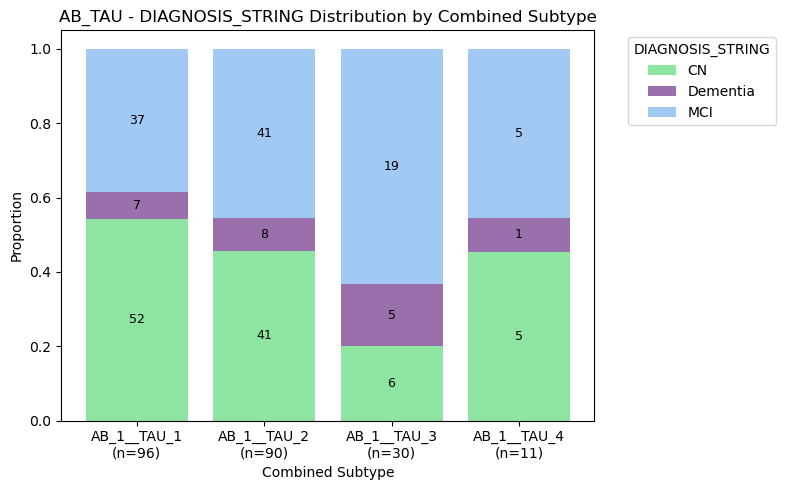


 PTGENDER (Categorical)
→ Chi-squared p = 0.2680 | Cramér’s V = 0.064


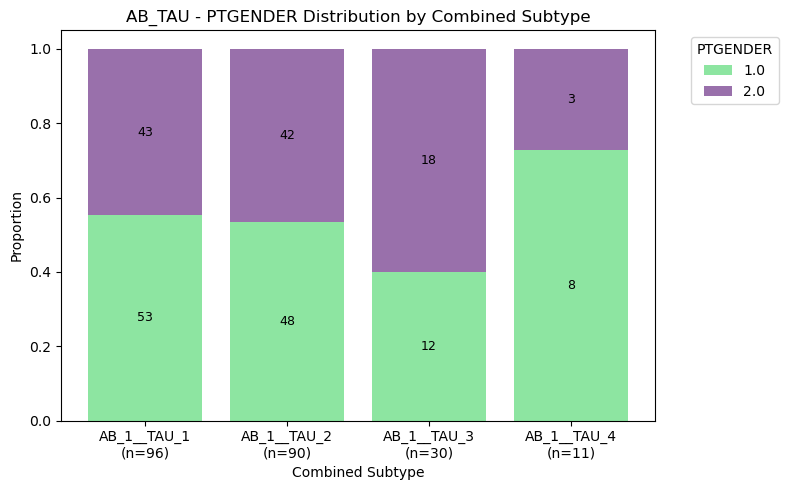


 APOE4 (Categorical)
→ Chi-squared p = 0.0066 | Cramér’s V = 0.162

Post hoc (adjusted residuals with Bonferroni correction):
       Subtype  APOE4    p  p_adj        direction
8  AB_1__TAU_3   2.00 0.00   0.01  Overrepresented


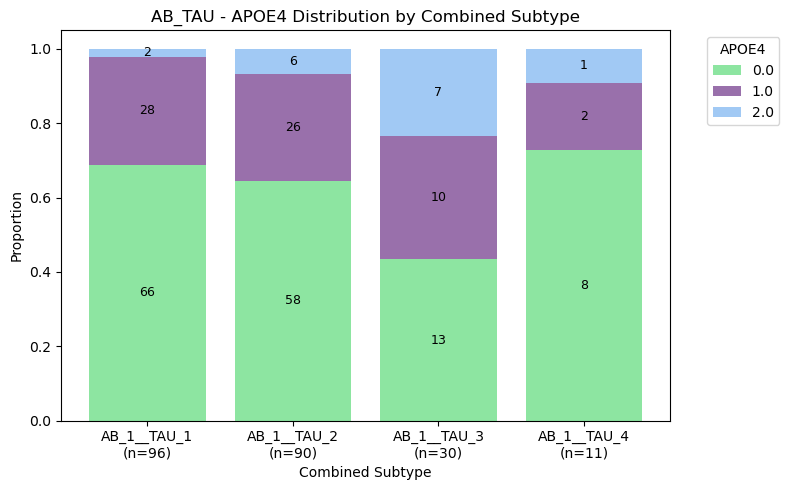



====== TAU_MRI Combined Subtype Analysis ======

 AGE (Continuous)
  Group sizes: {'TAU_1__MRI_1': 203, 'TAU_2__MRI_1': 175, 'TAU_3__MRI_1': 56, 'TAU_4__MRI_1': 19}
→ ANOVA p = 0.2317 | Eta² = 0.010


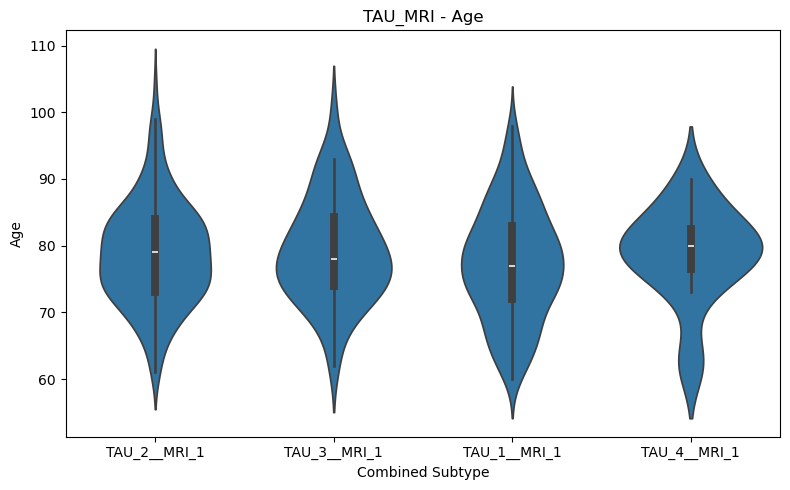


 MMSCORE (Continuous)
  Group sizes: {'TAU_1__MRI_1': 28, 'TAU_2__MRI_1': 20, 'TAU_3__MRI_1': 11, 'TAU_4__MRI_1': 2}
 Small sample size detected in at least one group.
→ Kruskal-Wallis p = 0.0005 | Epsilon² = 0.255

Post hoc pairwise Mann-Whitney U test results (Bonferroni corrected):
                           pair  p_uncorrected  p_bonferroni  significant
0  TAU_2__MRI_1 vs TAU_3__MRI_1           0.00          0.00         True
3  TAU_3__MRI_1 vs TAU_1__MRI_1           0.00          0.01         True


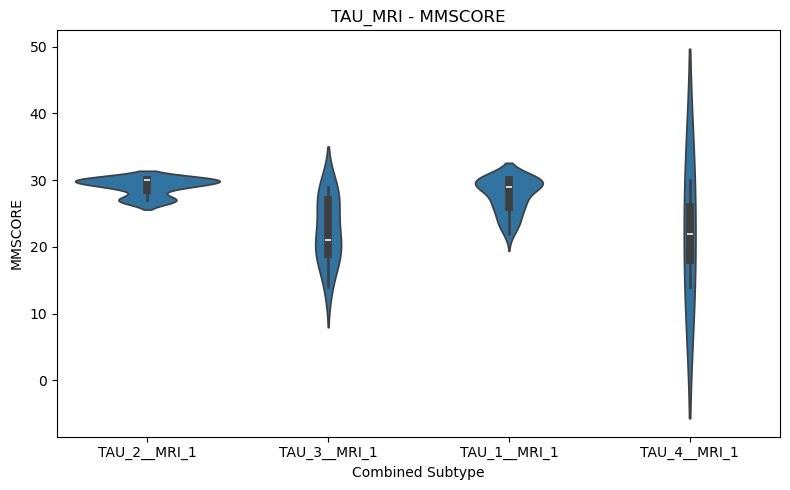


 PTEDUCAT (Continuous)
  Group sizes: {'TAU_1__MRI_1': 203, 'TAU_2__MRI_1': 175, 'TAU_3__MRI_1': 56, 'TAU_4__MRI_1': 19}
→ Kruskal-Wallis p = 0.1235 | Epsilon² = 0.006


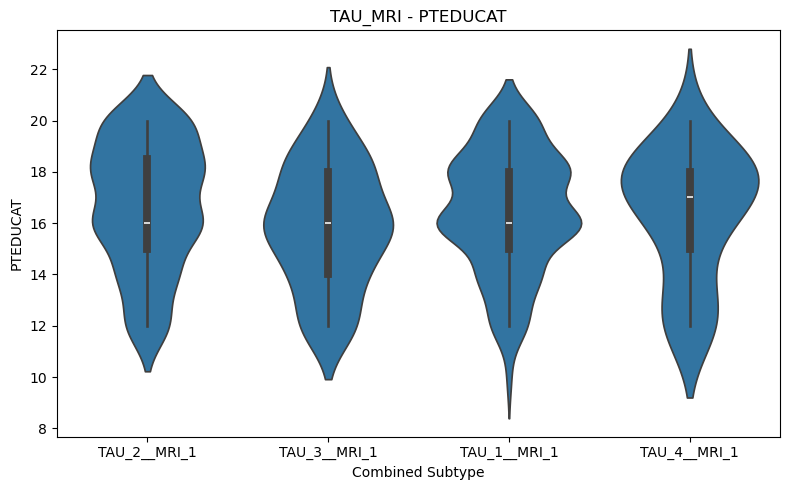


 AGE_RETIRE (Continuous)
  Group sizes: {'TAU_1__MRI_1': 159, 'TAU_2__MRI_1': 133, 'TAU_3__MRI_1': 48, 'TAU_4__MRI_1': 15}
→ Kruskal-Wallis p = 0.3561 | Epsilon² = 0.001


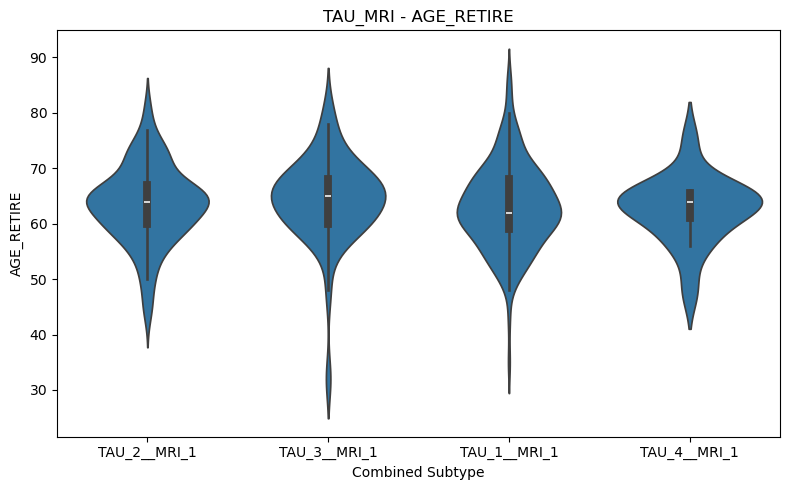


 DIAGNOSIS_STRING (Categorical)
→ Chi-squared p = 0.0000 | Cramér’s V = 0.205

Post hoc (adjusted residuals with Bonferroni correction):
         Subtype DIAGNOSIS_STRING    p  p_adj         direction
10  TAU_4__MRI_1         Dementia 0.00   0.01   Overrepresented
6   TAU_3__MRI_1               CN 0.00   0.01  Underrepresented
7   TAU_3__MRI_1         Dementia 0.00   0.02   Overrepresented


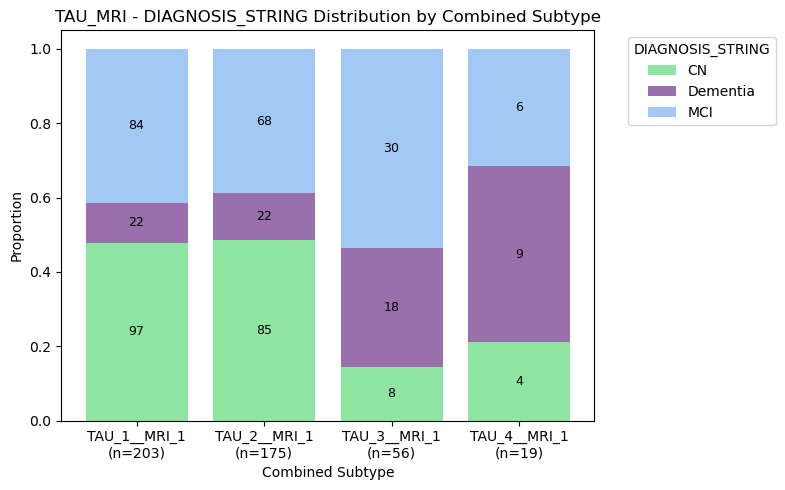


 PTGENDER (Categorical)
→ Chi-squared p = 0.3547 | Cramér’s V = 0.023


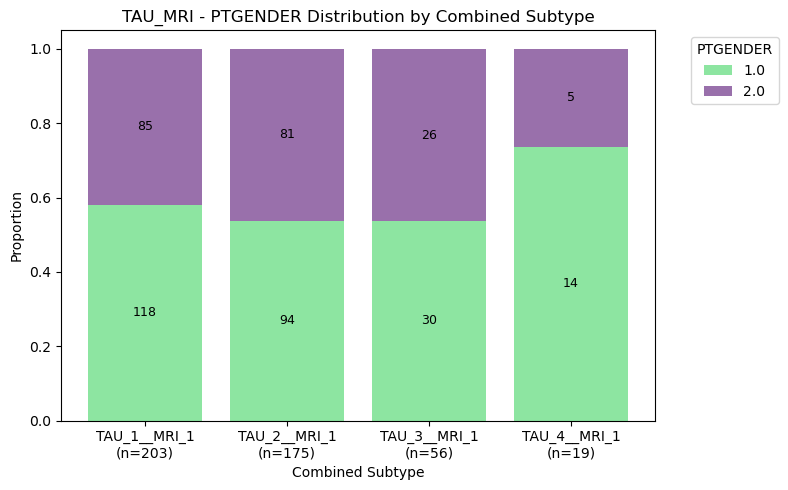


 APOE4 (Categorical)
→ Chi-squared p = 0.0000 | Cramér’s V = 0.172

Post hoc (adjusted residuals with Bonferroni correction):
        Subtype  APOE4    p  p_adj        direction
8  TAU_3__MRI_1   2.00 0.00   0.00  Overrepresented


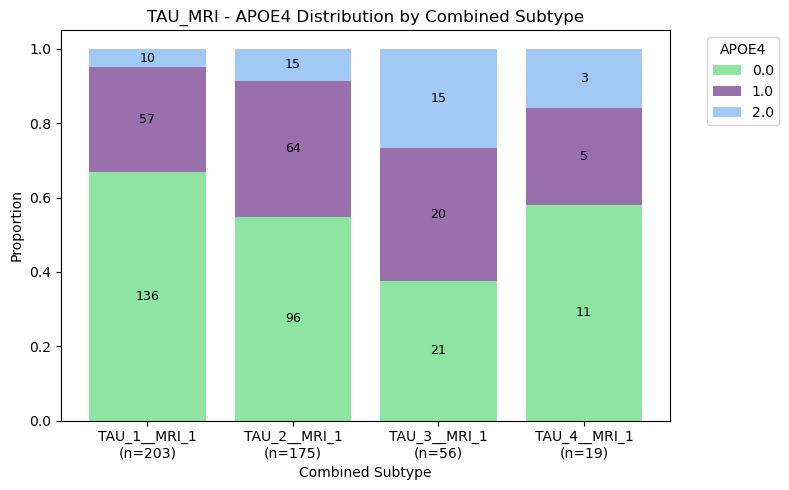



====== AB_MRI Combined Subtype Analysis ======

 AGE (Continuous)
  Group sizes: {'AB_1__MRI_1': 634, 'AB_2__MRI_1': 19}
→ Mann-Whitney U test p = 0.6881


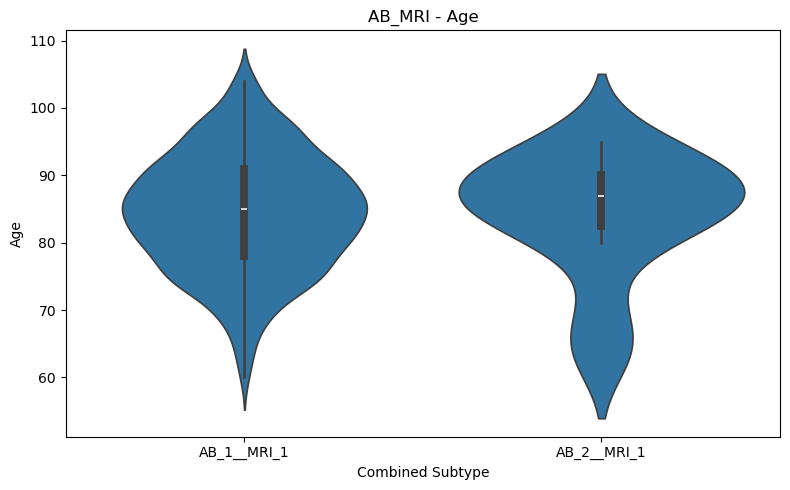


 MMSCORE (Continuous)
  Group sizes: {'AB_1__MRI_1': 91, 'AB_2__MRI_1': 1}
 Small sample size detected in at least one group.
→ Mann-Whitney U test p = 0.3134


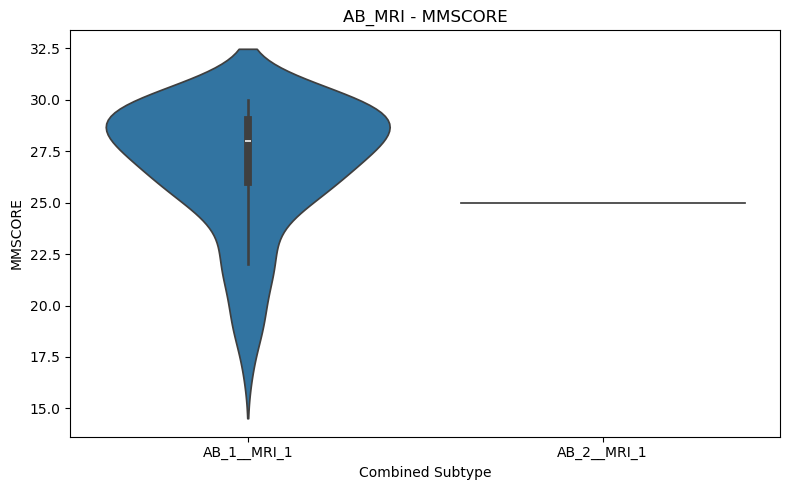


 PTEDUCAT (Continuous)
  Group sizes: {'AB_1__MRI_1': 634, 'AB_2__MRI_1': 19}
→ Mann-Whitney U test p = 0.4674


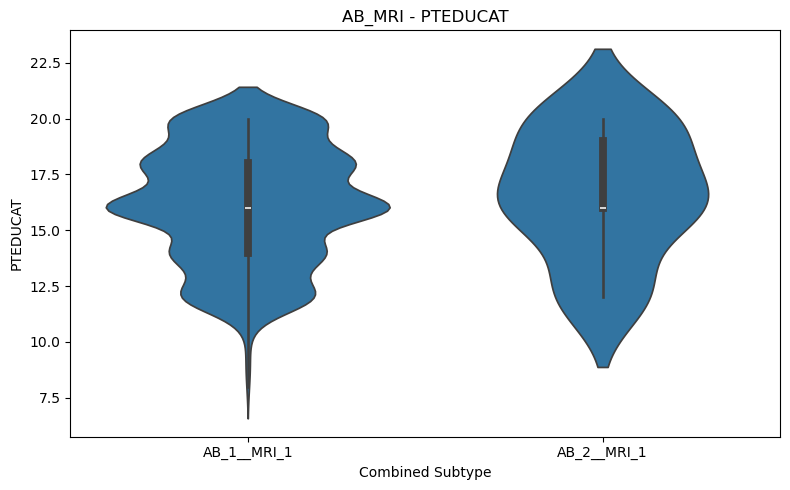


 AGE_RETIRE (Continuous)
  Group sizes: {'AB_1__MRI_1': 503, 'AB_2__MRI_1': 17}
→ Mann-Whitney U test p = 0.4792


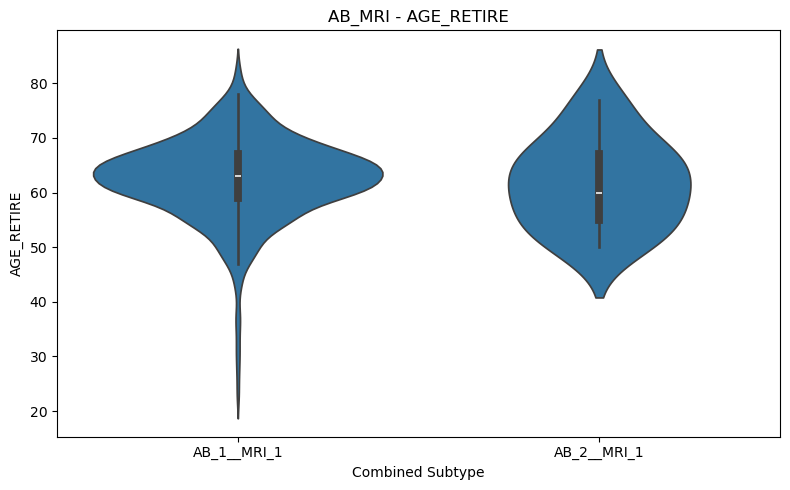


 DIAGNOSIS_STRING (Categorical)
→ Chi-squared p = 0.0000 | Cramér’s V = 0.187

Post hoc (adjusted residuals with Bonferroni correction):
       Subtype DIAGNOSIS_STRING    p  p_adj        direction
4  AB_2__MRI_1         Dementia 0.00   0.00  Overrepresented


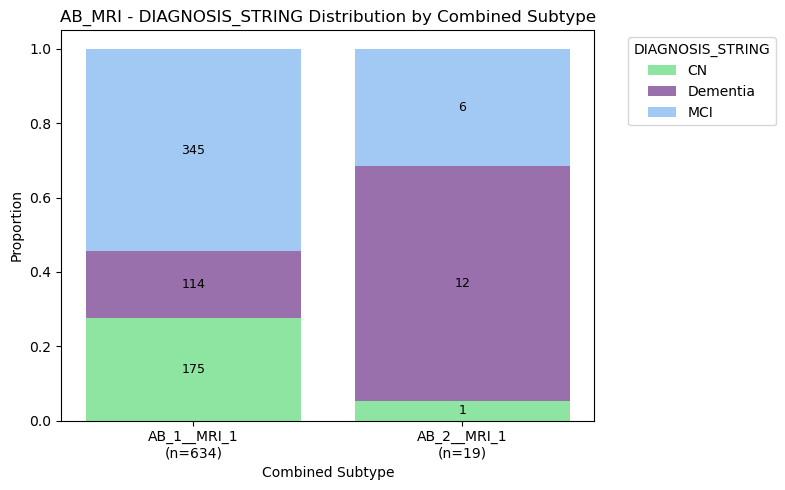


 PTGENDER (Categorical)
→ Chi-squared p = 0.0281 | Cramér’s V = 0.066

Post hoc (adjusted residuals with Bonferroni correction):
No significant residuals after correction.


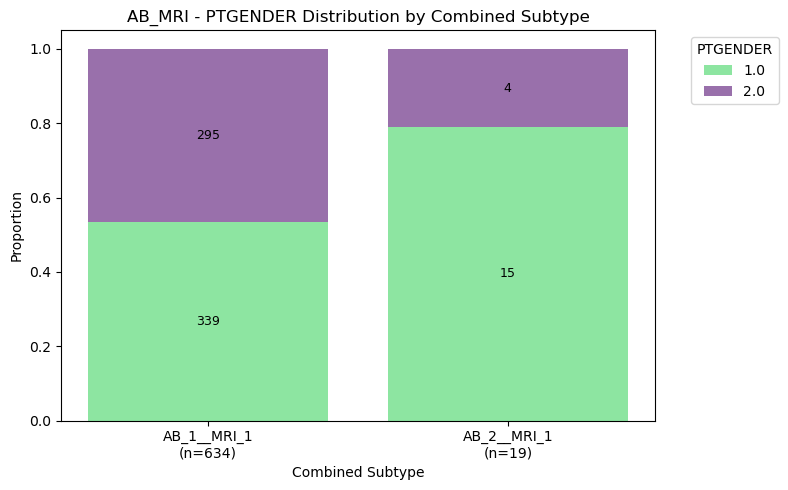


 APOE4 (Categorical)
→ Chi-squared p = 0.6401 | Cramér’s V = 0.000


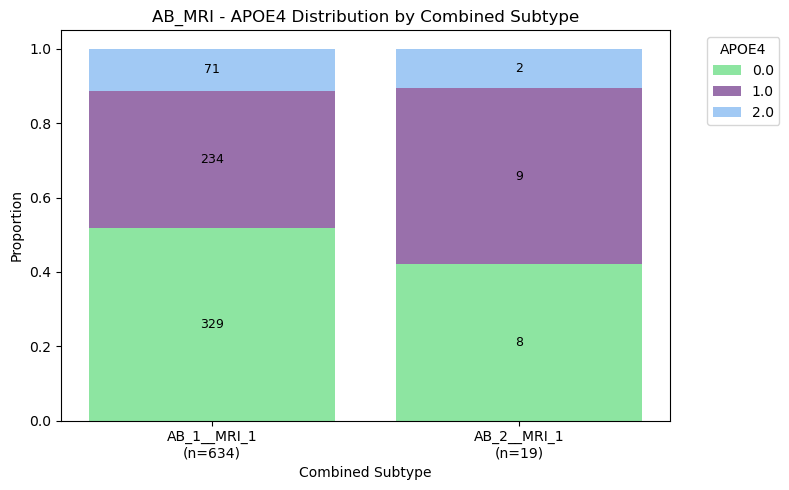

In [61]:
def combined_subtype_analysis(merged_pairs, pair_subtype_cols, continuous_vars, categorical_vars, mmse_score, retire_age):
    colors = ['#8de5a1', '#9970AB', '#a1c9f4']

    for pair_name, df in merged_pairs.items():
        print(f"\n\n====== {pair_name} Combined Subtype Analysis ======")
        sub1_col, sub2_col = pair_subtype_cols[pair_name]

        df = df.copy()
        # Add 1 to subtype labels and convert to int, then to str
        sub1_mod = df[sub1_col].add(1).astype(int).astype(str)
        sub2_mod = df[sub2_col].add(1).astype(int).astype(str)

        # Use modality names in label (e.g., AB1_MRI2)
        modality1 = sub1_col.split('_')[-1]
        modality2 = sub2_col.split('_')[-1]
        df['combined_subtype'] = f"{modality1}_" + sub1_mod + f"__{modality2}_" + sub2_mod

        # Filter out subtypes with fewer than 10 subjects
        subtype_counts = df['combined_subtype'].value_counts()
        valid_subtypes = subtype_counts[subtype_counts >= 10].index.tolist()
        df = df[df['combined_subtype'].isin(valid_subtypes)]
        combined_subtypes = sorted(valid_subtypes)
        k = len(combined_subtypes)

        if k < 2:
            print("Not enough valid subtypes with ≥10 subjects. Skipping this pair.")
            continue

        # CONTINUOUS VARIABLES
        for var in continuous_vars:
            print(f"\n {var.upper()} (Continuous)")
            df_var = df.dropna(subset=[var, 'combined_subtype'])

            if var == mmse_score:
                df_var = df_var[df_var[var] > 0]
            if var == retire_age:
                df_var = df_var[df_var[var] > 0]

            grouped = [df_var[df_var['combined_subtype'] == s][var] for s in combined_subtypes]
            sizes = [len(g) for g in grouped]
            print(f"  Group sizes: {dict(zip(combined_subtypes, sizes))}")
            if any(n < 5 for n in sizes):
                print(" Small sample size detected in at least one group.")

            normal = all(shapiro(g)[1] > 0.05 for g in grouped if len(g) >= 3)

            if k == 2:
                x, y = grouped
                if normal:
                    stat, p = ttest_ind(x, y, equal_var=False)
                    d = cohen_d(x, y)
                    print(f"→ Welch's t-test p = {p:.4f} | Cohen’s d = {d:.3f}")
                else:
                    stat, p = mannwhitneyu(x, y)
                    print(f"→ Mann-Whitney U test p = {p:.4f}")
            else:
                if normal:
                    stat, p = f_oneway(*grouped)
                    df1, df2 = k - 1, len(df_var) - k
                    eta2 = eta_squared(stat, (df1, df2))
                    print(f"→ ANOVA p = {p:.4f} | Eta² = {eta2:.3f}")
                    if p < 0.05:
                        tukey_data = pd.concat([
                            pd.Series(g, name=var).to_frame().assign(subtype=s)
                            for g, s in zip(grouped, combined_subtypes)
                        ])
                        tukey = pairwise_tukeyhsd(tukey_data[var], tukey_data['subtype'])
                        print("\nTukey HSD post hoc results:")
                        print(tukey.summary())
                else:
                    stat, p = kruskal(*grouped)
                    eps2 = epsilon_squared(stat, len(df_var), k)
                    print(f"→ Kruskal-Wallis p = {p:.4f} | Epsilon² = {eps2:.3f}")
                    if p < 0.05:
                        posthoc_results = pairwise_posthoc_mannwhitney(df_var, var, 'combined_subtype')
                        sig_pairs = posthoc_results[posthoc_results['significant']]
                        print("\nPost hoc pairwise Mann-Whitney U test results (Bonferroni corrected):")
                        print(sig_pairs if not sig_pairs.empty else "No significant pairwise differences found.")

            # Plot
            plt.figure(figsize=(8, 5))
            sns.violinplot(x='combined_subtype', y=var, data=df_var)
            plt.title(f'{pair_name} - {var}')
            plt.xlabel("Combined Subtype")
            plt.ylabel(var)
            plt.tight_layout()
            plt.show()

        # CATEGORICAL VARIABLES
        for var in categorical_vars:
            print(f"\n {var.upper()} (Categorical)")
            if df[var].isnull().all():
                print(" Variable missing entirely.")
                continue

            table = pd.crosstab(df['combined_subtype'], df[var])
            chi2, p, _, expected = chi2_contingency(table, correction=False)
            v = cramers_v(table)
            print(f"→ Chi-squared p = {p:.4f} | Cramér’s V = {v:.3f}")

            if p < 0.05:
                print("\nPost hoc (adjusted residuals with Bonferroni correction):")
                residuals = (table - expected) / np.sqrt(expected)
                
                # Flatten residuals to long format
                flattened = residuals.stack().reset_index()
                flattened.columns = ['Subtype', var, 'z']
                
                # Calculate two-sided p-values from z-scores
                flattened['p'] = 2 * (1 - norm.cdf(np.abs(flattened['z'])))
                
                # Bonferroni correction
                flattened['p_adj'] = np.minimum(flattened['p'] * len(flattened), 1.0)
                
                # Significant results only
                sig = flattened[flattened['p_adj'] < 0.05].copy()
                
                if not sig.empty:
                    # Add direction column based on sign of residual (z)
                    sig['direction'] = np.where(sig['z'] > 0, 'Overrepresented', 'Underrepresented')
                    sig = sig.sort_values('p_adj')
                    print(sig[['Subtype', var, 'p', 'p_adj', 'direction']])
                else:
                    print("No significant residuals after correction.")

            # Barplot
            prop_df = table.div(table.sum(1), axis=0)
            subtype_counts = table.sum(axis=1)
            new_labels = [f"{s}\n(n={n})" for s, n in subtype_counts.items()]

            fig, ax = plt.subplots(figsize=(8, 5))
            bottom = np.zeros(len(prop_df))

            for i, category in enumerate(prop_df.columns):
                proportions = prop_df[category].values
                counts = table[category].values
                bars = ax.bar(
                    x=np.arange(len(prop_df)),
                    height=proportions,
                    bottom=bottom,
                    label=category,
                    color=colors[i % len(colors)]
                )

                # Add counts
                for j, bar in enumerate(bars):
                    count = counts[j]
                    if count > 0:
                        ax.text(
                            bar.get_x() + bar.get_width() / 2,
                            bar.get_y() + bar.get_height() / 2,
                            f'{int(count)}',
                            ha='center', va='center',
                            fontsize=9,
                            color='black'
                        )
                bottom += proportions

            ax.set_title(f'{pair_name} - {var} Distribution by Combined Subtype')
            ax.set_ylabel("Proportion")
            ax.set_xlabel("Combined Subtype")
            ax.set_xticks(range(len(new_labels)))
            ax.set_xticklabels(new_labels)
            ax.legend(title=var, bbox_to_anchor=(1.05, 1))
            plt.tight_layout()
            plt.show()



# === Usage example ===
merged_pairs = {
    'AB_TAU': merged_ab_tau,
    'TAU_MRI': merged_tau_mri,
    'AB_MRI': merged_ab_mri
}
# Define subtype columns per pair
pair_subtype_cols = {
    'AB_TAU': ('ml_subtype_AB', 'ml_subtype_TAU'),
    'TAU_MRI': ('ml_subtype_TAU', 'ml_subtype_MRI'),
    'AB_MRI': ('ml_subtype_AB', 'ml_subtype_MRI')
}


#Call function:
combined_subtype_analysis(merged_pairs, pair_subtype_cols, continuous_vars, categorical_vars, mmse_score, retire_age)


In [28]:
# AB + TAU subtypes

summary = (merged_ab_tau.groupby(['ml_subtype_AB', 'ml_subtype_TAU'])[[diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age]].describe().unstack())

# To display fewer decimal places (optional)
pd.options.display.float_format = '{:.2f}'.format
summary



DIAGNOSIS                                                  ...  \
                   count                   mean                 std       ...   
ml_subtype_TAU      0.00  1.00  2.00  3.00 0.00 1.00 2.00 3.00 0.00 1.00  ...   
ml_subtype_AB                                                             ...   
0.00               96.00 90.00 30.00 11.00 1.53 1.63 1.97 1.64 0.63 0.64  ...   
1.00                7.00   NaN   NaN  1.00 2.43  NaN  NaN 3.00 0.79  NaN  ...   

               AGE_RETIRE                                                  \
                      50%         75%                     max               
ml_subtype_TAU       2.00  3.00  0.00  1.00  2.00  3.00  0.00  1.00  2.00   
ml_subtype_AB                                                               
0.00                64.00 63.00 65.25 65.00 66.75 65.00 82.00 86.00 71.00   
1.00                  NaN 75.00 64.00   NaN   NaN 75.00 77.00   NaN   NaN   

                      
                      
ml_subtype_TAU  3.00  
ml_subtype_AB         
0.00           67.00  
1.00           75.00  

[2 rows x 224 columns]

In [29]:
# TAU + MRI subtypes

summary = (merged_tau_mri.groupby(['ml_subtype_TAU', 'ml_subtype_MRI'])[[diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age]].describe().unstack())

# To display fewer decimal places (optional)
pd.options.display.float_format = '{:.2f}'.format
summary



DIAGNOSIS                                               ...  \
                   count                mean                 std       ...   
ml_subtype_MRI      0.00 1.00 2.00 3.00 0.00 1.00 2.00 3.00 0.00 1.00  ...   
ml_subtype_TAU                                                         ...   
0.00              203.00 4.00 1.00 2.00 1.63 2.50 2.00 1.50 0.67 0.58  ...   
1.00              175.00 2.00 5.00 1.00 1.64 1.50 1.20 3.00 0.70 0.71  ...   
2.00               56.00  NaN 1.00  NaN 2.18  NaN 3.00  NaN 0.66  NaN  ...   
3.00               19.00  NaN  NaN  NaN 2.26  NaN  NaN  NaN 0.81  NaN  ...   

               AGE_RETIRE                                                  \
                      50%         75%                     max               
ml_subtype_MRI       2.00  3.00  0.00  1.00  2.00  3.00  0.00  1.00  2.00   
ml_subtype_TAU                                                              
0.00                67.00 59.50 66.00 63.50 67.00 60.75 86.00 65.00 67.00   
1.00                63.00 58.00 66.00 58.25 65.00 58.00 81.00 59.00 68.00   
2.00                45.00   NaN 68.00   NaN 45.00   NaN 81.00   NaN 45.00   
3.00                  NaN   NaN 64.50   NaN   NaN   NaN 75.00   NaN   NaN   

                      
                      
ml_subtype_MRI  3.00  
ml_subtype_TAU        
0.00           62.00  
1.00           58.00  
2.00             NaN  
3.00             NaN  

[4 rows x 224 columns]

In [30]:
# AB + MRI subtypes

summary = (merged_ab_mri.groupby(['ml_subtype_AB', 'ml_subtype_MRI'])[[diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age]].describe().unstack())

# To display fewer decimal places (optional)
pd.options.display.float_format = '{:.2f}'.format
summary



DIAGNOSIS                                               ...  \
                   count                mean                 std       ...   
ml_subtype_MRI      0.00 1.00 2.00 3.00 0.00 1.00 2.00 3.00 0.00 1.00  ...   
ml_subtype_AB                                                          ...   
0.00              634.00 4.00 4.00  NaN 1.90 2.25 1.25  NaN 0.67 0.50  ...   
1.00               19.00 1.00  NaN 1.00 2.58 3.00  NaN 3.00 0.61  NaN  ...   

               AGE_RETIRE                                                  \
                      50%         75%                     max               
ml_subtype_MRI       2.00  3.00  0.00  1.00  2.00  3.00  0.00  1.00  2.00   
ml_subtype_AB                                                               
0.00                31.00   NaN 66.00 63.50 62.25   NaN 82.00 65.00 63.00   
1.00                  NaN 69.00 66.50 60.00   NaN 69.00 77.00 60.00   NaN   

                      
                      
ml_subtype_MRI  3.00  
ml_subtype_AB         
0.00             NaN  
1.00           69.00  

[2 rows x 224 columns]


======= Plotting for AB_MRI Subtype Combinations =======



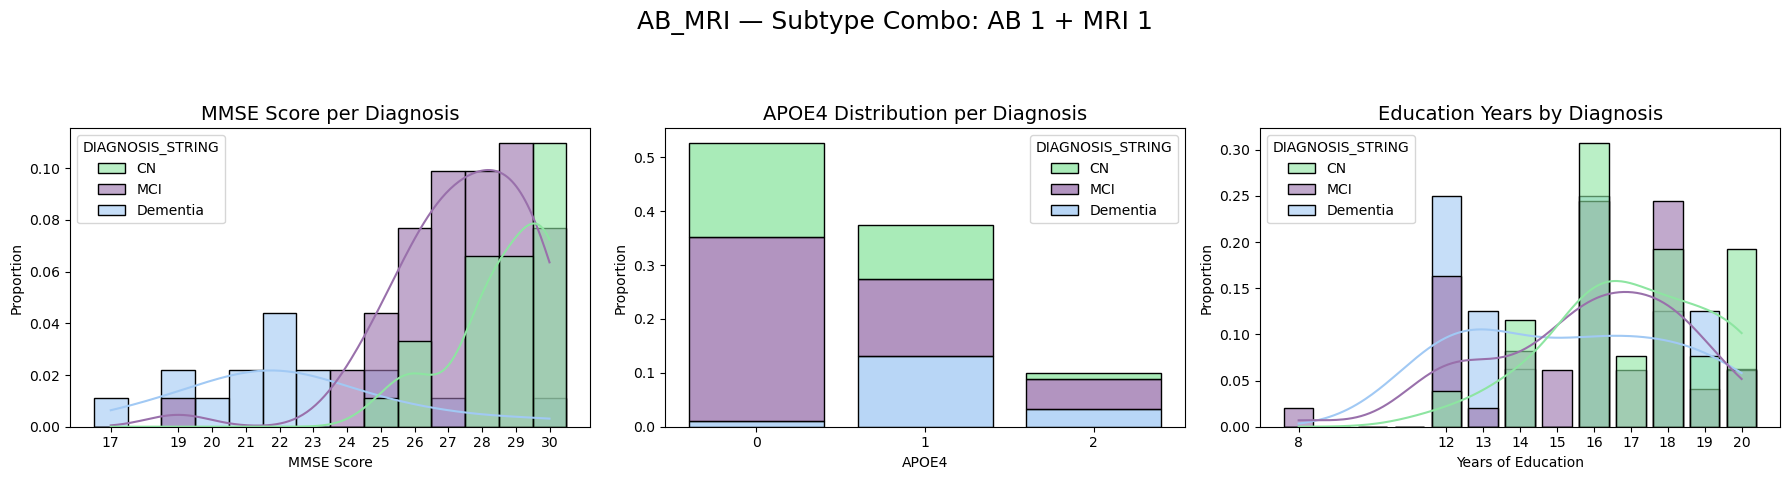


======= Plotting for TAU_MRI Subtype Combinations =======



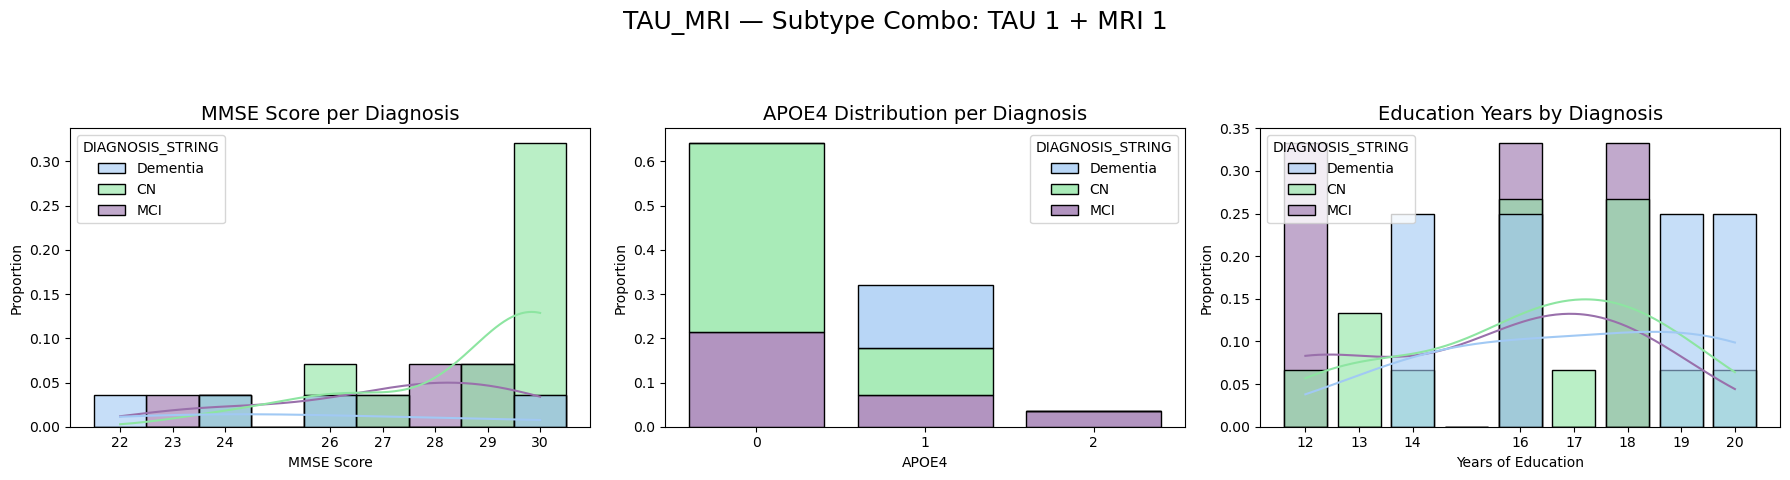

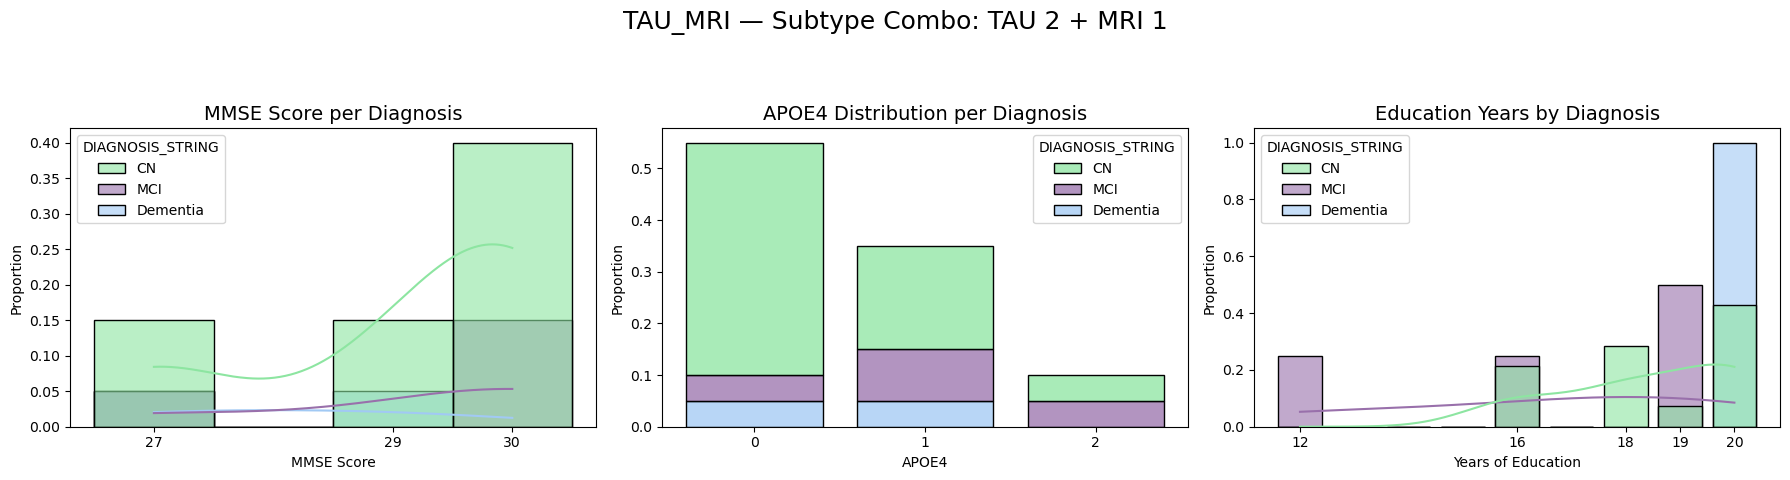

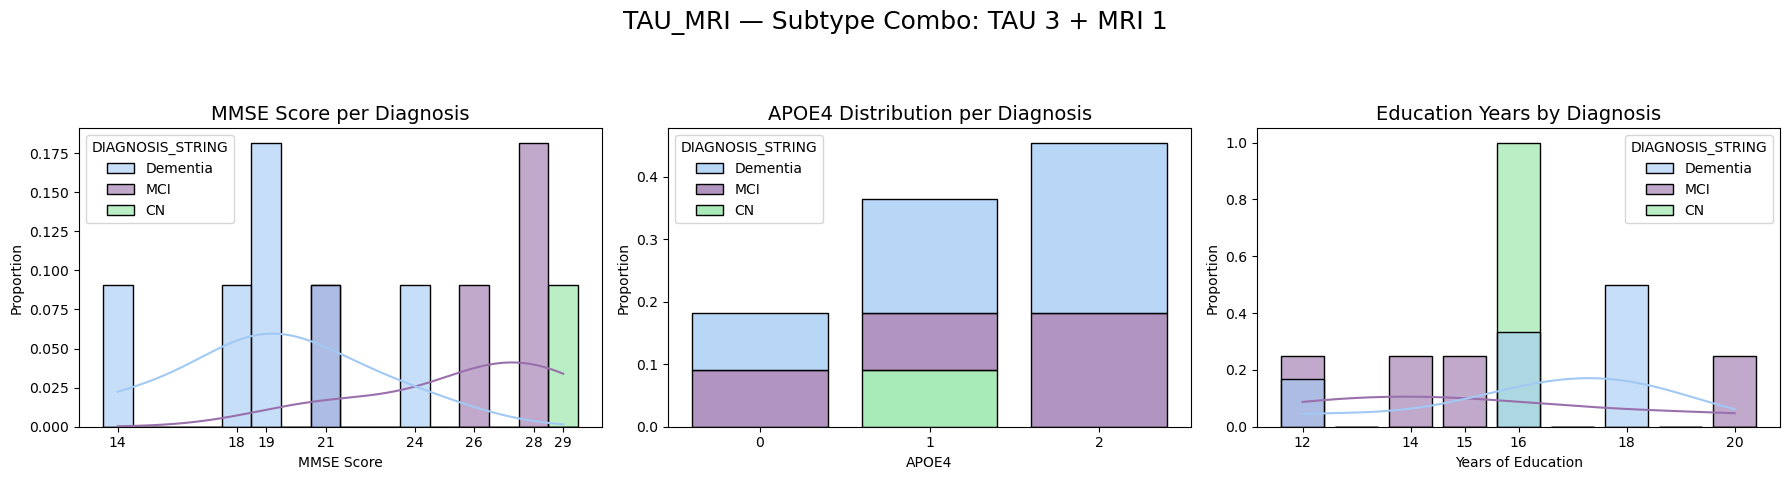


======= Plotting for AB_TAU Subtype Combinations =======



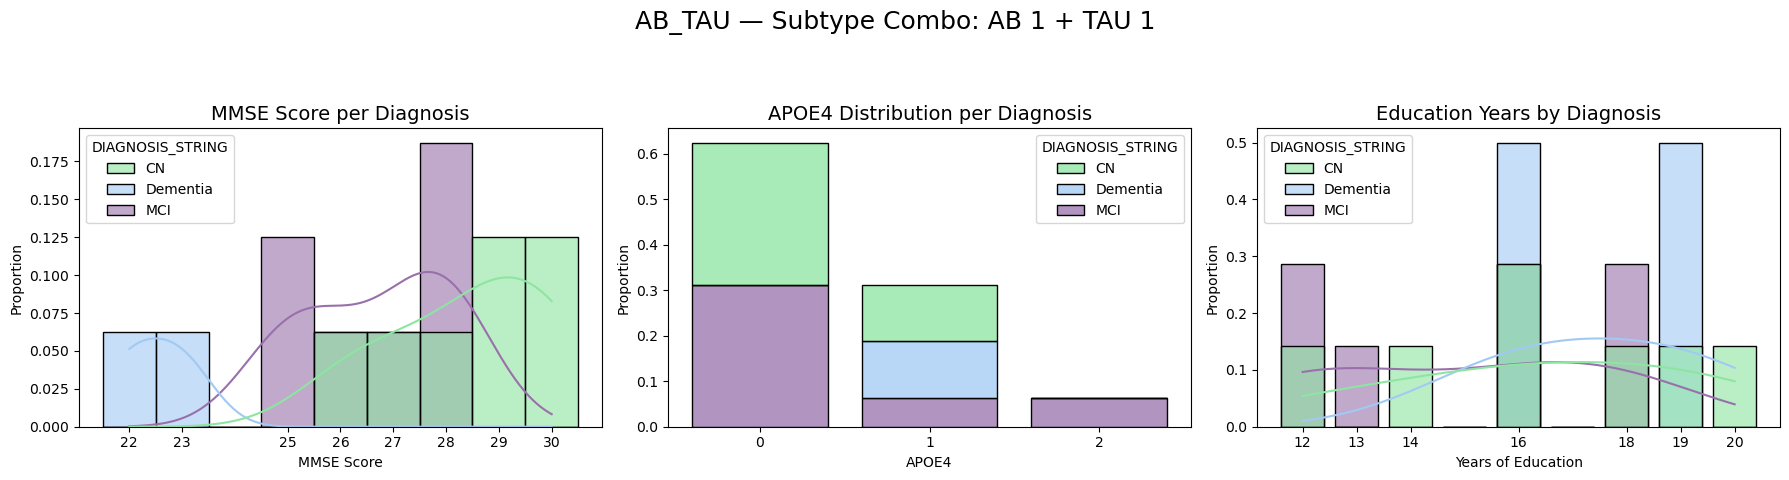

In [31]:
# Dictionary: (dataset, modality1 subtype, modality2 subtype, label)
merged_sets = {
    "AB_MRI": (merged_ab_mri, "ml_subtype_AB", "ml_subtype_MRI"),
    "TAU_MRI": (merged_tau_mri, "ml_subtype_TAU", "ml_subtype_MRI"),
    "AB_TAU": (merged_ab_tau, "ml_subtype_AB", "ml_subtype_TAU"),
}

diagnosis_palette = {
    'CN': '#8de5a1',       
    'MCI': '#9970AB',      
    'Dementia': '#a1c9f4'  
}


for name, (df, subtype1, subtype2) in merged_sets.items():
    print(f"\n======= Plotting for {name} Subtype Combinations =======\n")

    # Filter MMSE > 0
    df = df[df[mmse_score] > 0]

    for sub1 in sorted(df[subtype1].dropna().unique()):
        for sub2 in sorted(df[subtype2].dropna().unique()):
            subset_df = df[(df[subtype1] == sub1) & (df[subtype2] == sub2)]

            if len(subset_df) < 10:
                continue  # Skip small groups

            fig, axs = plt.subplots(1, 3, figsize=(18, 5))
            fig.suptitle(f"{name} — Subtype Combo: {subtype1.split('_')[-1]} {int(sub1)+1} + {subtype2.split('_')[-1]} {int(sub2)+1}", fontsize=18)
            plt.subplots_adjust(wspace=0.3)

            # MMSE
            sns.histplot(data=subset_df, x=mmse_score, hue=dx, kde=True, multiple="layer", palette=diagnosis_palette,
                         alpha=0.6, ax=axs[0], stat="probability", discrete=True)
            axs[0].set_title("MMSE Score per Diagnosis", fontsize=14)
            axs[0].set_xlabel("MMSE Score")
            axs[0].set_ylabel("Proportion")
            axs[0].set_xticks(sorted(subset_df[mmse_score].dropna().unique()))

            # APOE4
            sns.histplot(data=subset_df, x=apoe4, hue=dx, multiple="stack", palette=diagnosis_palette,
                         ax=axs[1], stat="probability", discrete=True, shrink=0.8)
            axs[1].set_title("APOE4 Distribution per Diagnosis", fontsize=14)
            axs[1].set_xlabel("APOE4")
            axs[1].set_ylabel("Proportion")
            axs[1].set_xticks(sorted(subset_df[apoe4].dropna().unique()))

            # Education
            sns.histplot(data=subset_df, x=educ, hue=dx, kde=True, multiple="layer", palette=diagnosis_palette,
                         alpha=0.6, ax=axs[2], stat="probability", common_norm=False,
                         discrete=True, shrink=0.8)
            axs[2].set_title("Education Years by Diagnosis", fontsize=14)
            axs[2].set_xlabel("Years of Education")
            axs[2].set_ylabel("Proportion")
            axs[2].set_xticks(sorted(subset_df[educ].dropna().unique()))

            plt.tight_layout(rect=[0, 0.03, 1, 0.90])
            plt.show()



======= Gender Representation in AB_MRI Combined Subtypes (Proportional to Overall) =======


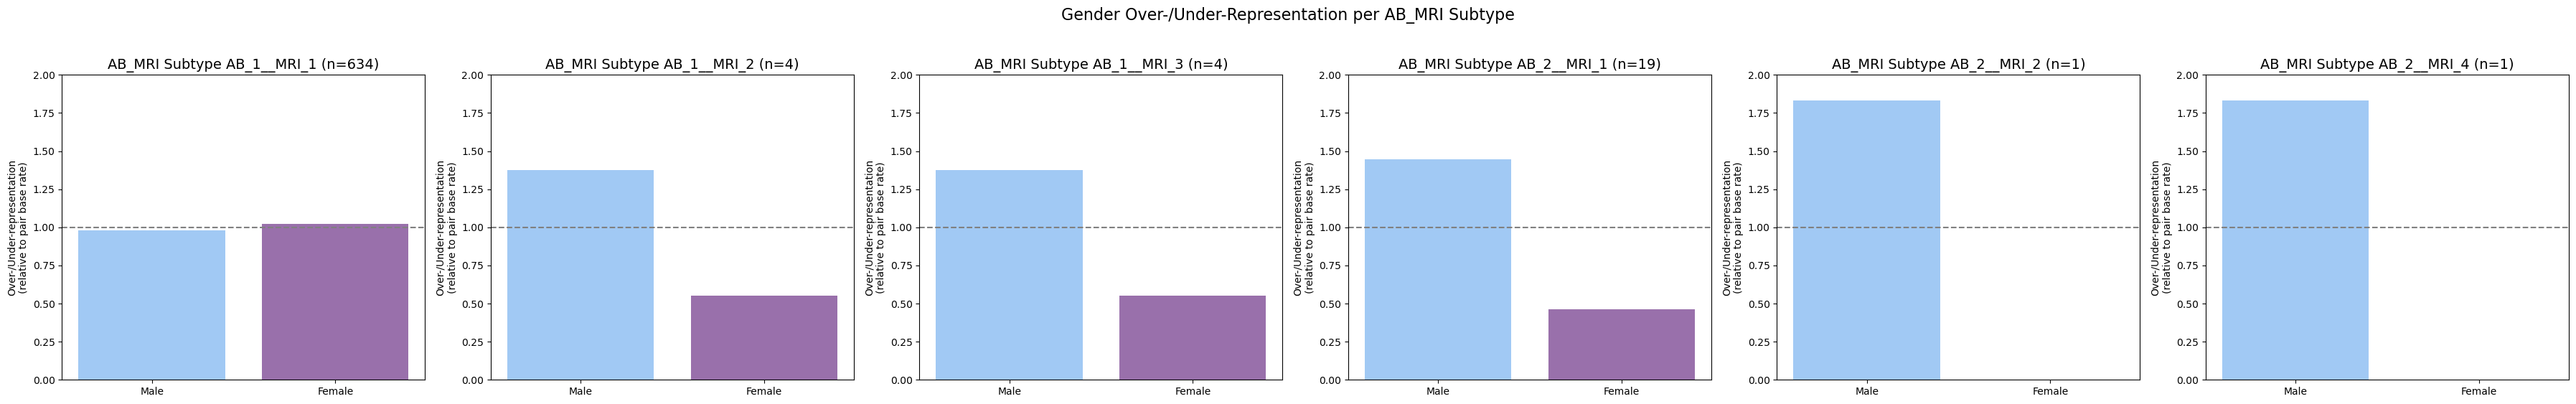


======= Gender Representation in AB_TAU Combined Subtypes (Proportional to Overall) =======


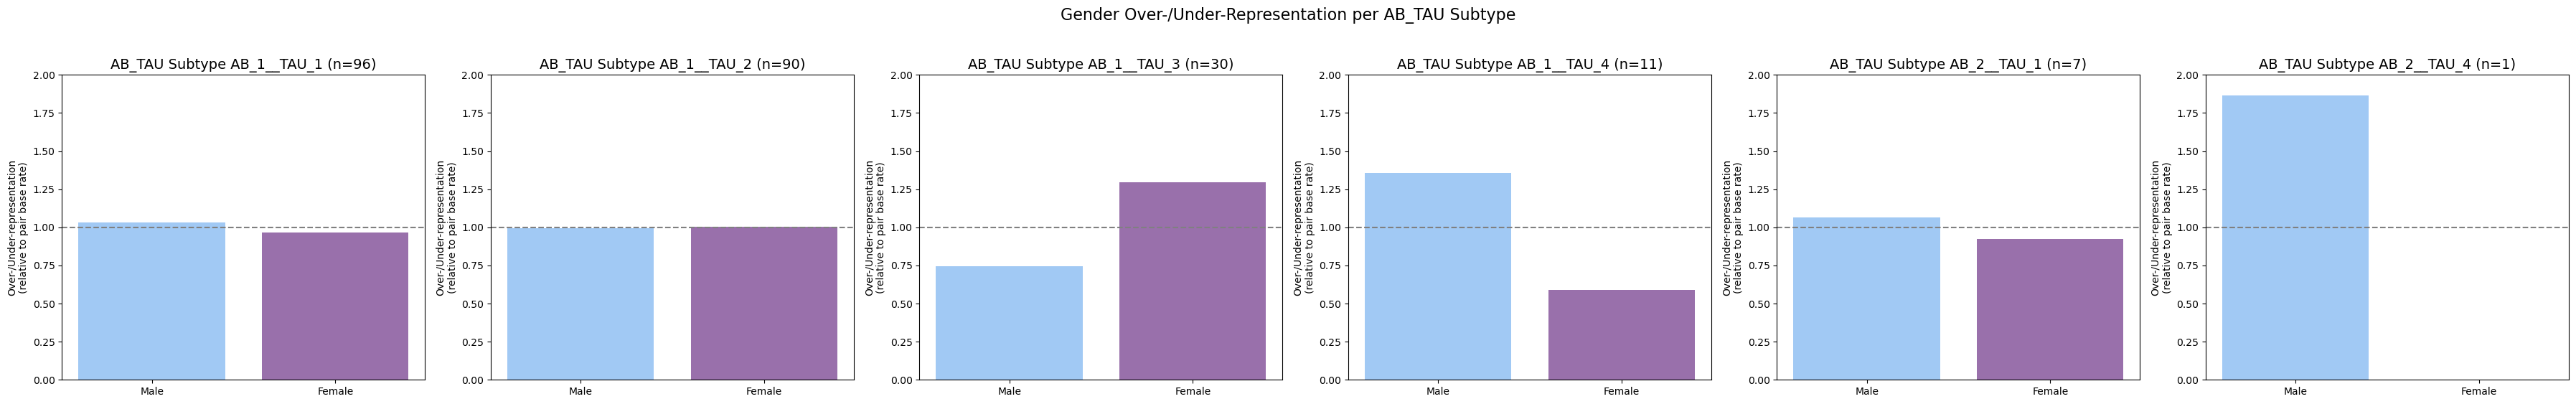


======= Gender Representation in TAU_MRI Combined Subtypes (Proportional to Overall) =======


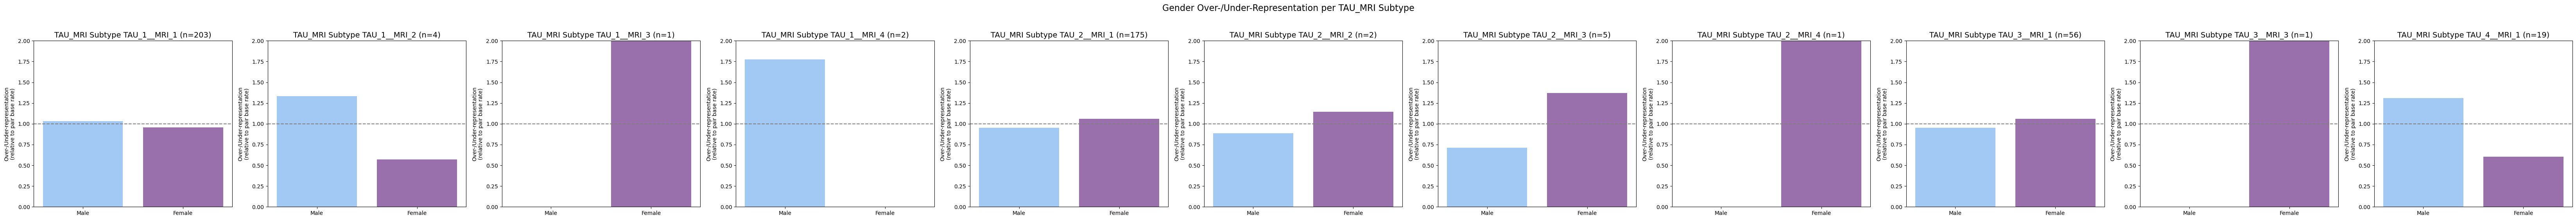

In [40]:
# Gender map: 1 = Male, 2 = Female
gender_map = {1.0: 'Male', 2.0: 'Female'}
gender_order = ['Male', 'Female']
gender_colors = ['#a1c9f4', '#9970AB']  # Blue for Male, Red for Female

# Merged pairs: dataframe, subtype cols, stage col
merged_pairs = {
    'AB_MRI': (merged_ab_mri, 'ml_subtype_AB', 'ml_subtype_MRI'),
    'AB_TAU': (merged_ab_tau, 'ml_subtype_AB', 'ml_subtype_TAU'),
    'TAU_MRI': (merged_tau_mri, 'ml_subtype_TAU', 'ml_subtype_MRI')
}

for pair_name, (df, sub1_col, sub2_col) in merged_pairs.items():
    print(f"\n======= Gender Representation in {pair_name} Combined Subtypes (Proportional to Overall) =======")
    
    df = df.copy()
    df['GenderStr'] = df[gender].map(gender_map)
    # Add 1 to subtype labels and convert to int, then to str
    sub1_mod = df[sub1_col].add(1).astype(int).astype(str)
    sub2_mod = df[sub2_col].add(1).astype(int).astype(str)
    # Use modality names in label (e.g., AB1_MRI2)
    modality1 = sub1_col.split('_')[-1]
    modality2 = sub2_col.split('_')[-1]
    df['combined_subtype'] = f"{modality1}_" + sub1_mod + f"__{modality2}_" + sub2_mod


    # Drop missing genders
    df = df.dropna(subset=['GenderStr', 'combined_subtype'])

    # Overall gender base rates
    overall_counts = df['GenderStr'].value_counts()
    overall_total = overall_counts.sum()
    overall_props = overall_counts / overall_total

    unique_subtypes = sorted(df['combined_subtype'].unique())
    n_subtypes = len(unique_subtypes)
    fig, axs = plt.subplots(1, n_subtypes, figsize=(6 * n_subtypes, 6))
    if n_subtypes == 1:
        axs = [axs]

    for i, subtype in enumerate(unique_subtypes):
        subset_df = df[df['combined_subtype'] == subtype]
        gender_counts = subset_df['GenderStr'].value_counts()
        total = gender_counts.sum()

        # Proportion relative to overall (normalized)
        normalized_props = (gender_counts / total) / overall_props

        # Ensure consistent gender order
        normalized_props = normalized_props.reindex(gender_order).fillna(0)

        axs[i].bar(gender_order, normalized_props.values, color=gender_colors)
        axs[i].set_ylim(0, 2)
        axs[i].axhline(1.0, color='gray', linestyle='--')
        axs[i].set_title(f"{pair_name} Subtype {subtype} (n={total})", fontsize=14)
        axs[i].set_ylabel("Over-/Under-representation\n(relative to pair base rate)")

    plt.suptitle(f"Gender Over-/Under-Representation per {pair_name} Subtype", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()



======= APOE4 Representation in AB_MRI Combined Subtypes (Proportional to Overall) =======


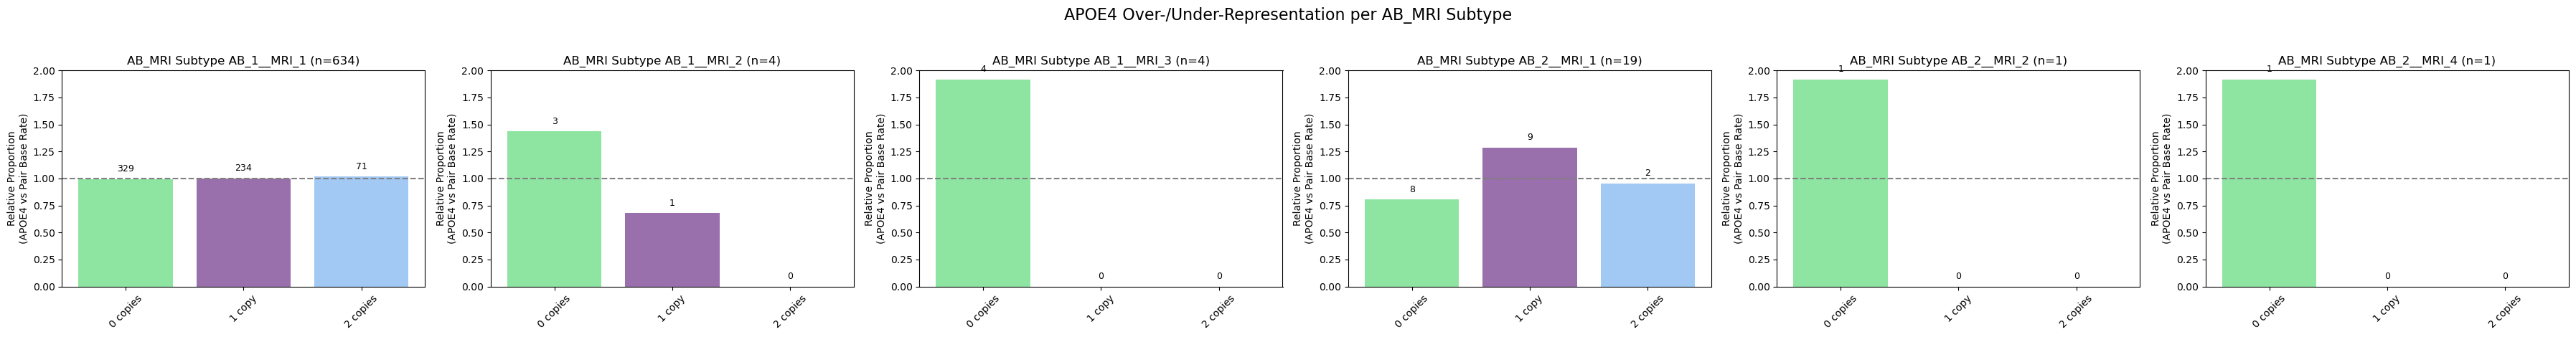


======= APOE4 Representation in AB_TAU Combined Subtypes (Proportional to Overall) =======


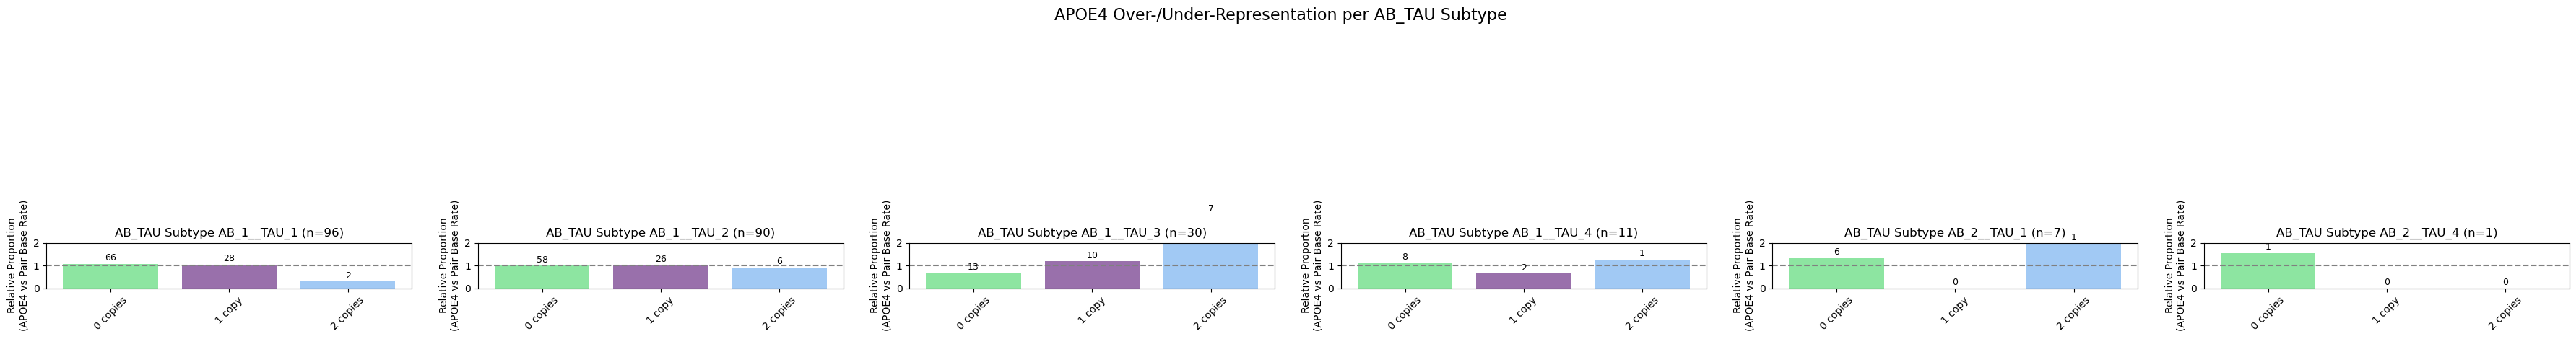


======= APOE4 Representation in TAU_MRI Combined Subtypes (Proportional to Overall) =======


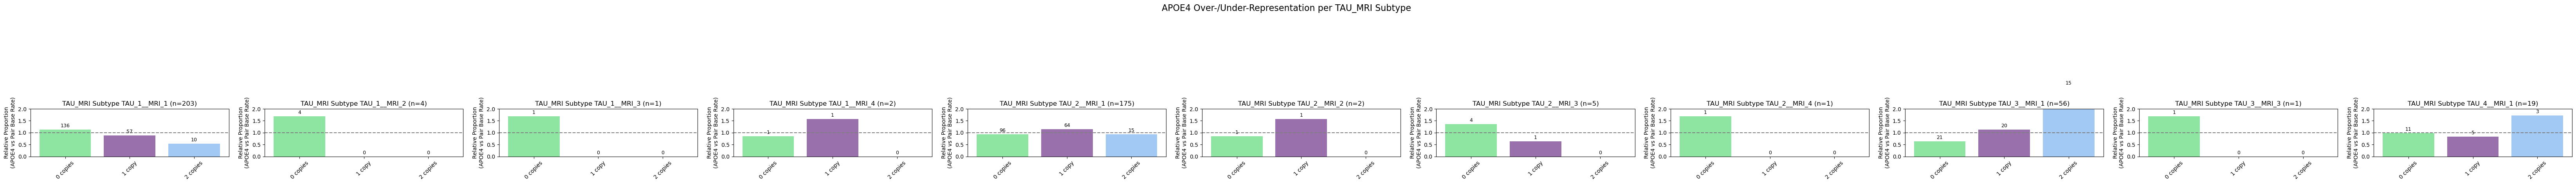

In [47]:
# APOE4 allele count plots for combined subtypes (e.g., AB-MRI, AB-TAU, TAU-MRI)
colors = ['#8de5a1', '#9970AB', '#a1c9f4']   # 0, 1, 2 copies
labels = ['0 copies', '1 copy', '2 copies']
allele_order = [0, 1, 2]

for pair_name, (df, sub1_col, sub2_col) in merged_pairs.items():
    print(f"\n======= APOE4 Representation in {pair_name} Combined Subtypes (Proportional to Overall) =======")
    
    df = df.copy()
    # Add 1 to subtype labels and convert to int, then to str
    sub1_mod = df[sub1_col].add(1).astype(int).astype(str)
    sub2_mod = df[sub2_col].add(1).astype(int).astype(str)
    # Use modality names in label (e.g., AB1_MRI2)
    modality1 = sub1_col.split('_')[-1]
    modality2 = sub2_col.split('_')[-1]
    df['combined_subtype'] = f"{modality1}_" + sub1_mod + f"__{modality2}_" + sub2_mod

    df = df.dropna(subset=['combined_subtype', apoe4])

    base_rate = df[apoe4].value_counts(normalize=True).reindex(allele_order, fill_value=0)

    unique_subtypes = sorted(df['combined_subtype'].unique())
    fig, axs = plt.subplots(1, len(unique_subtypes), figsize=(6 * len(unique_subtypes), 5))
    if len(unique_subtypes) == 1:
        axs = [axs]

    for i, subtype in enumerate(unique_subtypes):
        sub_df = df[df['combined_subtype'] == subtype]
        counts_prop = sub_df[apoe4].value_counts(normalize=True).reindex(allele_order, fill_value=0)
        counts_abs = sub_df[apoe4].value_counts().reindex(allele_order, fill_value=0)

        norm_counts = (counts_prop / base_rate).fillna(0)

        axs[i].bar(labels, norm_counts.values, color=colors)
        axs[i].axhline(1, linestyle='--', color='gray')
        axs[i].set_ylim(0, 2)
        axs[i].set_title(f"{pair_name} Subtype {subtype} (n={len(sub_df)})")
        axs[i].set_ylabel('Relative Proportion\n(APOE4 vs Pair Base Rate)')
        axs[i].tick_params(axis='x', rotation=45)

        # Add count labels above bars
        for x_pos, count in enumerate(counts_abs.values):
            axs[i].text(x_pos, norm_counts.values[x_pos] + 0.05, str(int(count)), 
                        ha='center', va='bottom', fontsize=9)

    plt.suptitle(f"APOE4 Over-/Under-Representation per {pair_name} Subtype", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


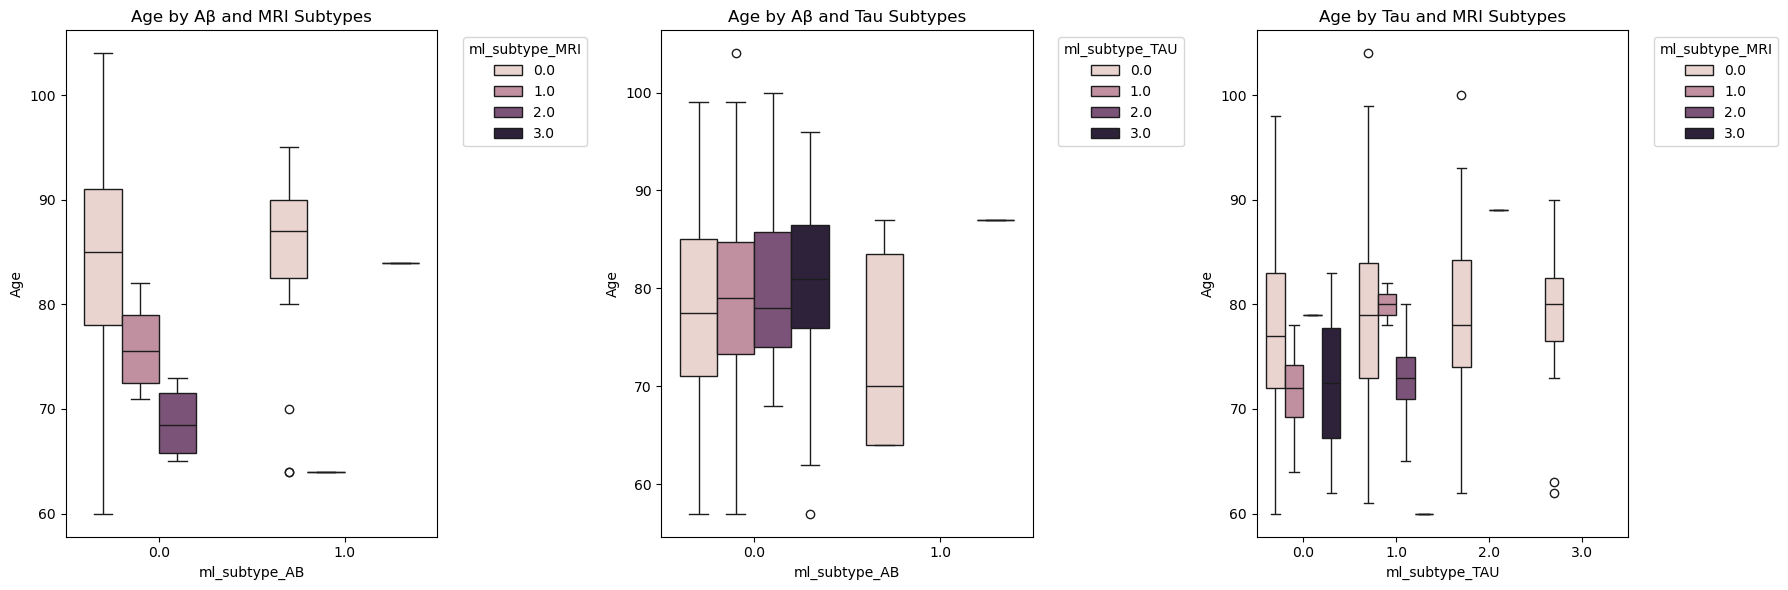


Age Summary: Aβ–MRI Subtype Pairs
                 n  median  mean  std   q25   q75
subtype_pair                                    
0.0-0.0       634   85.00 84.36 8.70 78.00 91.00
1.0-0.0        19   87.00 84.16 9.07 82.50 90.00

Age Summary: Aβ–Tau Subtype Pairs
                n  median  mean   std   q25   q75
subtype_pair                                    
0.0-0.0       96   77.50 77.90 10.09 71.00 85.00
0.0-1.0       90   79.00 79.17  8.80 73.25 84.75
0.0-2.0       30   78.00 79.67  7.82 74.00 85.75
0.0-3.0       11   81.00 79.45 11.66 76.00 86.50

Age Summary: Tau–MRI Subtype Pairs
                 n  median  mean  std   q25   q75
subtype_pair                                    
0.0-0.0       203   77.00 77.32 8.49 72.00 83.00
1.0-0.0       175   79.00 78.75 7.75 73.00 84.00
2.0-0.0        56   78.00 79.27 7.79 74.00 84.25
3.0-0.0        19   80.00 78.68 7.10 76.50 82.50


In [42]:
def stats_pair(df, subtype_col1, subtype_col2, variable, min_group_size=10):
    # Create subtype pair column
    df = df.dropna(subset=[variable, subtype_col1, subtype_col2]).copy()
    df['subtype_pair'] = df[subtype_col1].astype(str) + '-' + df[subtype_col2].astype(str)
    group_counts = df['subtype_pair'].value_counts()
    valid_pairs = group_counts[group_counts >= min_group_size].index
    filtered_df = df[df['subtype_pair'].isin(valid_pairs)]

    # Summary stats
    summary = filtered_df.groupby('subtype_pair')[variable].agg(
        n='count',
        median='median',
        mean='mean',
        std='std',
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75)
    ).round(2)
    return summary

def plot_side_by_side_boxplots(
    df1, x1, hue1, y1, title1,
    df2, x2, hue2, y2, title2,
    df3, x3, hue3, y3, title3,
    figsize=(18, 6)
):
    plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)
    sns.boxplot(data=df1, x=x1, y=y1, hue=hue1)
    plt.title(title1)
    plt.xlabel(x1)
    plt.ylabel(y1)
    plt.legend(title=hue1, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 3, 2)
    sns.boxplot(data=df2, x=x2, y=y2, hue=hue2)
    plt.title(title2)
    plt.xlabel(x2)
    plt.ylabel(y2)
    plt.legend(title=hue2, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 3, 3)
    sns.boxplot(data=df3, x=x3, y=y3, hue=hue3)
    plt.title(title3)
    plt.xlabel(x3)
    plt.ylabel(y3)
    plt.legend(title=hue3, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


# Filter datasets for valid Age (e.g., Age > 0)
merged_ab_mri_clean_age = merged_ab_mri[merged_ab_mri[age] > 0]
merged_ab_tau_clean_age = merged_ab_tau[merged_ab_tau[age] > 0]
merged_tau_mri_clean_age = merged_tau_mri[merged_tau_mri[age] > 0]

# Plot side by side boxplots for Age
plot_side_by_side_boxplots(
    merged_ab_mri_clean_age, 'ml_subtype_AB', 'ml_subtype_MRI', age, 'Age by Aβ and MRI Subtypes',
    merged_ab_tau_clean_age, 'ml_subtype_AB', 'ml_subtype_TAU', age, 'Age by Aβ and Tau Subtypes',
    merged_tau_mri_clean_age, 'ml_subtype_TAU', 'ml_subtype_MRI', age, 'Age by Tau and MRI Subtypes'
)

# Get summary stats for Age by subtype pairs
age_ab_mri_summary = stats_pair(merged_ab_mri_clean_age, 'ml_subtype_AB', 'ml_subtype_MRI', age)
age_ab_tau_summary = stats_pair(merged_ab_tau_clean_age, 'ml_subtype_AB', 'ml_subtype_TAU', age)
age_tau_mri_summary = stats_pair(merged_tau_mri_clean_age, 'ml_subtype_TAU', 'ml_subtype_MRI', age)

print("\nAge Summary: Aβ–MRI Subtype Pairs\n", age_ab_mri_summary)
print("\nAge Summary: Aβ–Tau Subtype Pairs\n", age_ab_tau_summary)
print("\nAge Summary: Tau–MRI Subtype Pairs\n", age_tau_mri_summary)


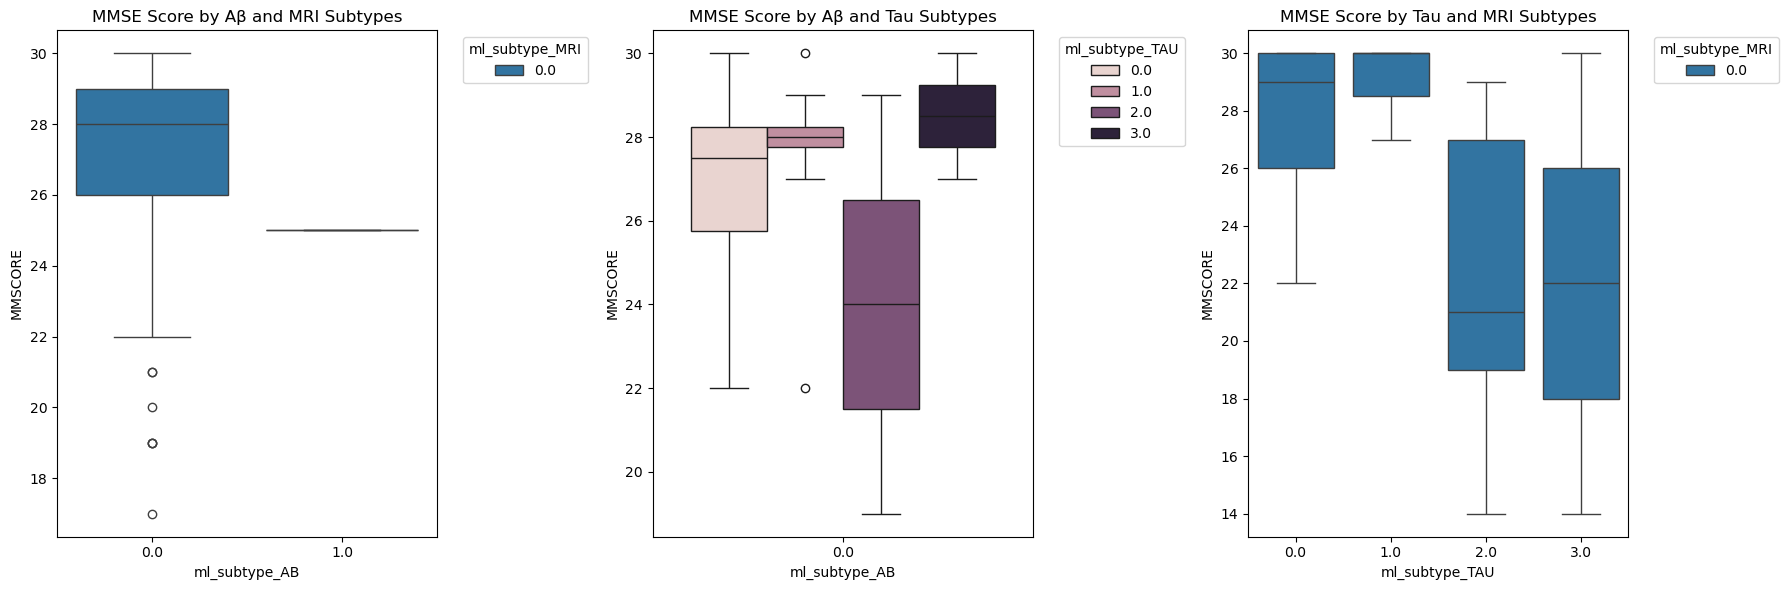


MMSE Score Summary: Aβ–MRI Subtype Pairs
                n  median  mean  std   q25   q75
subtype_pair                                   
0.0-0.0       91   28.00 26.89 3.06 26.00 29.00

MMSE Score Summary: Aβ–Tau Subtype Pairs
                n  median  mean  std   q25   q75
subtype_pair                                   
0.0-0.0       16   27.50 26.94 2.32 25.75 28.25

MMSE Score Summary: Tau–MRI Subtype Pairs
                n  median  mean  std   q25   q75
subtype_pair                                   
0.0-0.0       28   29.00 27.75 2.53 26.00 30.00
1.0-0.0       20   30.00 29.05 1.28 28.50 30.00
2.0-0.0       11   21.00 22.45 4.89 19.00 27.00


In [43]:
# Filter datasets for valid MMSE score (e.g., mmse_score > 0)
merged_ab_mri_clean_mmse = merged_ab_mri[merged_ab_mri[mmse_score] > 0]
merged_ab_tau_clean_mmse = merged_ab_tau[merged_ab_tau[mmse_score] > 0]
merged_tau_mri_clean_mmse = merged_tau_mri[merged_tau_mri[mmse_score] > 0]

# Plot side by side boxplots for MMSE score
plot_side_by_side_boxplots(
    merged_ab_mri_clean_mmse, 'ml_subtype_AB', 'ml_subtype_MRI', mmse_score, 'MMSE Score by Aβ and MRI Subtypes',
    merged_ab_tau_clean_mmse, 'ml_subtype_AB', 'ml_subtype_TAU', mmse_score, 'MMSE Score by Aβ and Tau Subtypes',
    merged_tau_mri_clean_mmse, 'ml_subtype_TAU', 'ml_subtype_MRI', mmse_score, 'MMSE Score by Tau and MRI Subtypes'
)

# Get summary stats for MMSE by subtype pairs
mmse_ab_mri_summary = stats_pair(merged_ab_mri_clean_mmse, 'ml_subtype_AB', 'ml_subtype_MRI', mmse_score)
mmse_ab_tau_summary = stats_pair(merged_ab_tau_clean_mmse, 'ml_subtype_AB', 'ml_subtype_TAU', mmse_score)
mmse_tau_mri_summary = stats_pair(merged_tau_mri_clean_mmse, 'ml_subtype_TAU', 'ml_subtype_MRI', mmse_score)

print("\nMMSE Score Summary: Aβ–MRI Subtype Pairs\n", mmse_ab_mri_summary)
print("\nMMSE Score Summary: Aβ–Tau Subtype Pairs\n", mmse_ab_tau_summary)
print("\nMMSE Score Summary: Tau–MRI Subtype Pairs\n", mmse_tau_mri_summary)


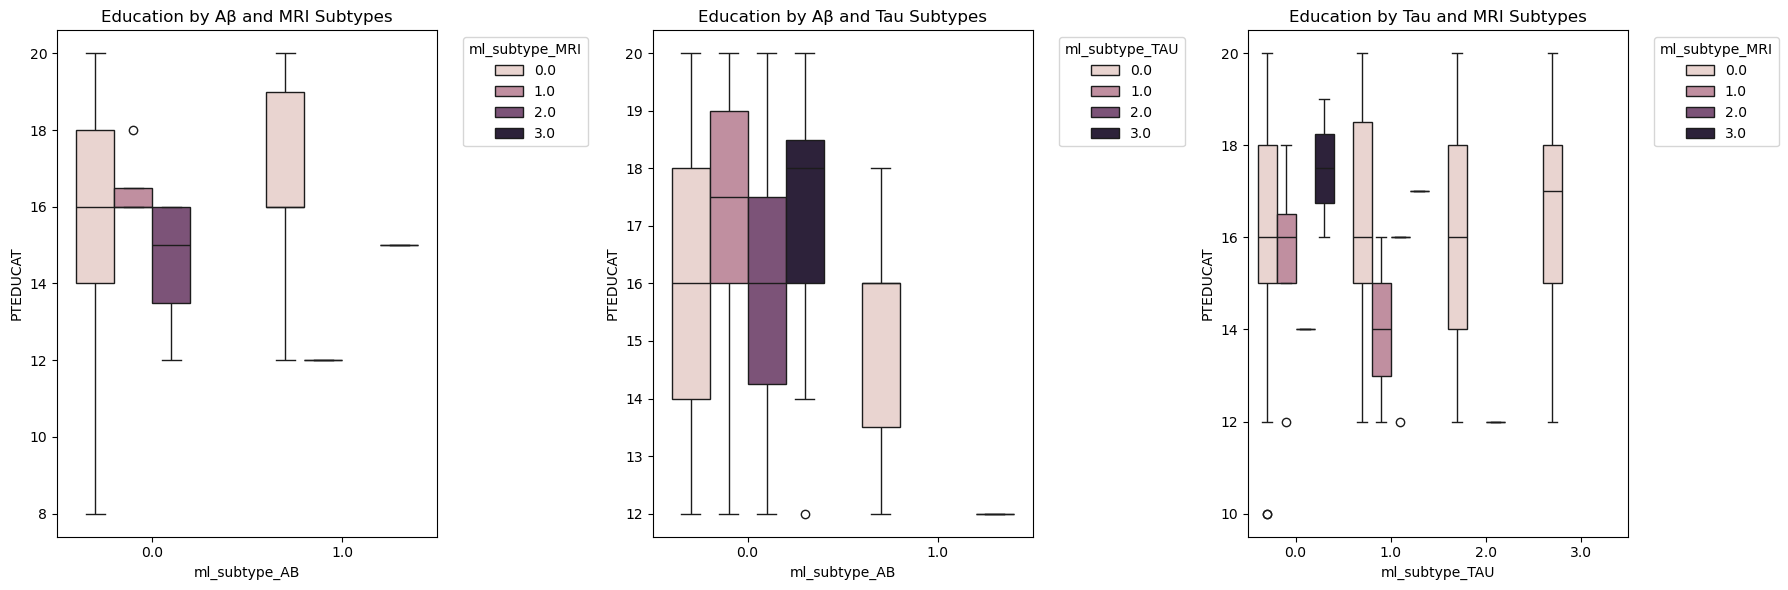


Education Summary: Aβ–MRI Subtype Pairs
                 n  median  mean  std   q25   q75
subtype_pair                                    
0.0-0.0       634   16.00 16.14 2.58 14.00 18.00
1.0-0.0        19   16.00 16.58 2.81 16.00 19.00

Education Summary: Aβ–Tau Subtype Pairs
                n  median  mean  std   q25   q75
subtype_pair                                   
0.0-0.0       96   16.00 16.30 2.39 14.00 18.00
0.0-1.0       90   17.50 17.00 2.50 16.00 19.00
0.0-2.0       30   16.00 15.97 2.06 14.25 17.50
0.0-3.0       11   18.00 17.09 2.39 16.00 18.50

Education Summary: Tau–MRI Subtype Pairs
                 n  median  mean  std   q25   q75
subtype_pair                                    
0.0-0.0       203   16.00 16.41 2.32 15.00 18.00
1.0-0.0       175   16.00 16.68 2.49 15.00 18.50
2.0-0.0        56   16.00 15.84 2.33 14.00 18.00
3.0-0.0        19   17.00 16.32 2.52 15.00 18.00


In [44]:
# Filter datasets for PTEDUCAT > 0 or valid if needed
merged_ab_mri_clean = merged_ab_mri[merged_ab_mri[educ] > 0]
merged_ab_tau_clean = merged_ab_tau[merged_ab_tau[educ] > 0]
merged_tau_mri_clean = merged_tau_mri[merged_tau_mri[educ] > 0]

plot_side_by_side_boxplots(
    merged_ab_mri_clean, 'ml_subtype_AB', 'ml_subtype_MRI', educ, 'Education by Aβ and MRI Subtypes',
    merged_ab_tau_clean, 'ml_subtype_AB', 'ml_subtype_TAU', educ, 'Education by Aβ and Tau Subtypes',
    merged_tau_mri_clean, 'ml_subtype_TAU', 'ml_subtype_MRI', educ, 'Education by Tau and MRI Subtypes'
)

education_ab_mri_summary = stats_pair(merged_ab_mri_clean, 'ml_subtype_AB', 'ml_subtype_MRI', educ)
education_ab_tau_summary = stats_pair(merged_ab_tau_clean, 'ml_subtype_AB', 'ml_subtype_TAU', educ)
education_tau_mri_summary = stats_pair(merged_tau_mri_clean, 'ml_subtype_TAU', 'ml_subtype_MRI', educ)

print("\nEducation Summary: Aβ–MRI Subtype Pairs\n", education_ab_mri_summary)
print("\nEducation Summary: Aβ–Tau Subtype Pairs\n", education_ab_tau_summary)
print("\nEducation Summary: Tau–MRI Subtype Pairs\n", education_tau_mri_summary)


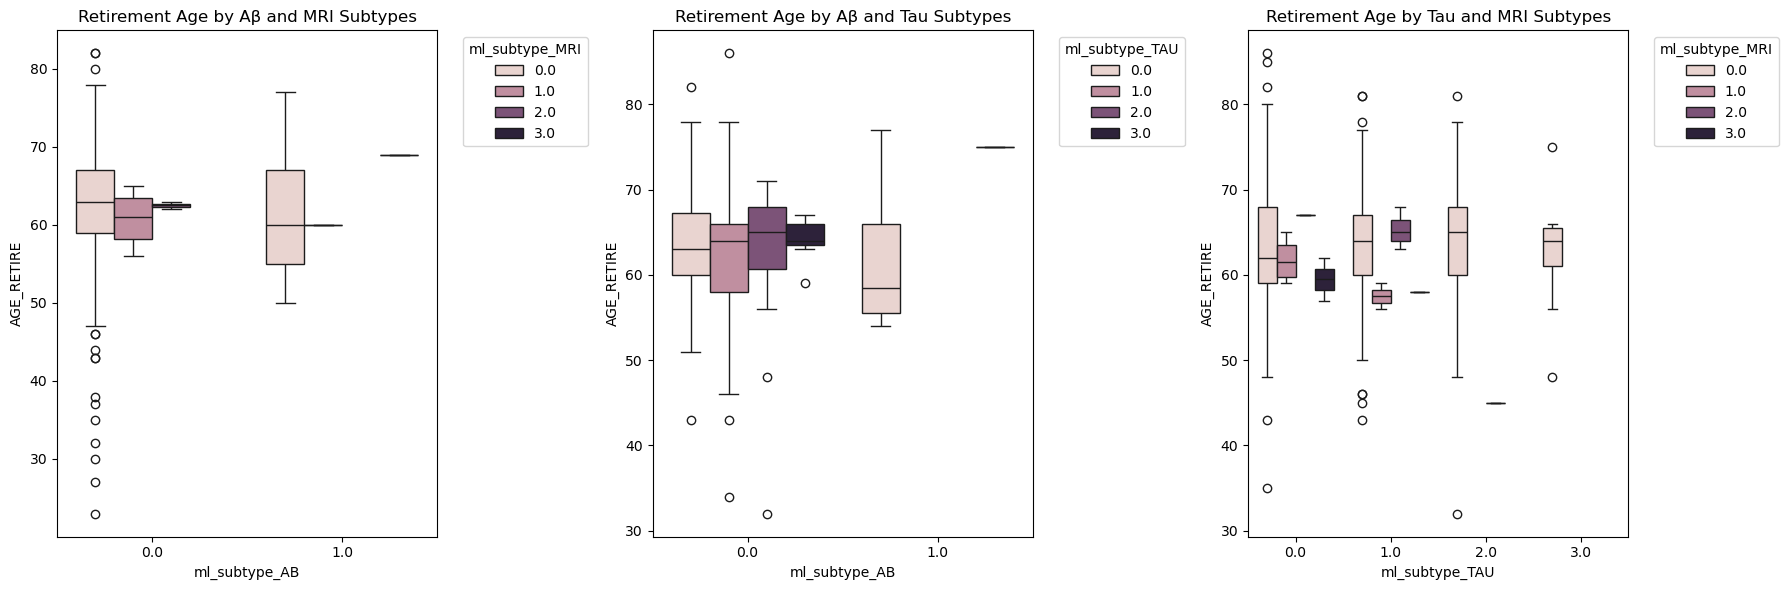


Retirement Age Summary: Aβ–MRI Subtype Pairs
                 n  median  mean  std   q25   q75
subtype_pair                                    
0.0-0.0       503   63.00 62.55 7.49 59.00 67.00
1.0-0.0        17   60.00 61.71 8.11 55.00 67.00

Retirement Age Summary: Aβ–Tau Subtype Pairs
                n  median  mean  std   q25   q75
subtype_pair                                   
0.0-0.0       72   63.00 63.75 6.76 60.00 67.25
0.0-1.0       69   64.00 62.03 7.95 58.00 66.00
0.0-2.0       24   65.00 62.88 8.46 60.75 68.00

Retirement Age Summary: Tau–MRI Subtype Pairs
                 n  median  mean  std   q25   q75
subtype_pair                                    
0.0-0.0       159   62.00 63.04 7.67 59.00 68.00
1.0-0.0       133   64.00 63.44 7.03 60.00 67.00
2.0-0.0        48   65.00 64.40 7.71 60.00 68.00
3.0-0.0        15   64.00 62.60 5.99 61.00 65.50


In [45]:
# Filter datasets for valid retire_age (e.g., retire_age > 0)
merged_ab_mri_clean_retire = merged_ab_mri[merged_ab_mri[retire_age] > 0]
merged_ab_tau_clean_retire = merged_ab_tau[merged_ab_tau[retire_age] > 0]
merged_tau_mri_clean_retire = merged_tau_mri[merged_tau_mri[retire_age] > 0]

# Plot side by side boxplots for retire_age
plot_side_by_side_boxplots(
    merged_ab_mri_clean_retire, 'ml_subtype_AB', 'ml_subtype_MRI', retire_age, 'Retirement Age by Aβ and MRI Subtypes',
    merged_ab_tau_clean_retire, 'ml_subtype_AB', 'ml_subtype_TAU', retire_age, 'Retirement Age by Aβ and Tau Subtypes',
    merged_tau_mri_clean_retire, 'ml_subtype_TAU', 'ml_subtype_MRI', retire_age, 'Retirement Age by Tau and MRI Subtypes'
)

# Get summary stats for retire_age by subtype pairs
retire_ab_mri_summary = stats_pair(merged_ab_mri_clean_retire, 'ml_subtype_AB', 'ml_subtype_MRI', retire_age)
retire_ab_tau_summary = stats_pair(merged_ab_tau_clean_retire, 'ml_subtype_AB', 'ml_subtype_TAU', retire_age)
retire_tau_mri_summary = stats_pair(merged_tau_mri_clean_retire, 'ml_subtype_TAU', 'ml_subtype_MRI', retire_age)

print("\nRetirement Age Summary: Aβ–MRI Subtype Pairs\n", retire_ab_mri_summary)
print("\nRetirement Age Summary: Aβ–Tau Subtype Pairs\n", retire_ab_tau_summary)
print("\nRetirement Age Summary: Tau–MRI Subtype Pairs\n", retire_tau_mri_summary)
